# Hiking with iNaturalist

**Can a model learn to “see” an iNaturalist user’s hikes?** <br>
<br>
In my last notebook, I explored this question via a case study by choosing a random user from the larger dataset, performing EDA and then applying models that attempt to identify clusters that correspond to a user's hikes.
In this notebook, I explore this question on 225 of the 300 users in my larger dataset. [(For a description of that dataset see my README file on github).](https://github.com/mccoolgrime/BrainStationCapstone)

My initial model is a rules-based heuristic model that simply groups the data by individual dates and uses a "minimum sample" measure (just as DBSCAN does) to identify individual "hikes" and then "noise". I use visualization and silhouette scores to compare this heuristic model's performance against DBSCAN which provides a kind of external validation for this unsupervised machine learning in addition to the internal validation of the silhouette scores.

I chose DBSCAN as the clustering algorithm for the following reasons:

* The clusters I want to find are irregularly shaped, which DBSCAN is well-suited to finding compared to the other algortithms we've learned.
* The number of clusters (or "hikes") we are looking for varies with each user. This means DBSCAN is more likely to be able to build a "one-size-fits-all" model because it does not require "knowing" the number of clusters it is seeking, but finds that number based on the data, whereas the other algorithms we've learned require that information as input.
* The data I have includes "noise": one- and two- off observations that do not make a hike. Other algorithms we've learned seek to classify all data inside one of the clusters which would require me to allow those models to find a lot of "clusters" with only one observation, whereas DBSCAN is designed to identify clusters inside of noise, making it well-suited to this kind of modeling.

I found that DBSCAN can do as well and even a little better than the basic heuristic model although the heuristic does very well and can likely be refined with additional rules. Regardless, I was able to find models that reasonably cluster around "hike-like behavior" compared to "one-off behavior" (the noise). While there are plenty of applications around user engagement for simply finding the hikes, I am particularly interested in the ways in which clusters and noise can help describe user behavior, which can contribute to scientific research as well as targeted user engagement, if studied further. 

Below is the work I've done thus far. It exists as a pretty solid proof of concept that needs at least two major tweaks before I would feel good about the science behind it:
1) I took a shortcut with the dates and used UTC but need to convert to local time for accurate clustering for both the heuristic and the DBSCAN feature selection
2) I am shaky on hypothesis testing and need to study that further and likely make changes before I felt confident about my tests and claims

I would like to note that, while I think my work has plenty of potential for positive impact for iNaturalist toward its mission, we also live in a world where both humans and endangered species are stalked with harmful intent and, in the wrong hands, this work could also have harmful impact. For that reason, I ask that people engaging with this work be thoughtful about how/why it gets shared, keeping the safety of others (all species) in mind.

## Table of Contents <a id = "1"></a>

1. [Imports and Data Intro](#2)
2. [Feature Engineering Datetimes](#3)
3. [Heuristic Model for External Validation](#4)
4. [Optimizing DBSCAN Model](#5)<br>
    a. [Creating metadataset to study feature and hyperparameter selection ](#6) <br>
    b. [EDA on metadata for optimization](#7) <br>
5. [Testing Specific Model](#8)
6. [Results: Apply the Chosen Model](#9) <br>
    a. [Application: Metrics for Describing User Behavior](#10) <br>
    b. [Visualizing for Presentation ](#11)

## Imports and Data Intro <a id = "2"></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import ttest_ind
import random
pd.set_option('mode.chained_assignment', None) 

In [5]:
df_sp = pd.read_csv("../../data/spicata_clean_500.csv")
df_sp.head()

C:\Users\lisa_\AppData\Local\Temp\ipykernel_27584\4074931185.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sp = pd.read_csv("../../data/spicata_clean_500.csv")


Unnamed: 0        id                       observed_on_string observed_on  \
0           0    156253                      1990-09-01 20:20:16  1990-09-01   
1           1  99704839  Fri May 20 1994 09:37:00 GMT-0400 (EDT)  1994-05-20   
2           2  99705133  Fri May 20 1994 09:37:00 GMT-0400 (EDT)  1994-05-20   
3           3    160735  Thu May 20 1994 15:27:35 GMT-0400 (EDT)  1994-05-20   
4           4  36335283  Wed Jul 28 1999 08:24:34 GMT-0400 (EDT)  1999-07-28   

            time_observed_at                   time_zone  user_id  \
0  1990-09-02 00:20:16+00:00  Eastern Time (US & Canada)      317   
1  1994-05-20 13:37:00+00:00  Eastern Time (US & Canada)      317   
2  1994-05-20 13:37:00+00:00  Eastern Time (US & Canada)      317   
3  1994-05-20 19:27:35+00:00  Eastern Time (US & Canada)      317   
4  1999-07-28 12:24:34+00:00  Eastern Time (US & Canada)      317   

                  created_at quality_grade  \
0  2012-12-03 02:52:30+00:00      research   
1  2021-10-29 13:45:37+00:00      research   
2  2021-10-29 13:49:59+00:00      research   
3  2012-12-11 20:23:37+00:00      research   
4  2019-12-04 01:50:03+00:00      research   

                                                 url  ...  \
0     http://www.inaturalist.org/observations/156253  ...   
1  https://www.inaturalist.org/observations/99704839  ...   
2  https://www.inaturalist.org/observations/99705133  ...   
3     http://www.inaturalist.org/observations/160735  ...   
4  https://www.inaturalist.org/observations/36335283  ...   

           species_guess          scientific_name            common_name  \
0            Cururu Toad        Rhinella diptycha            Cururu Toad   
1   Brown-headed Cowbird           Molothrus ater   Brown-headed Cowbird   
2      Northern Cardinal    Cardinalis cardinalis      Northern Cardinal   
3   Brown-headed Cowbird           Molothrus ater   Brown-headed Cowbird   
4  American Red Squirrel  Tamiasciurus hudsonicus  American Red Squirrel   

   taxon_kingdom_name  taxon_genus_name       taxon_species_name  \
0            Animalia          Rhinella        Rhinella diptycha   
1            Animalia         Molothrus           Molothrus ater   
2            Animalia        Cardinalis    Cardinalis cardinalis   
3            Animalia         Molothrus           Molothrus ater   
4            Animalia      Tamiasciurus  Tamiasciurus hudsonicus   

   geoprivacy_obscured  taxon_geoprivacy_obscured   minute_diff      km_diff  
0                    0                          0 -1.000000e-03    -0.001000  
1                    0                          0  1.953437e+06  7492.228775  
2                    0                          0  0.000000e+00     0.000000  
3                    0                          0  3.505833e+02     0.472500  
4                    0                          0  2.728377e+06    56.747939  

[5 rows x 30 columns]

In [6]:
# drop repeat index column
df_sp.drop("Unnamed: 0", axis = 1, inplace = True)

In [7]:
# convert time objects to UTC datetimes
df_sp["time_observed_at"] = pd.to_datetime(df_sp["time_observed_at"], utc = True)
df_sp["created_at"] = pd.to_datetime(df_sp["created_at"], utc = True)

In [8]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050151 entries, 0 to 1050150
Data columns (total 29 columns):
 #   Column                            Non-Null Count    Dtype              
---  ------                            --------------    -----              
 0   id                                1050151 non-null  int64              
 1   observed_on_string                1050151 non-null  object             
 2   observed_on                       1050151 non-null  object             
 3   time_observed_at                  1050151 non-null  datetime64[ns, UTC]
 4   time_zone                         1050151 non-null  object             
 5   user_id                           1050151 non-null  int64              
 6   created_at                        1050151 non-null  datetime64[ns, UTC]
 7   quality_grade                     1050151 non-null  object             
 8   url                               1050151 non-null  object             
 9   image_url                         1

## Feature Engineering Datetimes <a id = "3"></a>

Datetimes don't work for models and many graphs. I have already engineered "minute_diff" and "km_diff" columns which are described in the data dictionary on my ABOUT page. I am now choosing two other options for engineering the datetimes for time_observed_at and created_at:
1) Continuous: "time passed since" -- I am choosing the earliest time that occurs in the dataset (minimum value of "time_observed_at", setting it to zero and measuring the other times in minutes since that earliest time
2) Discrete values: Breaking the "time_observed_at" and "created_at" dates into a column for each of its discrete integer parts: Year, Month, Day, Hour (leaving out minutes, especially because I already have a column engineered from the original EDA that measures each observation for a user in minutes since their last observation)

### Continuous time columns -- "minutes since"

In [9]:
# Creates a column ("obs_time_conv_(minutes)") that measures all observation times in minutes 
#that have passed since first observation of dataset

min_time = df_sp["time_observed_at"].min() # finds first time_observed for dataset
time_since = df_sp["time_observed_at"] - min_time #calcs diff between time_observed for row and first time
time_obs_conv = round((time_since.dt.total_seconds()) / 60 , 2) # converts diff to minutes
df_sp.loc[:, "obs_time_conv_(minutes)"] = time_obs_conv # stores values in a new column

df_sp.sample(3) #sanity check


id                       observed_on_string observed_on  \
944459   70143201  Wed Feb 24 2021 14:09:08 GMT-0500 (EST)  2021-02-24   
302497   66350576                   2020/12/09 2:59 PM EST  2020-12-09   
88019   174900146                       2023/06/29 6:08 PM  2023-06-29   

                time_observed_at                   time_zone  user_id  \
944459 2021-02-24 19:09:08+00:00  Eastern Time (US & Canada)  2860446   
302497 2020-12-09 19:59:00+00:00  Eastern Time (US & Canada)   220924   
88019  2023-06-29 23:08:00+00:00  Central Time (US & Canada)    12194   

                      created_at quality_grade  \
944459 2021-02-25 14:12:39+00:00      needs_id   
302497 2020-12-09 22:34:08+00:00      research   
88019  2023-07-25 17:45:46+00:00      needs_id   

                                                      url  \
944459  https://www.inaturalist.org/observations/70143201   
302497  https://www.inaturalist.org/observations/66350576   
88019   https://www.inaturalist.org/observations/17490...   

                                                image_url  ...  \
944459  https://inaturalist-open-data.s3.amazonaws.com...  ...   
302497  https://inaturalist-open-data.s3.amazonaws.com...  ...   
88019   https://inaturalist-open-data.s3.amazonaws.com...  ...   

                 scientific_name               common_name  \
944459     Dermatocarpon luridum  brook stippleback lichen   
302497  Equisetum hyemale affine      western scouringrush   
88019           Macaria ribearia     Currant Spanworm Moth   

        taxon_kingdom_name  taxon_genus_name     taxon_species_name  \
944459               Fungi     Dermatocarpon  Dermatocarpon luridum   
302497             Plantae         Equisetum      Equisetum hyemale   
88019             Animalia           Macaria       Macaria ribearia   

        geoprivacy_obscured  taxon_geoprivacy_obscured  minute_diff   km_diff  \
944459                    0                          0     5.733333  4.929045   
302497                    0                          0   123.000000  5.138087   
88019                     0                          0     9.000000  0.008233   

       obs_time_conv_(minutes)  
944459             40254971.13  
302497             40144141.00  
88019              41486410.00  

[3 rows x 30 columns]

In [10]:
# Creates a column ("created_at_conv_(minutes)") that measures all "created_at" times in minutes 
# that have passed since first observation of dataset

# uses "min_time" from above--all still measured from first observation time, otherwise same code 
time_since = df_sp["created_at"] - min_time 
created_at_conv = round((time_since.dt.total_seconds()) / 60 , 2) 
df_sp.loc[:, "created_at_conv_(minutes)"] = created_at_conv
df_sp.sample(3)

id                       observed_on_string observed_on  \
812927   83066547                   2021/06/12 2:27 PM CDT  2021-06-12   
588635   86681762  Sat Jun 26 2021 18:11:30 GMT-0400 (EDT)  2021-06-26   
259285  132717345                2022-08-28 14:07:11-07:00  2022-08-28   

                time_observed_at                   time_zone  user_id  \
812927 2021-06-12 19:27:00+00:00  Central Time (US & Canada)  1590417   
588635 2021-06-26 22:11:30+00:00  Eastern Time (US & Canada)   582522   
259285 2022-08-28 21:07:11+00:00  Pacific Time (US & Canada)   150454   

                      created_at quality_grade  \
812927 2021-06-14 23:08:15+00:00      needs_id   
588635 2021-07-12 06:06:05+00:00      research   
259285 2022-08-28 23:58:24+00:00      research   

                                                      url  \
812927  https://www.inaturalist.org/observations/83066547   
588635  https://www.inaturalist.org/observations/86681762   
259285  https://www.inaturalist.org/observations/13271...   

                                                image_url  ...  \
812927  https://inaturalist-open-data.s3.amazonaws.com...  ...   
588635  https://static.inaturalist.org/photos/14284099...  ...   
259285  https://inaturalist-open-data.s3.amazonaws.com...  ...   

                 common_name  taxon_kingdom_name  taxon_genus_name  \
812927  Confused Haploa Moth            Animalia            Haploa   
588635         New York fern             Plantae       Amauropelta   
259285  chaparral whitethorn             Plantae         Ceanothus   

                taxon_species_name  geoprivacy_obscured  \
812927              Haploa confusa                    0   
588635  Amauropelta noveboracensis                    1   
259285       Ceanothus leucodermis                    0   

        taxon_geoprivacy_obscured  minute_diff    km_diff  \
812927                          0   153.000000   4.905558   
588635                          0     0.400000  12.534954   
259285                          0     0.183333   0.211723   

        obs_time_conv_(minutes) created_at_conv_(minutes)  
812927              40410509.00               40413610.25  
588635              40430833.50               40452908.08  
259285              41047089.18               41047260.40  

[3 rows x 31 columns]

### Discrete time columns -- Year, Month, Day and Hour

In [11]:
# creating a separate dataframe for these values and then concatenating them
# using this method because it ran the fastest and didn't throw warnings 
# whereas other ways of storing these directly back into df_sp did

# creating empty dataframe to store converted columns
discrete_time_df = pd.DataFrame()

# creating discrete columns from observation times
discrete_time_df['obs_year'] = df_sp['time_observed_at'].dt.year
discrete_time_df['obs_month'] = df_sp['time_observed_at'].dt.month
discrete_time_df['obs_day'] = df_sp['time_observed_at'].dt.day
discrete_time_df['obs_hour'] = df_sp['time_observed_at'].dt.hour

# creating discrete columns from inat posting times
discrete_time_df['created_year'] = df_sp['created_at'].dt.year
discrete_time_df['created_month'] = df_sp['created_at'].dt.month
discrete_time_df['created_day'] = df_sp['created_at'].dt.day
discrete_time_df['created_hour'] = df_sp['created_at'].dt.hour

In [12]:
 df_sp = pd.concat([df_sp, discrete_time_df], axis = 1)

In [13]:
df_sp.sample(3)

id         observed_on_string observed_on  \
665863   75374626     2021/04/26 2:44 PM EDT  2021-04-26   
884684  122704904  2022-06-02 16:02:48-05:00  2022-06-02   
383371  153167094        2023-04-02 14:25:44  2023-04-02   

                time_observed_at                   time_zone  user_id  \
665863 2021-04-26 18:44:00+00:00  Eastern Time (US & Canada)   777160   
884684 2022-06-02 21:02:48+00:00  Central Time (US & Canada)  2322709   
383371 2023-04-02 12:25:44+00:00                       Paris   320666   

                      created_at quality_grade  \
665863 2021-04-27 00:08:00+00:00      needs_id   
884684 2022-06-20 20:26:28+00:00      research   
383371 2023-04-02 12:26:21+00:00      needs_id   

                                                      url  \
665863  https://www.inaturalist.org/observations/75374626   
884684  https://www.inaturalist.org/observations/12270...   
383371  https://www.inaturalist.org/observations/15316...   

                                                image_url  ...  \
665863  https://static.inaturalist.org/photos/12330200...  ...   
884684  https://inaturalist-open-data.s3.amazonaws.com...  ...   
383371  https://inaturalist-open-data.s3.amazonaws.com...  ...   

       obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  \
665863             40342786.00                40343110.00      2021   
884684             40921804.80                40947688.47      2022   
383371             41359047.73                41359048.35      2023   

        obs_month  obs_day  obs_hour  created_year  created_month  \
665863          4       26        18          2021              4   
884684          6        2        21          2022              6   
383371          4        2        12          2023              4   

        created_day created_hour  
665863           27            0  
884684           20           20  
383371            2           12  

[3 rows x 39 columns]

How heavy are some of these users going to be on my DBSCAN model? 

In [14]:
# What is the distribution of the number of rows for each user id?
df_sp["user_id"].value_counts().describe()

count      300.000000
mean      3500.503333
std       7996.269869
min          3.000000
25%        222.500000
50%        691.000000
75%       3110.750000
max      85077.000000
Name: user_id, dtype: float64

I've run a few examples through. 3000 rows takes a little time to get through the optimization code, 6000 rows takes a LOT but 85077 rows might actually break my kernel. For the sake of time, I am going to just choose the 75th percentile and below which still leaves 225 users. 

In [15]:
#Create a list of the users in the lower 75% percentile

# stores the third quartile
third_quartile = df_sp["user_id"].value_counts().describe()[6]

#creates empty list
bottom_75_users = []

# iterates through the list of all users
for id in df_sp["user_id"].unique():
    #if the count for the user is less than or equal to Q3, it gets added to the list
    if df_sp[df_sp['user_id'] == id]["id"].count() <= third_quartile:
        bottom_75_users.append(id)

#sanity check
len(bottom_75_users)

225

In [16]:
df_sp_smaller = df_sp[df_sp["user_id"].isin(bottom_75_users)]
df_sp_smaller.shape

# DANG! I did not expect SO MUCH OF THE DATA to be in the top 25% of users

(154566, 39)

In [17]:
# Sanity check about those other users
df_sp[~df_sp["user_id"].isin(bottom_75_users)].shape[0]/df_sp.shape[0]

#YUP. The top 25% of the users make up 85% of this data set *wide eye emojii* 

0.8528154522540092

Worth noting that because of this really big difference in user behavior, I might miss out on some important insights if I only apply my model to the smaller cases. I am moving forward with that idea but if I have time (now or after bootcamp), it is worth exploring if there is something different about clusters for that top 25% of users.

## Heuristic Model for External Validation <a id = "4"></a>

### What can I find by just grouping by date?

*Initial thoughts about not converting UTC to local time:* <br>
For ease and due to time constraint, I chose to leave the timestamp in UTC. This will make my heuristic model a little less reliable because I am grouping by day according to "UTC" rather than local time. However my goal here is not to develop the most reliable heurisitc model but rather use it as an approximation of clustering so I choose this shortcut because all I need is an approximation. UTC still allows DBSCAN to cluster by relative time which is what we're looking for. This means that interpretation of user behavior around "time of day" is not reliable but it isn't the focus of this project. If I were to find that the DBSCAN models were performing poorly, an option would be to re-engineer the times into local times to see if that is helpful. <br>
*Thoughts after finishing with first go at modeling* <br>
My current model is doing well BUT after thinking it through more, this choice impacts DBSCAN some given that my final choice of feature selection is clustering on the "day" column as its own feature. And the DBSCAN version is really so close to the heuristic that it would be much better science to get all the ducks in a row and be more precise. There are plenty of things I *could* do after bootcamp to improve this project, but the first priority and the one I am committed to doing it re-running this with time_observed_at features engineered around local time. (Created_at doesn't have a time-zone given and it's not always true that the time zone of the observation matches a creation time zone because the posting can be done later so created_at is best left in UTC). 

__Reasoning for Heuristic Rules__ <br>
We can assume nearly all users will NOT be doing overnight hikes especially with observations posted to iNaturalist so we can capture nearly 100% of hikes if we "cluster" by dates and choose a threshold for the minimum number of samples required on that date to be considered a "hike". This method will also indiscriminately include things that are not clustered in time and space, so this heuristic model can act like a baseline for external validation. Can the DBSCAN models find these clusters but improve on the finds: cutting out noise that isn't part of a hike, identifying two hikes in one day, and/or throwing out data that isn't taken in a hike-like pattern?

In [34]:
bottom_75_users

[18434,
 25564,
 28982,
 44631,
 119175,
 147091,
 200990,
 238235,
 246309,
 246712,
 265604,
 289544,
 303051,
 307610,
 318468,
 328268,
 346073,
 392818,
 416976,
 428492,
 436529,
 453256,
 454217,
 463066,
 471690,
 475357,
 492160,
 507882,
 511036,
 538744,
 553407,
 557161,
 574034,
 580546,
 604764,
 607706,
 626071,
 635041,
 656158,
 690232,
 708334,
 747703,
 765149,
 769013,
 780600,
 787855,
 818667,
 827528,
 845209,
 851197,
 879980,
 894957,
 898475,
 898587,
 923056,
 934551,
 938102,
 950162,
 953893,
 977888,
 1002988,
 1006938,
 1020281,
 1026528,
 1038812,
 1054497,
 1081392,
 1110621,
 1141686,
 1149437,
 1158036,
 1189913,
 1234210,
 1237597,
 1237684,
 1247211,
 1249776,
 1258646,
 1262660,
 1269999,
 1289977,
 1308403,
 1387258,
 1401675,
 1459875,
 1464758,
 1467084,
 1488975,
 1511270,
 1518446,
 1531120,
 1549697,
 1576744,
 1631432,
 1643556,
 1679129,
 1686639,
 1713200,
 1722298,
 1750165,
 1773265,
 1781904,
 1790408,
 1796136,
 1804605,
 1820905,
 182

__Example with single user__

In [35]:
# slice of larger data related to this user
random_user = 18434
rand_user_df = df_sp_smaller[df_sp_smaller["user_id"] == random_user]
rand_user_df.reset_index(inplace = True, drop = True)
rand_user_df.sample(3)

id          observed_on_string observed_on  \
431  24489147   2019-05-03 4:21:23 PM CDT  2019-05-03   
63   11011906  2018-04-14 12:58:39 PM CDT  2018-04-14   
279  14146238      2018/07/01 1:32 PM CDT  2018-07-01   

             time_observed_at                   time_zone  user_id  \
431 2019-05-03 21:21:23+00:00  Central Time (US & Canada)    18434   
63  2018-04-14 17:58:39+00:00  Central Time (US & Canada)    18434   
279 2018-07-01 18:32:00+00:00  Central Time (US & Canada)    18434   

                   created_at quality_grade  \
431 2019-05-04 03:30:36+00:00      research   
63  2018-04-16 15:27:06+00:00      research   
279 2018-07-07 22:12:33+00:00      research   

                                                   url  \
431  https://www.inaturalist.org/observations/24489147   
63   https://www.inaturalist.org/observations/11011906   
279  https://www.inaturalist.org/observations/14146238   

                                             image_url  ...  \
431  https://inaturalist-open-data.s3.amazonaws.com...  ...   
63   https://inaturalist-open-data.s3.amazonaws.com...  ...   
279  https://inaturalist-open-data.s3.amazonaws.com...  ...   

    obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  obs_month  \
431             39300383.38                39300752.60      2019          5   
63              38747220.65                38749949.10      2018          4   
279             38859574.00                38868434.55      2018          7   

     obs_day  obs_hour  created_year  created_month  created_day created_hour  
431        3        21          2019              5            4            3  
63        14        17          2018              4           16           15  
279        1        18          2018              7            7           22  

[3 rows x 39 columns]

In [36]:
# Use the date of time_observated_at to group and count rows
# Look at top 20 values when sorted lowest to highest
potential_hikes = rand_user_df["time_observed_at"].dt.strftime('%D').value_counts().sort_values()
potential_hikes.tail(20)

06/13/18     6
07/09/21     6
06/10/18     7
06/30/18     7
07/11/18     7
07/26/23     7
06/22/23     8
06/14/18     8
07/06/19     8
01/24/18     9
05/03/19     9
06/02/18     9
07/01/18    10
06/09/18    11
04/14/18    12
06/09/23    13
05/02/18    13
06/11/18    22
07/02/18    22
06/26/18    23
Name: time_observed_at, dtype: int64

In [38]:
# making an array of the dates with at least as many observations as the min_samples specified

min_samples = 10 # using same terminology as DBSCAN
top_dates = potential_hikes[potential_hikes.values >= min_samples].index
top_dates

Index(['07/01/18', '06/09/18', '04/14/18', '06/09/23', '05/02/18', '06/11/18',
       '07/02/18', '06/26/18'],
      dtype='object')

In [39]:
# creating dictionary that will assign an integer to each cluster

artificial_cluster = {}
i = 0
for day in top_dates:
    artificial_cluster[day] = i
    i += 1
artificial_cluster
    

{'07/01/18': 0,
 '06/09/18': 1,
 '04/14/18': 2,
 '06/09/23': 3,
 '05/02/18': 4,
 '06/11/18': 5,
 '07/02/18': 6,
 '06/26/18': 7}

In [40]:
# Adding a cluster column to the dataframe

for i in range(rand_user_df.shape[0]):
    # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
    if rand_user_df.loc[i, "time_observed_at"].strftime('%D') in top_dates:
        rand_user_df.loc[i, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[i, "time_observed_at"].strftime('%D')]
    # otherwise, the new column will be assigned a -1 (the way DBSCAN does for noise)
    else:
        rand_user_df.loc[i, "Artif_Cluster"] = -1
rand_user_df.sample(3)

id         observed_on_string observed_on  \
399  18582120  2018-11-23 9:46:16 AM MST  2018-11-23   
298  14067734     2018/07/02 1:12 PM CDT  2018-07-02   
337  15044918    2018/07/25 10:49 AM CDT  2018-07-25   

             time_observed_at                    time_zone  user_id  \
399 2018-11-23 16:46:16+00:00  Mountain Time (US & Canada)    18434   
298 2018-07-02 18:12:00+00:00   Central Time (US & Canada)    18434   
337 2018-07-25 15:49:00+00:00   Central Time (US & Canada)    18434   

                   created_at quality_grade  \
399 2018-11-23 19:56:36+00:00      research   
298 2018-07-05 08:57:11+00:00      research   
337 2018-08-02 15:07:04+00:00      research   

                                                   url  \
399  https://www.inaturalist.org/observations/18582120   
298  https://www.inaturalist.org/observations/14067734   
337  https://www.inaturalist.org/observations/15044918   

                                             image_url  ...  \
399  https://inaturalist-open-data.s3.amazonaws.com...  ...   
298  https://inaturalist-open-data.s3.amazonaws.com...  ...   
337  https://inaturalist-open-data.s3.amazonaws.com...  ...   

    created_at_conv_(minutes)  obs_year  obs_month  obs_day  obs_hour  \
399               39068458.60      2018         11       23        16   
298               38864759.18      2018          7        2        18   
337               38905449.07      2018          7       25        15   

     created_year  created_month  created_day  created_hour Artif_Cluster  
399          2018             11           23            19          -1.0  
298          2018              7            5             8           6.0  
337          2018              8            2            15          -1.0  

[3 rows x 40 columns]

In [41]:
# making this column an integer because for some reason it's a float
rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)

In [42]:
# sanity check
(rand_user_df["Artif_Cluster"] != -1).sum()

126

In [43]:
potential_hikes[potential_hikes.values >= min_samples].sum()

126

__Visualizing Clusters__ <br>
I'd like to visualize the clusters here, but also will be doing that repeatedly to better understand the results I'm getting and to visualize my model's final results so I'm defining functions here that I can use later as well. 

*cluster_overview*
The first is an overview of clusters against noise. I'm doing time as the x and plotting both latitude and longitude on the same plot--I found that this gives me a good idea one glance at what's going on. The code only plots the top 10 clusters so if the user has more than 10 hikes, that won't be shown in the visual, but the code could be modified to cycle through the 10 colors with a mod(%) function or show all hikes as one color and noise as another.

*cluster_views*
To see how the "hikes" themselves look in space and over time, I created a different function that plots a lat/lon graph and a time/lon graph for up to 10 clusters (randomly chosen if there are more than 10). To make sure that I can compare one cluster's graph to another, I've scaled them all to cover the same span of time and distance. It makes for some strangely shaped graphs and with some that are very tightly clustered in one portion of the window, but it does allow for a quick visual scan of how the hikes clusterings compare to one another. 

*single_cluster*
To drill down even further to see a single cluster on its own scale.

In [44]:
def cluster_overview(col, df, x = "time_observed_at", y_1 = "latitude", y_2 = "longitude"):
    
    '''
    Takes in the column name for where the cluster labels are assigned in a particular dataframe
    and returns a graph of the data with latitude and longitude over time.
    Includes options for changing the columns for analysis. 
    
    Arguments:
    col = Column in dataframe for desired color coding (will only color 10 largest groupings) --should be assigned as integers
    df = dataframe to be used for analysis (used to have a default in last notebook but that no longer makes sense
    --it probs would make more sense to have this go first but I don't want to have to edit all future instances that used it)
    x = default is the "time_observed_at" columns but user can identify a different independent variable
    y_1 = default is the "latitude" column but user can identify a different dependent variable
    y_2 = default is the "longitude" column but user can identify a 2nd dependent variable to be plotted on same graph
    (or rewrite the column for y_1 to only see that)
    
    Returns: 
    Scatterplot with elongated width of dependent variable(s) against independent variable
    color coded for the top 10 most populous classifications specified by "col" 
    '''
    
    # defining a set of colors to use for graphing clusters --can add more here if desired
    class_colors = ['#A9A9A9', '#FF000D', '#BC13FE', '#FF7124', '#41FDFE', '#FF028D', '#21FC0D', '#FFF700', '#0165FC', '#000000']
    
    plt.figure(figsize=(19, 4))

    labels = np.sort(df[col].unique()) 
    
    # for later use in printing out information
    num_clusters = len(labels) - 1
    n = num_clusters # defining for title print out
    
    # I've only specified 10 colors for labels, so if there are more, 
    # I'm only visualizing the top 10 largest (by count) clusters 
    if len(labels) > 10:
        labels = np.sort(df[col].value_counts().head(10).index)
        n = 10 # defining for title print out

    # makes a separate scatter for each cluster label, which allows color and label to be assigned separately
    c = 0 # for assigning a color
    for i in labels: 
        subset = df[df[col] == i]
        # Create a scatter plot for each subset with the corresponding color and label--one for y_1 and one for y_2
        plt.scatter(subset[x], subset[y_1], c=class_colors[c], label= i, alpha = 0.7)
        plt.scatter(subset[x], subset[y_2], c=class_colors[c], alpha = 0.7)
        plt.xlabel(x)
        plt.ylabel(f'{y_1} \nand {y_2}')
        plt.title(f'Top {n} Clusters out of {num_clusters} Total Clusters')
        c += 1


    plt.legend()
    plt.show()

In [45]:
def cluster_views(col, df, x = "latitude", y = "longitude", z = "obs_time_conv_(minutes)"):
    '''
    Takes in the column name for where the cluster labels are assigned in a specific dataframe
    and returns two graphs for each cluster -- one over space and one with respect to space/time.
    
    Arguments:
    col = Column in dataframe for desired clustering--should be assigned as integers
    df = dataframe to be used for analysis (used to have a default in last notebook but that no longer makes sense
    --it probs would make more sense to have this go first but I don't want to have to edit all future instances that used it)
    x = default is the "latitude" columns but user can identify a different independent variable
    y = default is the "longitude" column but user can identify a different dependent variable (for both graphs)
    z = default is the "obs_time_conv_(minutes)" column but user can identify a 2nd independent variable for the 2nd graph
    
    Returns: 
    Scatterplots of x and y beside a scatterplot of z and y for each cluster group specified in "col" 
    (Max of 10 scatterplots--if there are more than 10 clusters, the function chooses the plots at random--
    automatically excludes -1. Use single_cluster function to view noise if desired)
    The scatterplots are scaled so that the x axis, y axis and z axis all span the same relative amount of time/space
    for best comparison of clustering. 
    '''  
    
    # idenifying uniquely named clusters in order
    labels = np.sort(df[col].unique()) 
    # removing noise from visualization
    labels = labels[labels != -1]
    # identifying max 10 number of clusters to visualize chosen at random
    if len(labels) > 10:
        labels = np.random.choice(labels, size=10, replace=False)
    if len(labels) == 0:
        print("No clusters to view")
        return

    # find the biggest diff of lat, lon and time for all clusters
    # to make all windows for graphs cover the same approximate area
    lat_diff = 0
    lon_diff = 0
    time_diff = 0
    for i in labels:
        cluster = df[df[col] == i]
        x_diff = cluster[x].max() - cluster[x].min() # largest difference in the cluster
        if x_diff > lat_diff:
            lat_diff = x_diff # replaces largest overall diff if cluster diff is bigger
        y_diff = cluster[y].max() - cluster[y].min()
        if y_diff > lon_diff:
            lon_diff = y_diff
        z_diff = cluster[z].max() - cluster[z].min()
        if z_diff > time_diff:
            time_diff = z_diff

    # graph all clusters
    # num of rows:
    r = len(labels)
    #set up axes for subplots: 2 per cluster
    plt.subplots(r, 2, figsize=(8, 25))
    # space between subplots (code from geeks for geeks)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)

    sub_num = 1 # initial subplot will be 1
    for i in labels:           
        # identify the data for the specific cluster
        cluster = df[df[col] == i]
        # create the scale relative to differences calculated above
        min_x = cluster[x].min() - 0.001
        max_x = cluster[x].min() + lat_diff + 0.001
        min_y = cluster[y].min() - 0.001
        max_y = cluster[y].min() + lon_diff + 0.001
        min_z = cluster[z].min() - 10
        max_z = cluster[z].min() + time_diff + 10

        # create scatters for x and y
        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[x], cluster[y], c = '#74ac00')
        plt.title(f'Cluster {i} has {cluster.shape[0]} points')
        plt.xlabel(x)
        plt.xlim(min_x, max_x) 
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1 # move the count along for what subplot we are on
        
        # create scatters for z and y
        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[z], cluster[y], c = '#337AB7')
        plt.xlabel(z) 
        plt.xlim(min_z, max_z)
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1  # move the count along for what subplot we are on

    plt.show()
    return

In [63]:
def single_cluster(col, df, clust_num, x = "latitude", y = "longitude", z = "obs_time_conv_(minutes)"):
    
    '''
    Takes in the column name for where the cluster labels are assigned in a specific dataframe 
    and returns two graphs for the specified cluster -- one over space and one with respect to space/time.
    
    Arguments:
    col = Column in dataframe for desired clustering--should be assigned as integers
    df = dataframe to be used for analysis (kept this order the same to be consistent with other two functions)
    clust_num = number of cluster for viewing
    x = default is the "latitude" columns but user can identify a different independent variable
    y = default is the "longitude" column but user can identify a different dependent variable (for both graphs)
    z = default is the "obs_time_conv_(minutes)" column but user can identify a 2nd independent variable for the 2nd graph
    
    Returns: 
    Scatterplot of x and y beside a scatterplot of z and y for the cluster group specified in "col" and "clust_num"
    '''  
    
    cluster = df[df[col] == clust_num]
    
    plt.subplots(1, 2)
    
    # create scatterplot for x and y
    plt.subplot(1, 2, 1)
    plt.scatter(cluster[x], cluster[y], c = '#74ac00')
    plt.title(f'Cluster {clust_num} has {cluster.shape[0]} points')
    plt.xlabel(x)
    plt.ylabel(y)

    # create scatterplot for z and y
    plt.subplot(1, 2, 2)
    plt.scatter(cluster[z], cluster[y], c = '#337AB7')
    plt.xlabel(z)
    plt.ylabel(y)

    plt.show()
    return

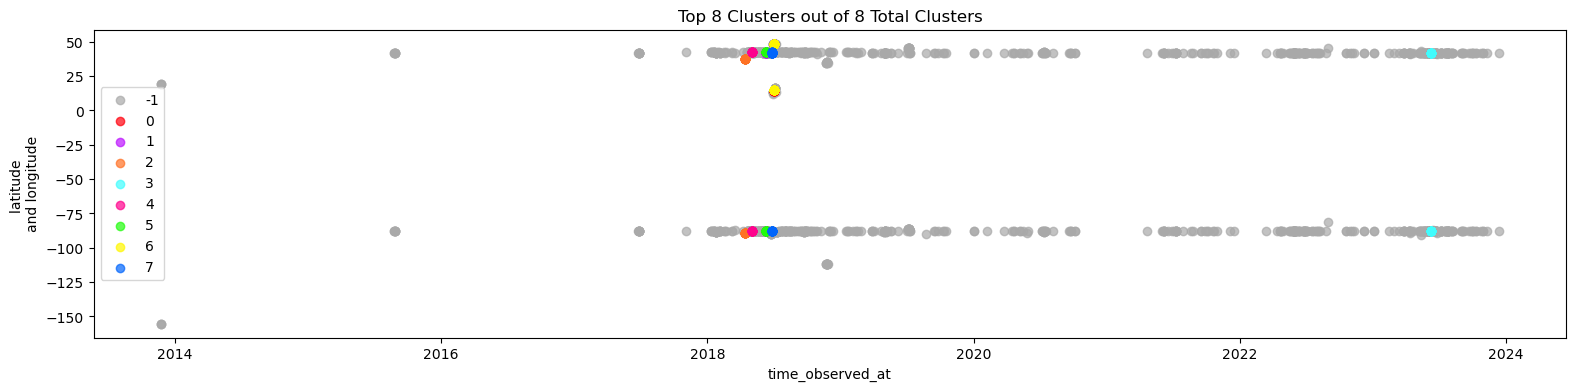

In [58]:
cluster_overview("Artif_Cluster", rand_user_df)

Cluster 6 shows up a little strangely here with two distinct groupings for longitude. Could be a geo-obscured point? 

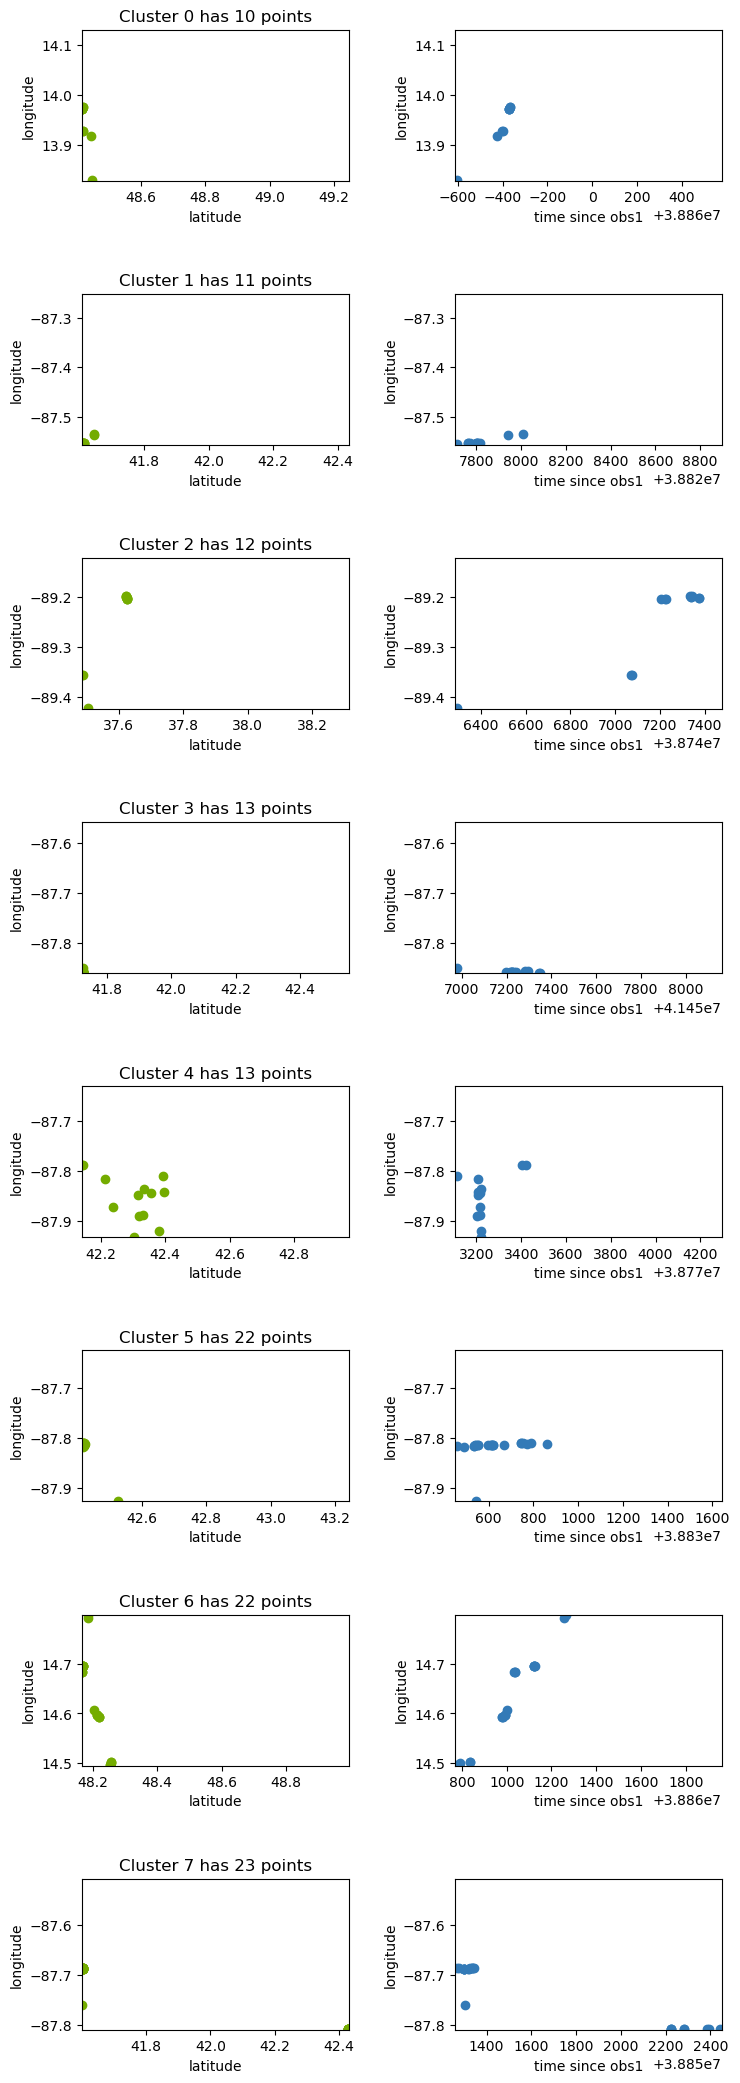

In [59]:
cluster_views("Artif_Cluster", rand_user_df)

Strangely, cluster 6 does not seem to show two distinct groupings here but it may be due more to the zoomed out lens of the cluster_overview? Rather cluster 2, 3 and 7 are the ones that seem to have patterns that wouldn't fall into "hike" for the entire set and could use some trimming (which hopefully DBSCAN will do). But we can check those hikes out on their own scales just to feel sure.

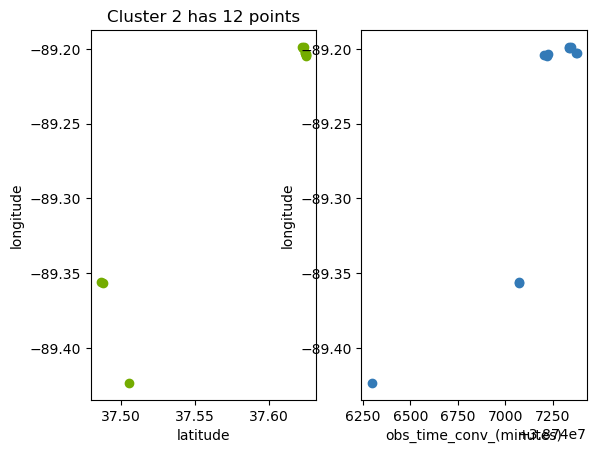

In [64]:
single_cluster("Artif_Cluster", rand_user_df, 2)

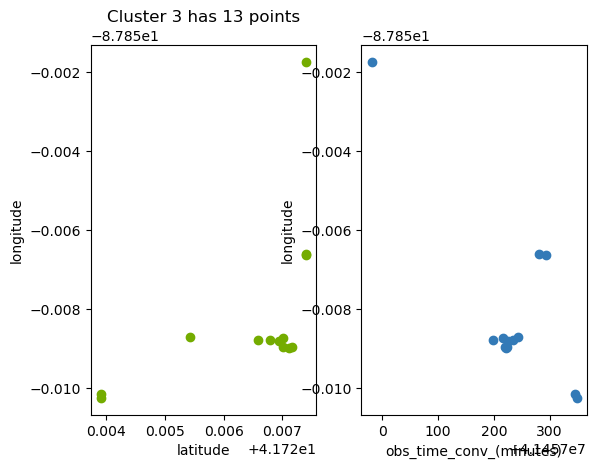

In [55]:
single_cluster("Artif_Cluster", rand_user_df, 3)

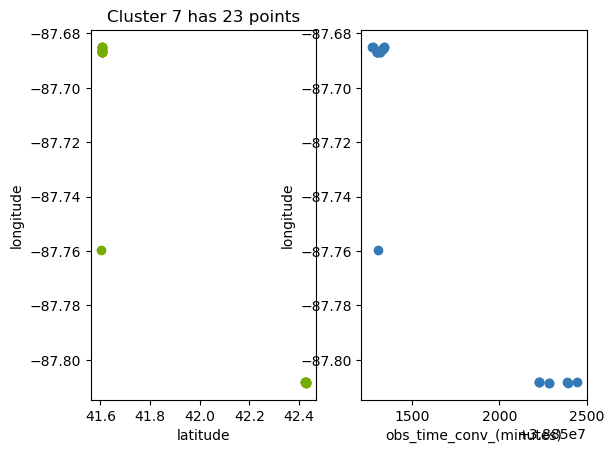

In [56]:
single_cluster("Artif_Cluster", rand_user_df, 7)

Yes, these are definitely examples of clusters that DO have "hike-like" behavior in some of the sections, but need trimming or separation into two different clusters. Hopefully DBSCAN might be able to catch some of these and be more discerning?

## Optimizing DBSCAN Model<a id = "5"></a>
### Creating metadataset to study feature and hyperparameter selection <a id = "6"></a>

### Feature Selection
Testing different sets of time- and distance- related features against each other. 

I'm creating a function df_feat_sel() for choosing a slice of the user-specific dataframe based on feature selections. This way I can put the function in an optimization loop. And before that, I'm defining the dictionary that df_feat_sel() will call on to make those slices but putting it in its own function which allows a user to also call on the feat_sel_param function to see what the feature codes mean.

In [67]:
# Part of a help function for df_feat_sel

def feat_sel_param(i):
    '''
    Takes an integer and returns the feature selection information.
    Meant to be used as part of 'help' for using the feat_sel function
    as a way of knowing what features each integer is associated with.
    
    Arguments:
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    Returns:
    Tuple with first element a string that acts as a descriptive title of the selected features
    and second element a list of the column headings for features chosen for that description
    
    '''
    # Creating the dictionary for feature selection
    # these can be edited here (added to, deleted or revised...) and rerun to see results for different feature selection
    feature_sel_options = {}

    feature_sel_options[0] = ("continuous_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)'])

    feature_sel_options[1] = ("continuous_light",
                              ['latitude','longitude', 
                               'km_diff','obs_time_conv_(minutes)'])

    feature_sel_options[2] = ("discrete_heavy",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year',
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[3] = ("discrete_light",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year'])

    # including this one to imitate the features I used for my own baseline model
    feature_sel_options[4] = ("discrete_barebones",
                              ['obs_month', 'obs_day', 'obs_year'])

    feature_sel_options[5] = ("combo_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year', 
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[6] = ("combo_light", 
                              ['latitude', 'longitude', 
                               'minute_diff', 'km_diff',  
                               'obs_month', 'obs_day', 'obs_year'])
    
    feature_sel_options[7] = ("combo_discrete_heavy",
                              ['latitude', 'longitude', 'minute_diff',
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year',
                               'created_year', 'created_month', 'created_day', 'created_hour'])
    
    
    # returns feature selection values if i is appropriate/exists as key
    # (also allowing user to also save and access the column lists without the df_feat_sel feature)
    if i in range(len(feature_sel_options)):
        return feature_sel_options[i]
    # but prints helpful info if i is not a dictionary key
    else:
        print(f'Input needs to be an integer between 0 and {len(feature_sel_options) - 1}')

num_feat_sel = 8 # CHANGE THIS IF YOU CHANGE NUMBER OF ITEMS IN DICTIONARY, THIS IS CALLED ON BY USER_SIL_SCORE_DF

In [68]:
def df_feat_sel(df, i):
    
    '''
    Takes a user-specific dataframe (df) and an integer mapped to a specific set of features
    and returns a dataframe for cluster analysis. 
    
    Arguments:
    df -- name of user-specific dataframe from the df_sp dataframe (after discrete time columns have been added)
    I'm choosing to leave this as needing specification anticipating that in the future I will change dataframe names
    as I change the user under consideration
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    For a reminder of what i maps to, use feat_sel_param() function
    
    Returns:
    Dataframe slice of original dataframe with only the columns chosen for feature selection
    
    '''
    
    # calls on the dictionary function and chooses the 2nd entry of the tuple for the column heading and then take the slice
    sel_df = df[feat_sel_param(i)[1]]
   

    return sel_df

### Meta data for Optimization

I created a user_sil_score_df function that runs DBSCAN with the different feature selection choices and a range of hyperparameters for epsilon and min_samples on one particular user and returns important meta data for comparison. <br>
<br>
I then ran a loop on all the users for df_sp_smaller and concatenated them for one large database to explore for performance of the DBSCAN models. <br>
<br>
The data dictionary is as follows: <br>
* user_id = user_id that corresponds to the user_id in df_sp_smaller (and df_sp and any iNaturalist database)
* feature_code = code for the feature selection used for performing DBSCAN. Use feat_sel_param to see the features that correspond to the code
* eps = epsilon chosen for that run of DBSCAN [(the radius of the circle to be created around each data point to check the density)](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/#:~:text=DBSCAN%20requires%20only%20two%20parameters,classified%20as%20a%20Core%20point)
*  min_sample = minimum number of data points required inside a cluster to be considered a cluster
* baseline_rel_silhouette = silhouette score for heuristic model relative to the feature selection
* db_rel_silhouett = silhouette score for dbscan model relative to the feature selection
* baseline_abs_silhouette = silhouette score for heuristic model relative to all numerical features in df_sp_smaller
* db_abs_silhouette = silhouette score for baseline model relative to all numberical features in df_sp_smaller
* num_db_clusters = number of clusters the dbscan model found for given parameters
* num_bl_clusters = number of clusters the heuristic model found given the same specification for min_sample

NOTE for FUTURE EDITS: it might have been valuable to also have a metric about average length of clusters found

In [69]:
def user_sil_score_df(user, df = df_sp_smaller):
    
    '''
    Takes the user id of a single user and a dataframe, performs DBSCAN on the user 
    for various feature selection and hyperparameter options and returns a dataframe 
    with metrics for evaluation of each model run. See data dictionary above for further description of metrics.
    
    Arguments:
    user = number inside "user_id" column for the dataframe that refers to specific user
    df = default is df_sp_smaller but could be given a different dataframe so long as the columns are the same as df_sp_smaller
    
    Returns:
    Dataframe of metrics for comparing DBSCAN models for the specified user
    '''
    
    # creates dataframe specific to user 
    # (rand in title is carry over from last notebook when the user was chosen randomly)
    # I am leaving it so as to be able to reuse the code without having to make lots of edits
    rand_user_df = df[df["user_id"] == user]
    rand_user_df.reset_index(inplace = True, drop = True)
    
    # need to identify potential_hikes for heuristic model
    potential_hikes = rand_user_df["time_observed_at"].dt.strftime('%D').value_counts()

    # choosing all columns with non boolean numeric columns 
    # to create a dataframe on which to compare "absolute" silhouette scores
    # from one cluster to the other
    absolute_columns = ['id', 'num_identification_agreements',
           'num_identification_disagreements', 'latitude',
           'longitude', 'positional_accuracy', 'public_positional_accuracy',
           'minute_diff', 'km_diff',
           'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 'obs_year',
           'obs_month', 'obs_day', 'obs_hour', 'created_year', 'created_month',
           'created_day', 'created_hour'] 

    absolute_df_for_scoring = rand_user_df[absolute_columns]

    #empty dataframe for analysis of silhouette scores
    sil_scores = pd.DataFrame()
    index = 0 # indexing unit for dataframe

    # i loops through the different feature selections
    for i in range(num_feat_sel): # THIS num_feat_sel IS DEFINED AT THE END OF THE CELL FOR FUNCTION feat_sel_param
        
        # create slice of dataframe for modeling with feature_code
        subset = df_feat_sel(rand_user_df, i) # calls on my df_feat_sel function

        # scale data --choosing MinMaxScaler to make it easier to guess at good values for DBSCAN eps
        mms = MinMaxScaler()
        subset_scaled = mms.fit_transform(subset)

        # looping through choices for eps and min_samples for DBSCAN
        for m in [10, 9, 8, 7, 6, 5]: # went down for reasons in earlier notebook, left it this way here   
            
            # creating baseline set given min_sample of m
            top_dates = potential_hikes[potential_hikes.values >= m].index

            artificial_cluster = {}
            n = 0
            for day in top_dates:
                artificial_cluster[day] = n
                n += 1
            artificial_cluster

            # repopulating "Artif_Cluster" column depending on the m for min_samples so sil scores can be properly compared
            for ind in range(rand_user_df.shape[0]):
                # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
                if rand_user_df.loc[ind, "time_observed_at"].strftime('%D') in top_dates:
                    rand_user_df.loc[ind, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[ind, "time_observed_at"].strftime('%D')]
                # otherwise, the new column will be assigned a -1 (the way DBSCAN does for non clusters)
                else:
                    rand_user_df.loc[ind, "Artif_Cluster"] = -1
            rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)

            # for silhouette score of artificial cluster, relative to chosen subset and min_samples
            if len(artificial_cluster) > 1: # sil score needs at least two groups
                non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
                artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
                baseline_relative = non_noise[subset.columns].to_numpy()
                baseline_rel_sil = silhouette_score(baseline_relative, artificial_cluster_array)
                baseline_absolute = non_noise[absolute_df_for_scoring.columns].to_numpy()
                baseline_abs_sil = silhouette_score(baseline_absolute, artificial_cluster_array)     
            else: 
                baseline_rel_sil = np.NaN
                baseline_abs_sil = np.NaN

            
            # looping through different epsilon values
            for e in [.001, .005, .01, .05, .1, .25]:

                #instantiate DBSCAN model
                dbscan_model = DBSCAN(eps=e, min_samples=m)
                # Fit and get labels
                cluster_labels = dbscan_model.fit_predict(subset_scaled)
                num_clusters = len(np.unique(cluster_labels)) - 1 # subtract one for noise


                # silhouette scores for db
                if num_clusters > 1: # silhouette scores require at least two groups to analyze 
                    # silhouette score relative to the subset columns
                    db_rel_sil = silhouette_score(subset[cluster_labels != -1], cluster_labels[cluster_labels != -1])
                    # silhouette score relative to the "absolute" dataset created at top of cell
                    db_abs_sil = silhouette_score(absolute_df_for_scoring[cluster_labels != -1], cluster_labels[cluster_labels != -1])
                else: 
                    db_rel_sil = np.NaN
                    db_abs_sil = np.NaN



                # store info in analysis dataframe
                sil_scores.loc[index, "user_id"] = user
                sil_scores.loc[index, "feature_code"] = i
                sil_scores.loc[index, "eps"] = e
                sil_scores.loc[index, "min_samples"] = m
                sil_scores.loc[index, "baseline_rel_silhouette"] = baseline_rel_sil
                sil_scores.loc[index, "db_rel_silhouette"] = db_rel_sil
                sil_scores.loc[index, "baseline_abs_silhouette"] = baseline_abs_sil
                sil_scores.loc[index, "db_abs_silhouette"] = db_abs_sil
                sil_scores.loc[index, "num_db_clusters"] = num_clusters
                sil_scores.loc[index, "num_bl_clusters"] = len(artificial_cluster)
                index += 1
                
    return sil_scores

In [30]:
# Code below used to create large meta dataframe for study of optimization of ALL users in df_sp_smaller
# commented out now because it takes too long--the csv is available

# user_list = df_sp_smaller["user_id"].unique()
# sil_scores_df = user_sil_score_df(user_list[0])
# for id in user_list[1:]:
#     user_sil_scores = user_sil_score_df(id)
#     sil_scores_df = pd.concat([sil_scores_df, user_sil_scores], axis = 0, ignore_index = True)
# sil_scores_df.to_csv("../../data/sil_scores_df.csv")
# sil_scores_df

### EDA on metadata for optimization <a id = "7"></a>

_Note for visualizations:_ <br>
Sometimes the legend is awkward and too bulky for the visualizations but in general: <br>
* Green is for Heuristic data
* Blue is for DBSCAN data
* Lines represent medians
<br>
<br>

Later in the visualizations: <br>
* Purple is for the final model I chose

In [85]:
# read in the saved file
sil_scores_df = pd.read_csv("../../data/sil_scores_df.csv")

In [86]:
# drop duplicate index column
sil_scores_df.drop(["Unnamed: 0"], axis = 1, inplace = True)

__NaN values__

In [87]:
# What percent of the set had NaN values?
sil_scores_df["baseline_rel_silhouette"].isna().sum() / sil_scores_df.shape[0]

0.18666666666666668

In [88]:
# How many users had NaN baseline values?
user_nan = sil_scores_df[sil_scores_df["baseline_rel_silhouette"].isna()]["user_id"].unique()
len(user_nan)

60

60 of the 225 users have NaN values for baseline silhouette

In [89]:
# If a user had NaN values, did they also have non NaN values? How many fit this description?
nan_mix = sil_scores_df[(sil_scores_df["user_id"].isin(user_nan)) & (sil_scores_df["baseline_rel_silhouette"].notna())]
nan_mix["user_id"].nunique()

38

SO only 22 of those 60 had NO baseline silhouette scores.

In [90]:
# What users had NaN DBSCAN values?
user_db_nan = sil_scores_df[sil_scores_df["db_rel_silhouette"].isna()]["user_id"].unique()
len(user_db_nan)

193

In [91]:
# If a user had NaN values for DB, did they also have non NaN values?
nan_db_mix = sil_scores_df[(sil_scores_df["user_id"].isin(user_db_nan)) & (sil_scores_df["db_rel_silhouette"].notna())]
nan_db_mix["user_id"].nunique()

188

So in general, DBSCAN shows itself to be more discriminating (for 193 users some version of DBSCAN found 0 or only 1 cluster) but also more capable of finding clusters under some parameters than the non ML version (possibly due to the shortcut around not converting timezones or because some people take two hikes on one day) because there were only 5 users for whom some version of DBSCAN could not find anything. 

__Range of Scores__

I just want to compare overall shape so kde works well for me

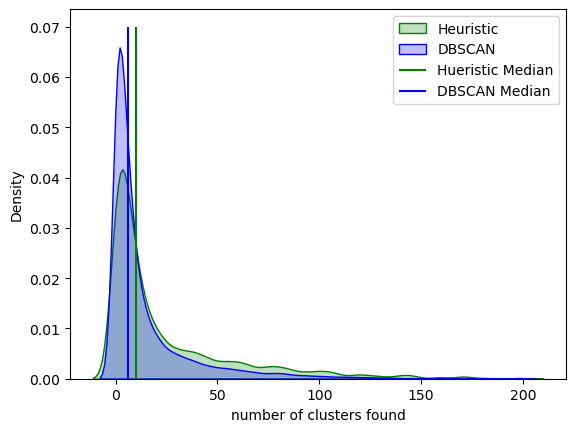

In [148]:
# comparing how many clusters were found by each approach 

plt.figure()
sns.kdeplot(sil_scores_df["num_bl_clusters"], color = "green", common_norm = False, fill = True, label = "Heuristic")
sns.kdeplot(sil_scores_df["num_db_clusters"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
plt.vlines(sil_scores_df["num_bl_clusters"].median(), 0, .07, color = "green", label = "Hueristic Median")
plt.vlines(sil_scores_df["num_db_clusters"].median(), 0, .07, color = "blue", label = "DBSCAN Median")
plt.xlabel("number of clusters found")
plt.legend(loc = "upper right")
plt.show()

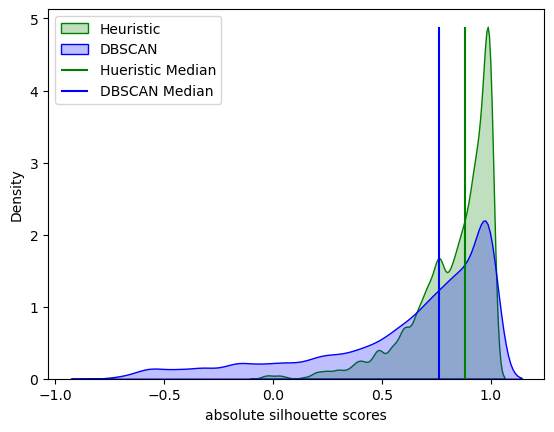

In [149]:
# comparing the range of "absolute" silhouette scores for heuristic and dbscan

# because I'm using kde AND plotting vertical lines as median lines, I need to know the max y-value kde is going to plot
# # the code below retrieves the data for that
# 

plt.figure()
sns.kdeplot(sil_scores_df["baseline_abs_silhouette"], color = "green", common_norm = False, fill = True, label = "Heuristic")
sns.kdeplot(sil_scores_df["db_abs_silhouette"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
plt.vlines(sil_scores_df["baseline_abs_silhouette"].median(), 0, max_y, color = "green", label = "Hueristic Median")
plt.vlines(sil_scores_df["db_abs_silhouette"].median(), 0, max_y, color = "blue", label = "DBSCAN Median")
plt.xlabel("absolute silhouette scores")
plt.legend(loc = "upper left")
plt.show()

For legend, see above graphs


C:\Users\lisa_\AppData\Local\Temp\ipykernel_27584\3807814330.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(feat_code_df["baseline_rel_silhouette"], color = "green", common_norm = False, fill = True, label = "Heuristic")


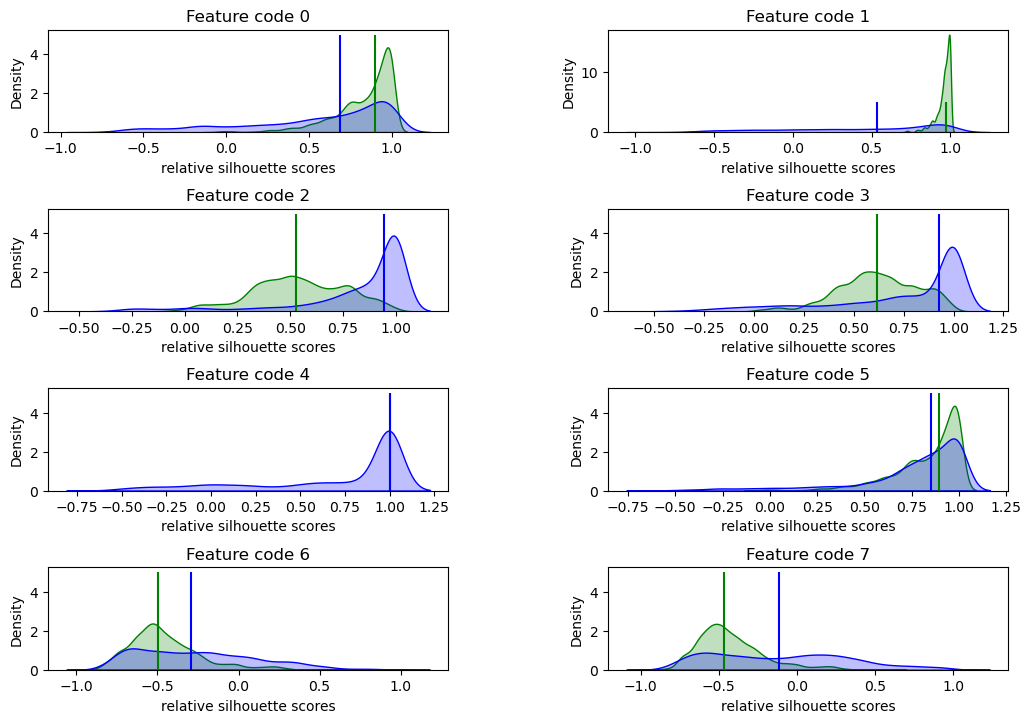

In [153]:
# For relative silhouette scores, it doesn't even make sense to look at them all together, 
# so I'm graphing them separately based on each feature code

print("For legend, see above graphs")

if num_feat_sel%2 == 0:
    num_plots = int(num_feat_sel / 2)
else:
    num_plots = (num_feat_sel + 1) / 2

plt.subplots(num_plots, 2, figsize = (12, 8))
plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)
for i in range(num_feat_sel):
    plt.subplot(num_plots, 2, i + 1)
    feat_code_df = sil_scores_df[sil_scores_df["feature_code"] == i]
    sns.kdeplot(feat_code_df["baseline_rel_silhouette"], color = "green", common_norm = False, fill = True, label = "Heuristic")
    sns.kdeplot(feat_code_df["db_rel_silhouette"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
    plt.xlabel("relative silhouette scores")
    plt.vlines(feat_code_df["baseline_rel_silhouette"].median(), 0, 5, color = "green", label = "Hueristic Median")
    plt.vlines(feat_code_df["db_rel_silhouette"].median(), 0, 5, color = "blue", label = "DBSCAN Median")
    plt.title(f"Feature code {i}")
plt.show()

#NOTE: to get the vlines to choose a height relative to the window is above my understanding of the code right now
# and not a priority as these visualizations do enough for me, ChatGPT has several solutions but I find
# them annoying and a little beyond what is making sense to me--noted for further study

From this viewpoint Feature code 2 and 3 are looking pretty good (feature code 4 is discussed further down in the notebook and is mostly included as an approximation for how the heuristic behaves) although I'm noting feature code 5 because it does a pretty good job of "getting close" to the heuristic

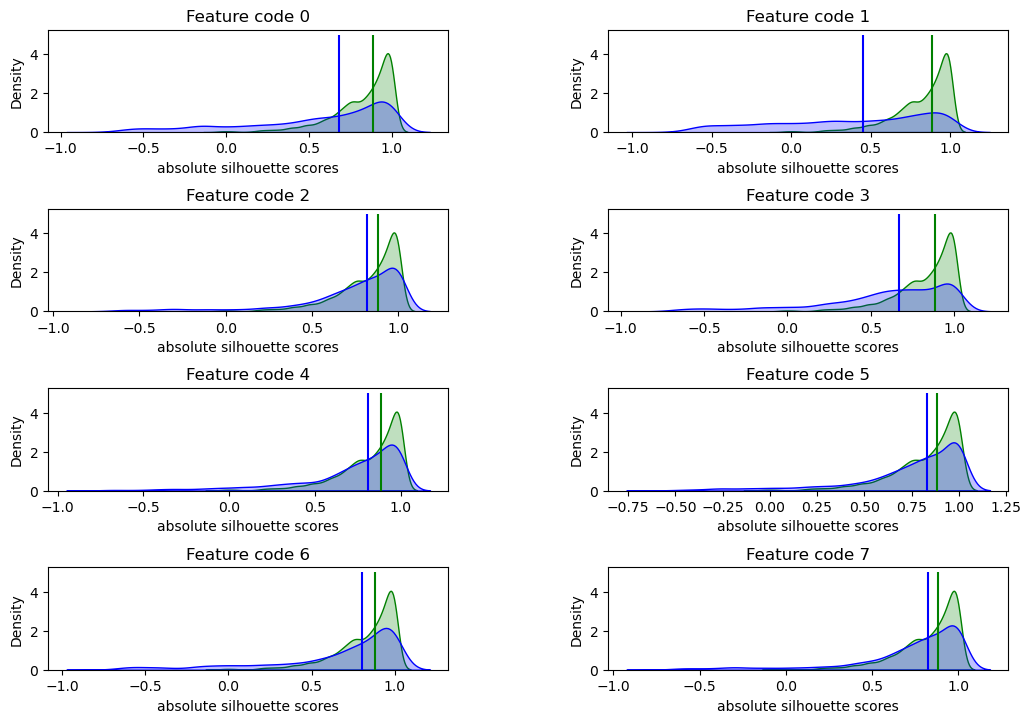

In [154]:
# That visualization was so useful I want to see it again for the absolute scores and the number of clusters

if num_feat_sel % 2 == 0:
    num_plots = int(num_feat_sel / 2)
else:
    num_plots = (num_feat_sel + 1) / 2

plt.subplots(num_plots, 2, figsize = (12, 8))
plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)
for i in range(num_feat_sel):
    plt.subplot(num_plots, 2, i + 1)
    feat_code_df = sil_scores_df[sil_scores_df["feature_code"] == i]
    sns.kdeplot(feat_code_df["baseline_abs_silhouette"], color = "green", common_norm = False, fill = True, label = "Heuristic")
    sns.kdeplot(feat_code_df["db_abs_silhouette"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
    plt.xlabel("absolute silhouette scores")
    plt.vlines(feat_code_df["baseline_abs_silhouette"].median(), 0, 5, color = "green", label = "Hueristic Median")
    plt.vlines(feat_code_df["db_abs_silhouette"].median(), 0, 5, color = "blue", label = "DBSCAN Median")
    plt.title(f"Feature code {i}")
plt.show()

On the absolute scores, the heuristic does overall better every time but now feature codes 2, 5, and 7 are the ones who seem to be the closest. Taking that information together, 2 and 5 seem to be at the top for consideration.

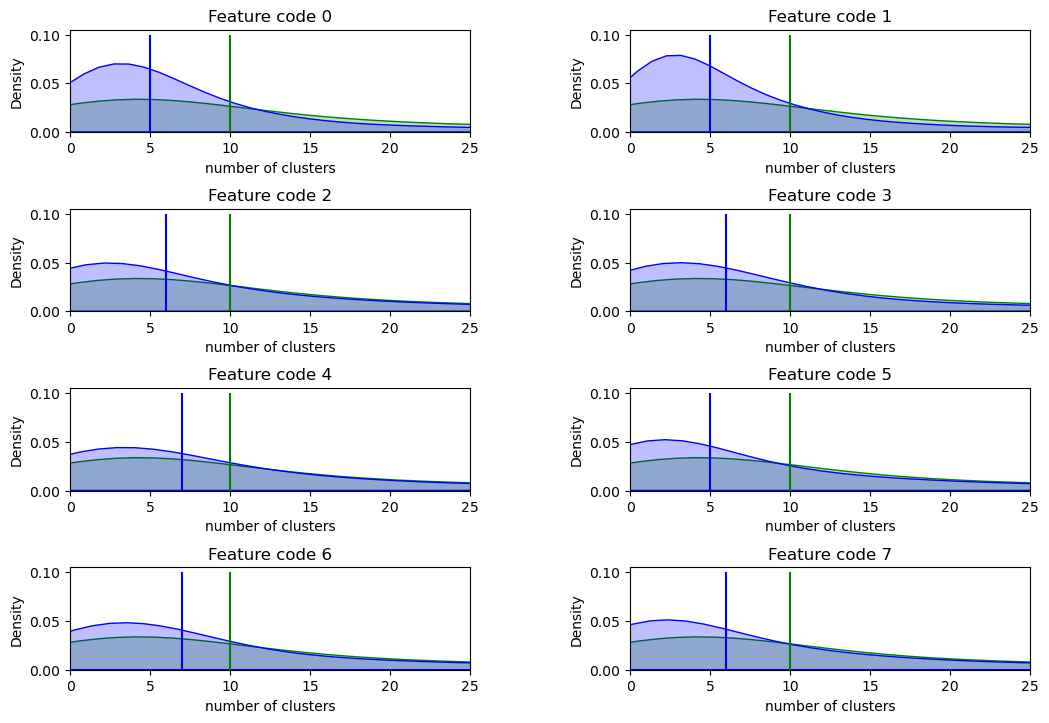

In [159]:
# Now for number of clusters by feature code

if num_feat_sel % 2 == 0:
    num_plots = int(num_feat_sel / 2)
else:
    num_plots = (num_feat_sel + 1) / 2

plt.subplots(num_plots, 2, figsize = (12, 8))
plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)
for i in range(num_feat_sel):
    plt.subplot(num_plots, 2, i + 1)
    feat_code_df = sil_scores_df[sil_scores_df["feature_code"] == i]
    sns.kdeplot(feat_code_df["num_bl_clusters"], color = "green", common_norm = False, fill = True, label = "Heuristic")
    sns.kdeplot(feat_code_df["num_db_clusters"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
    plt.xlabel("number of clusters")
    plt.vlines(feat_code_df["num_bl_clusters"].median(), 0, .1, color = "green", label = "Hueristic Median")
    plt.vlines(feat_code_df["num_db_clusters"].median(), 0, .1, color = "blue", label = "DBSCAN Median")
    plt.title(f"Feature code {i}")
    plt.xlim(0,25) # only showing up to 25 clusters to get a better comparison of what's going on at/near the mode
plt.show()

Not a lot of difference here. Feature codes 0, 1 and 5 seem to be more "discerning", feature code 4 and 6 are more likely to include more clusters than the others.

My intuition is that feature code is the most important thing to optimize. Intuition is that a lower epsilon and higher min_sample will simply fine-tune the model to be MORE discerning or go in the other direction to capture MORE likely hikes. I should problably have written this visualization code into a function but for now, it is more time efficient for me to copy/paste and modify to do a quick look to confirm my intuition (which it does--epsilon behaves in a predictable way and min_samples doesn't do a whole lot to the DBSCAN model--just limits the heuristic model.). 

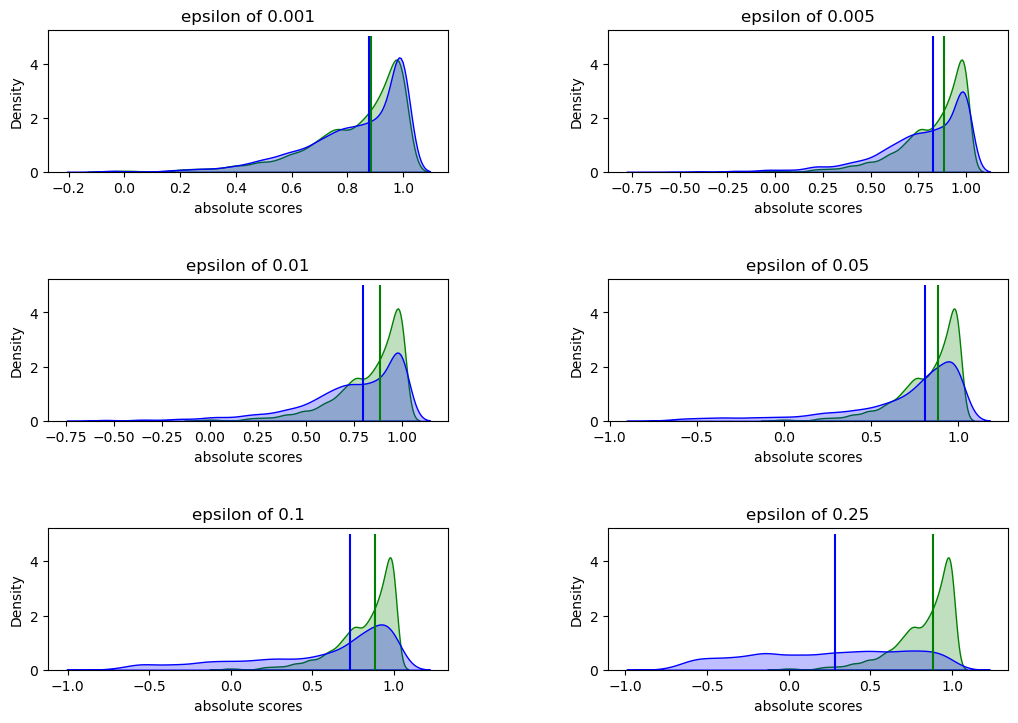

In [173]:
# Quick look at how epsilon value changes things

plt.subplots(3, 2, figsize = (12, 8))
plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)
i = 0
for eps in sil_scores_df["eps"].unique():
    plt.subplot(3, 2, i + 1)
    eps_df = sil_scores_df[sil_scores_df["eps"] == eps]
    sns.kdeplot(eps_df["baseline_abs_silhouette"], color = "green", common_norm = False, fill = True, label = "Heuristic")
    sns.kdeplot(eps_df["db_abs_silhouette"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
    plt.xlabel("absolute scores")
    plt.vlines(eps_df["baseline_abs_silhouette"].median(), 0, 5, color = "green", label = "Hueristic Median")
    plt.vlines(eps_df["db_abs_silhouette"].median(), 0, 5, color = "blue", label = "DBSCAN Median")
    plt.title(f"epsilon of {eps}")
    i += 1
plt.show()

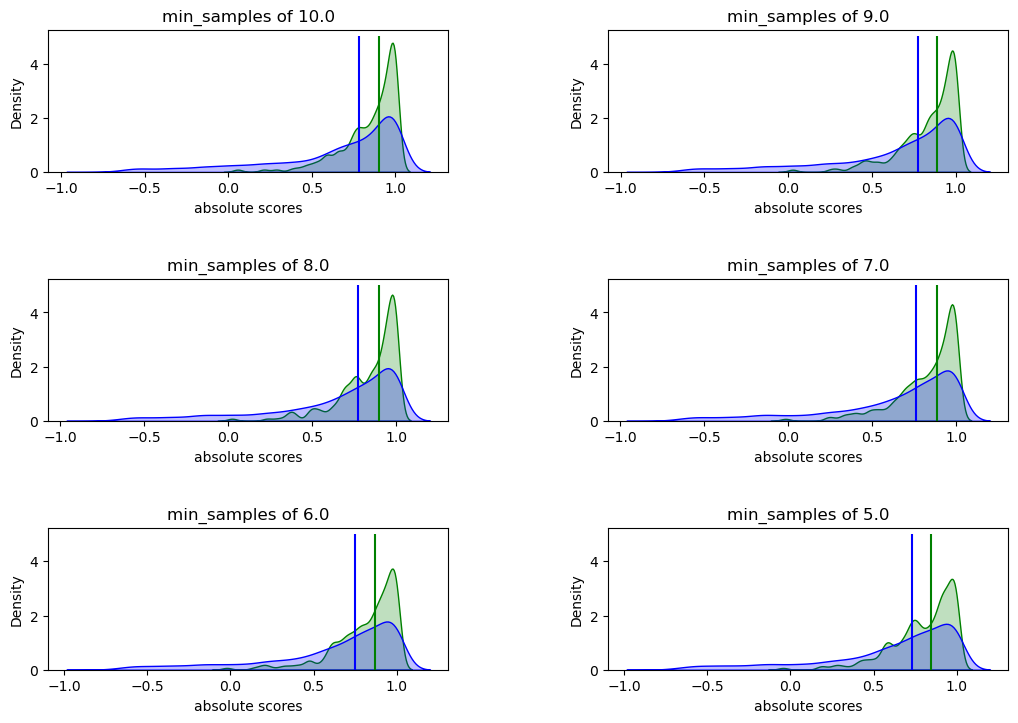

In [171]:
# Quick look at how min_sample choice changes things

plt.subplots(3, 2, figsize = (12, 8))
plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)
i = 0
for min_s in sil_scores_df["min_samples"].unique():
    plt.subplot(3, 2, i + 1)
    min_df = sil_scores_df[sil_scores_df["min_samples"] == min_s]
    sns.kdeplot(min_df["baseline_abs_silhouette"], color = "green", common_norm = False, fill = True, label = "Heuristic")
    sns.kdeplot(min_df["db_abs_silhouette"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
    plt.xlabel("absolute scores")
    plt.vlines(min_df["baseline_abs_silhouette"].median(), 0, 5, color = "green", label = "Hueristic Median")
    plt.vlines(min_df["db_abs_silhouette"].median(), 0, 5, color = "blue", label = "DBSCAN Median")
    plt.title(f"min_samples of {min_s}")
    i += 1
plt.show()

__What are the features for the "BEST" scores?__

In [174]:
# What are the parameters for the 500 best absolute DBSCAN scores?

top_abs_db = sil_scores_df[sil_scores_df["db_abs_silhouette"].notna()].sort_values(by = "db_abs_silhouette").tail(500)
top_abs_db.describe()


user_id  feature_code         eps  min_samples  \
count  5.000000e+02    500.000000  500.000000   500.000000   
mean   1.801163e+06      4.558000    0.012846     7.514000   
std    1.182084e+06      2.159621    0.021747     1.833173   
min    1.843400e+04      0.000000    0.001000     5.000000   
25%    8.949570e+05      2.000000    0.001000     6.000000   
50%    1.773265e+06      5.000000    0.005000     8.000000   
75%    2.570804e+06      7.000000    0.010000     9.000000   
max    5.814233e+06      7.000000    0.100000    10.000000   

       baseline_rel_silhouette  db_rel_silhouette  baseline_abs_silhouette  \
count               500.000000         500.000000               500.000000   
mean                  0.393697           0.852912                 0.902090   
std                   0.622679           0.277868                 0.124812   
min                  -0.721500          -0.142161                 0.477116   
25%                  -0.365343           0.855258                 0.838582   
50%                   0.715735           0.999935                 0.964504   
75%                   0.958917           0.999984                 0.998918   
max                   1.000000           1.000000                 0.999979   

       db_abs_silhouette  num_db_clusters  num_bl_clusters  
count         500.000000       500.000000       500.000000  
mean            0.999980         2.292000        10.934000  
std             0.000010         0.729246        12.077972  
min             0.999961         2.000000         2.000000  
25%             0.999971         2.000000         4.000000  
50%             0.999981         2.000000         6.000000  
75%             0.999989         2.000000        12.500000  
max             0.999999        10.000000        76.000000

If I filter by the top 500 highest absolute silhouette score, the number of db clusters is very small--75% or more of these models only identify 2 clusters with 10 as a max number of clusters even though the range found in the non ML model goes from 2 to 76 potential hikes. This suggests that using the db_abs_silhouette as the primary measure leads to models that are too discriminating. 

In [175]:
# what feature selection options produced these very strict models?
top_abs_db["feature_code"].value_counts()

5.0    154
7.0    140
2.0     90
3.0     40
6.0     34
0.0     26
1.0     13
4.0      3
Name: feature_code, dtype: int64

I already know based on my case study that if I filter by top dbscan rel score it will show feature selection 4 as the best model--this is the feature selection that imitates the heuristic model and it does very well on its own terms, but also mostly reproduces the heuristic conditions. This goes to show that the rel_db_silhouette score on its own is not the best measure for finding a good dbscan model (although it MAY be evidence that the heuristic model is a better direction to take lol). I will run the code below to demonstrate:

In [176]:
# What are the parameters for the best relative DBSCAN scores?

top_rel_db = sil_scores_df[sil_scores_df["db_rel_silhouette"].notna()].sort_values(by = "db_rel_silhouette").tail(500)
top_rel_db.describe()

user_id  feature_code         eps  min_samples  \
count  5.000000e+02         500.0  500.000000   500.000000   
mean   2.214182e+06           4.0    0.005414     7.336000   
std    1.627269e+06           0.0    0.004190     1.711421   
min    3.076100e+05           4.0    0.001000     5.000000   
25%    8.799800e+05           4.0    0.001000     6.000000   
50%    9.778880e+05           4.0    0.005000     7.000000   
75%    3.229159e+06           4.0    0.010000     9.000000   
max    5.445479e+06           4.0    0.050000    10.000000   

       baseline_rel_silhouette  db_rel_silhouette  baseline_abs_silhouette  \
count                    500.0              500.0               500.000000   
mean                       1.0                1.0                 0.830635   
std                        0.0                0.0                 0.185655   
min                        1.0                1.0                 0.235260   
25%                        1.0                1.0                 0.746454   
50%                        1.0                1.0                 0.902148   
75%                        1.0                1.0                 0.964632   
max                        1.0                1.0                 0.998286   

       db_abs_silhouette  num_db_clusters  num_bl_clusters  
count         500.000000       500.000000       500.000000  
mean            0.830635        28.242000        28.242000  
std             0.185655        32.140652        32.140652  
min             0.235260         2.000000         2.000000  
25%             0.746454         6.000000         6.000000  
50%             0.902148        13.000000        13.000000  
75%             0.964632        43.000000        43.000000  
max             0.998286       173.000000       173.000000

I don't even need to do a value counts because the feature_code spread shows "4.0" at all values from min to max. Note that the distribution comparisons between "baseline" and "db" are the same at every measure.

A combo of measures might help find a sweet spot: I want to see models where db_rel_sil is HIGHER than baseline_rel_sil (which will exclude these 4.0 models) and then maybe eventually choose a threshold for db_abs_sil so that it still holds a certain standard but not too strictly. I will be looking at how the baseline number of clusters compare to the DBSCAN clusters--DBSCAN can and should sometimes have fewer, but not significantly fewer. 

In [177]:
# What are the parameters for the those relative DBSCAN scores that are higher than the baseline relative scores?

better_rel_db = sil_scores_df[sil_scores_df["db_rel_silhouette"] > sil_scores_df["baseline_rel_silhouette"]].sort_values(by = "db_rel_silhouette").tail(500)
better_rel_db.describe()

user_id  feature_code         eps  min_samples  \
count  5.000000e+02    500.000000  500.000000   500.000000   
mean   2.414887e+06      3.296000    0.009528     7.640000   
std    1.487920e+06      1.687032    0.017175     1.739094   
min    1.843400e+04      0.000000    0.001000     5.000000   
25%    1.234210e+06      2.000000    0.001000     6.000000   
50%    2.170071e+06      3.000000    0.005000     8.000000   
75%    3.130064e+06      5.000000    0.010000     9.000000   
max    5.814233e+06      5.000000    0.100000    10.000000   

       baseline_rel_silhouette  db_rel_silhouette  baseline_abs_silhouette  \
count               500.000000         500.000000               500.000000   
mean                  0.778076           0.999977                 0.870818   
std                   0.230667           0.000014                 0.155236   
min                   0.009480           0.999951                 0.256412   
25%                   0.628516           0.999966                 0.772491   
50%                   0.874594           0.999979                 0.942522   
75%                   0.980862           0.999989                 0.997086   
max                   0.999980           0.999999                 0.999979   

       db_abs_silhouette  num_db_clusters  num_bl_clusters  
count         500.000000       500.000000       500.000000  
mean            0.997449         2.658000        11.892000  
std             0.011543         1.562664        14.118321  
min             0.869767         2.000000         2.000000  
25%             0.999741         2.000000         4.000000  
50%             0.999955         2.000000         8.000000  
75%             0.999981         3.000000        13.000000  
max             0.999999        22.000000       108.000000

There's a little more wiggle room here--the DBSCAN clusters go up to 3 clusters by the 75% percentile and up to 22 total. And it looks like we might not really have to filter with a threshold for good absolute sil score because the range of these are pretty good--most .999 or above and lowest at .869, so this lens helps us loosen up the strictness of the DBSCAN a little without giving too much on the absolute silhouette.

For the Goldilocks version, I wonder if it would be fruitful to set a standard for a) "be more rigorous than the baseline but not TOO much more rigorous" as a percent increase  AND b) setting a threshold (by percent) for how much the DBSCAN reduces the number of clusters from the baseline

In [178]:
# dropping 4.0 from model consideration

sil_scores_df = sil_scores_df[sil_scores_df["feature_code"] != 4.0]

In [179]:
# What are is the description of DBSCAN models that have at least half of the number of the baseline clusters?
notnull = sil_scores_df["db_rel_silhouette"].notna()
not_too_strict = sil_scores_df["num_db_clusters"] >= sil_scores_df["num_bl_clusters"]*0.5

sil_scores_df[notnull & not_too_strict].describe()

user_id  feature_code           eps   min_samples  \
count  2.997600e+04  29976.000000  29976.000000  29976.000000   
mean   2.165183e+06      3.460535      0.069697      7.375934   
std    1.609451e+06      2.440192      0.083397      1.709207   
min    1.843400e+04      0.000000      0.001000      5.000000   
25%    8.452090e+05      1.000000      0.005000      6.000000   
50%    1.804605e+06      3.000000      0.050000      7.000000   
75%    3.140204e+06      6.000000      0.100000      9.000000   
max    6.917800e+06      7.000000      0.250000     10.000000   

       baseline_rel_silhouette  db_rel_silhouette  baseline_abs_silhouette  \
count             28444.000000       29976.000000             28444.000000   
mean                  0.384617           0.444279                 0.835053   
std                   0.604430           0.543295                 0.176687   
min                  -0.847446          -0.858666                -0.044124   
25%                  -0.291625           0.023891                 0.750015   
50%                   0.622577           0.654474                 0.893438   
75%                   0.919686           0.919612                 0.970719   
max                   0.999992           0.999997                 0.999979   

       db_abs_silhouette  num_db_clusters  num_bl_clusters  
count       29976.000000     29976.000000     29976.000000  
mean            0.687040        22.323492        26.951962  
std             0.303797        27.767131        33.910991  
min            -0.691768         2.000000         0.000000  
25%             0.543936         5.000000         5.000000  
50%             0.770220        10.000000        12.000000  
75%             0.926925        28.000000        37.000000  
max             0.999997       199.000000       199.000000

In [181]:
sil_scores_df[notnull & not_too_strict].sort_values(by="db_rel_silhouette").tail(20)

user_id  feature_code    eps  min_samples  baseline_rel_silhouette  \
57919  4787148.0           0.0  0.005          5.0                 0.838590   
57920  4787148.0           0.0  0.010          5.0                 0.838590   
57918  4787148.0           0.0  0.001          5.0                 0.838590   
5655    428492.0           5.0  0.050         10.0                 0.999980   
39080  2570804.0           5.0  0.010          7.0                 0.999745   
39079  2570804.0           5.0  0.005          7.0                 0.999745   
39081  2570804.0           5.0  0.050          7.0                 0.999745   
38976  2570804.0           2.0  0.001          6.0                 0.896704   
38982  2570804.0           2.0  0.001          5.0                 0.909360   
14893   894957.0           5.0  0.005          6.0                 0.997086   
14894   894957.0           5.0  0.010          6.0                 0.997086   
14892   894957.0           5.0  0.001          6.0                 0.997086   
38940  2570804.0           1.0  0.001          6.0                 0.999846   
38946  2570804.0           1.0  0.001          5.0                 0.999839   
41538  2718421.0           1.0  0.001          5.0                 0.993852   
41502  2718421.0           0.0  0.001          5.0                 0.995394   
18498  1038812.0           1.0  0.001          5.0                 0.998131   
18492  1038812.0           1.0  0.001          6.0                 0.997934   
39084  2570804.0           5.0  0.001          6.0                 0.999745   
39090  2570804.0           5.0  0.001          5.0                 0.999511   

       db_rel_silhouette  baseline_abs_silhouette  db_abs_silhouette  \
57919           0.999991                 0.838582           0.999991   
57920           0.999991                 0.838582           0.999991   
57918           0.999991                 0.838582           0.999991   
5655            0.999992                 0.999979           0.999992   
39080           0.999992                 0.999736           0.999986   
39079           0.999992                 0.999736           0.999986   
39081           0.999992                 0.999736           0.999986   
38976           0.999993                 0.999736           0.999933   
38982           0.999993                 0.999477           0.999933   
14893           0.999994                 0.997086           0.999994   
14894           0.999994                 0.997086           0.999994   
14892           0.999994                 0.997086           0.999994   
38940           0.999994                 0.999736           0.999987   
38946           0.999994                 0.999477           0.999987   
41538           0.999995                 0.995265           0.999996   
41502           0.999996                 0.995265           0.999996   
18498           0.999996                 0.966462           0.999897   
18492           0.999996                 0.961579           0.999897   
39084           0.999997                 0.999736           0.999997   
39090           0.999997                 0.999477           0.999997   

       num_db_clusters  num_bl_clusters  
57919              2.0              3.0  
57920              2.0              3.0  
57918              2.0              3.0  
5655               2.0              2.0  
39080              2.0              3.0  
39079              2.0              3.0  
39081              2.0              3.0  
38976              2.0              3.0  
38982              2.0              4.0  
14893              2.0              4.0  
14894              2.0              4.0  
14892              2.0              4.0  
38940              2.0              3.0  
38946              2.0              4.0  
41538              2.0              4.0  
41502              2.0              4.0  
18498              2.0              4.0  
18492              2.0              3.0  
39084              2.0              3.

But if we look at the best scores for this situation, it's still all the small end of clusters--only 2 found by DBSCAN--so this way of approaching it is just filtering for users with a small number of potential hikes. How does it look for those users with more? To make it "not too strict" we need to know it won't cut 20 potential hikes down to 2 hikes on the regular.

In [182]:
more_potential_hikes = sil_scores_df["num_bl_clusters"] > 10
sil_scores_df[notnull & not_too_strict & more_potential_hikes].describe()

user_id  feature_code           eps   min_samples  \
count  1.582400e+04  15824.000000  15824.000000  15824.000000   
mean   2.087122e+06      3.715495      0.054104      7.109644   
std    1.723972e+06      2.378291      0.070940      1.689228   
min    1.843400e+04      0.000000      0.001000      5.000000   
25%    6.350410e+05      2.000000      0.005000      6.000000   
50%    1.576744e+06      3.000000      0.010000      7.000000   
75%    3.130064e+06      6.000000      0.100000      9.000000   
max    6.094378e+06      7.000000      0.250000     10.000000   

       baseline_rel_silhouette  db_rel_silhouette  baseline_abs_silhouette  \
count             15824.000000       15824.000000             15824.000000   
mean                  0.276360           0.375507                 0.780592   
std                   0.614337           0.580131                 0.182047   
min                  -0.847446          -0.857261                -0.044124   
25%                  -0.461740          -0.134751                 0.699175   
50%                   0.515046           0.598743                 0.815624   
75%                   0.812027           0.881811                 0.922916   
max                   0.999039           0.999948                 0.998572   

       db_abs_silhouette  num_db_clusters  num_bl_clusters  
count       15824.000000     15824.000000     15824.000000  
mean            0.655608        37.385490        46.453109  
std             0.295291        31.158737        36.960854  
min            -0.691768         6.000000        11.000000  
25%             0.528729        14.000000        17.000000  
50%             0.739062        27.000000        35.000000  
75%             0.869016        51.000000        64.000000  
max             0.999748       199.000000       199.000000

In [183]:
sil_scores_df[notnull & not_too_strict & more_potential_hikes].sort_values(by="db_rel_silhouette").tail(20)

user_id  feature_code    eps  min_samples  baseline_rel_silhouette  \
8748    553407.0           3.0  0.001         10.0                 0.628233   
8755    553407.0           3.0  0.005          9.0                 0.601181   
8754    553407.0           3.0  0.001          9.0                 0.601181   
58278  4805499.0           2.0  0.001          5.0                 0.685951   
8730    553407.0           2.0  0.001          7.0                 0.543687   
8731    553407.0           2.0  0.005          7.0                 0.543687   
8724    553407.0           2.0  0.001          8.0                 0.545505   
8725    553407.0           2.0  0.005          8.0                 0.545505   
8736    553407.0           2.0  0.001          6.0                 0.510666   
8737    553407.0           2.0  0.005          6.0                 0.510666   
1292    119175.0           3.0  0.010          5.0                 0.697465   
1291    119175.0           3.0  0.005          5.0                 0.697465   
1290    119175.0           3.0  0.001          5.0                 0.697465   
8712    553407.0           2.0  0.001         10.0                 0.606941   
8713    553407.0           2.0  0.005         10.0                 0.606941   
8718    553407.0           2.0  0.001          9.0                 0.575375   
8719    553407.0           2.0  0.005          9.0                 0.575375   
1254    119175.0           2.0  0.001          5.0                 0.697479   
1256    119175.0           2.0  0.010          5.0                 0.697479   
1255    119175.0           2.0  0.005          5.0                 0.697479   

       db_rel_silhouette  baseline_abs_silhouette  db_abs_silhouette  \
8748            0.999909                 0.866217           0.773904   
8755            0.999911                 0.840831           0.780863   
8754            0.999911                 0.840831           0.780863   
58278           0.999917                 0.951927           0.997855   
8730            0.999917                 0.851029           0.749762   
8731            0.999917                 0.851029           0.749762   
8724            0.999918                 0.850738           0.759641   
8725            0.999918                 0.850738           0.759641   
8736            0.999919                 0.841249           0.726277   
8737            0.999919                 0.841249           0.726277   
1292            0.999927                 0.974371           0.993117   
1291            0.999927                 0.974371           0.993117   
1290            0.999927                 0.974371           0.993117   
8712            0.999936                 0.866217           0.768005   
8713            0.999936                 0.866217           0.768005   
8718            0.999938                 0.840831           0.775533   
8719            0.999938                 0.840831           0.775533   
1254            0.999948                 0.974371           0.993117   
1256            0.999948                 0.974371           0.993117   
1255            0.999948                 0.974371           0.993117   

       num_db_clusters  num_bl_clusters  
8748              18.0             25.0  
8755              19.0             27.0  
8754              19.0             27.0  
58278             11.0             15.0  
8730              28.0             37.0  
8731              28.0             37.0  
8724              22.0             35.0  
8725              22.0             35.0  
8736              32.0             44.0  
8737              32.0             44.0  
1292               7.0             11.0  
1291               7.0             11.0  
1290               7.0             11.0  
8712              17.0             25.0  
8713              17.0             25.0  
8718              18.0             27.0  
8719              18.0             27.0  
1254               7.0             11.0  
1256               7.0             11.

In [184]:
# What are the feature selection codes for the top 100 models that fit these guidelines?
goldilocks = sil_scores_df[notnull & not_too_strict & more_potential_hikes]
goldilocks.sort_values(by="db_rel_silhouette").tail(100)["feature_code"].value_counts()

2.0    62
3.0    34
5.0     3
0.0     1
Name: feature_code, dtype: int64

In [185]:
# How many users is this data based on?
goldilocks.sort_values(by="db_rel_silhouette").tail(100)["user_id"].nunique()

18

Ok, we're getting somewhere and 2 is rising to the top as a potentially best feature selection but there's only 18 users represented here, so we'd want to see how some goldilocks conditions perform for all users.

In [191]:
def best_goldi_by_user(user, df = sil_scores_df):
    
    '''
    Takes a user listed under "user_id" in a database and returns a model that fits 
    some goldilocks standards. First it filters for these two standards
    a) relative dbscan improved over the heuristic
    b) number of dbscan clusters has AT LEAST as many clusters as half 
    of the most conservative baseline model for the user
    
    From there it picks the best model ranked by the absolute silhouette score and returns that model
    
    Arguments:
    user = "user_id" of user in the dataframe
    df = default set at sil_scores_df, other dataframe can be used if it has the same columns
    '''

    # only data for the user
    user_only_data = df[df["user_id"] == user]

    # filters for standard (a) above
    db_improved = user_only_data["baseline_rel_silhouette"] < user_only_data["db_rel_silhouette"]
    # filters for standard (b) above
    not_too_strict = user_only_data["num_db_clusters"] > (user_only_data["num_bl_clusters"].min())*0.5

    # uses filters and then chooses the top scoring entry by absolute silhouette score
    top_goldi = user_only_data[db_improved & not_too_strict].sort_values(by = "db_abs_silhouette").tail(1)
    
    return top_goldi


In [192]:
# creates a dataframe of only the "best_by_goldi" standards

user = sil_scores_df["user_id"].unique()[0]
best_by_user_df = best_goldi_by_user(user)

for user in sil_scores_df["user_id"].unique()[1:]:
    user_best = best_goldi_by_user(user)
    best_by_user_df = pd.concat([best_by_user_df, user_best], axis = 0, ignore_index = True)
best_by_user_df

user_id  feature_code    eps  min_samples  baseline_rel_silhouette  \
0      18434.0           2.0  0.010          6.0                 0.326865   
1      25564.0           0.0  0.001         10.0                 0.758722   
2      28982.0           0.0  0.001         10.0                 0.717017   
3      44631.0           0.0  0.005         10.0                 0.490537   
4     119175.0           5.0  0.001          6.0                 0.994000   
..         ...           ...    ...          ...                      ...   
196  5800322.0           5.0  0.050         10.0                 0.993819   
197  5814233.0           0.0  0.001          6.0                 0.711135   
198  5958975.0           0.0  0.001         10.0                 0.932874   
199  6094378.0           5.0  0.005          8.0                 0.844675   
200  6917800.0           5.0  0.250          5.0                 0.785319   

     db_rel_silhouette  baseline_abs_silhouette  db_abs_silhouette  \
0             0.998425                 0.476392           0.999725   
1             0.922336                 0.739958           0.906507   
2             0.959411                 0.714812           0.959292   
3             0.999605                 0.489696           0.999585   
4             0.999974                 0.993999           0.999974   
..                 ...                      ...                ...   
196           0.997194                 0.993231           0.996609   
197           0.999893                 0.710621           0.999892   
198           0.989735                 0.931974           0.989710   
199           0.964844                 0.844026           0.964514   
200           0.999202                 0.785248           0.999202   

     num_db_clusters  num_bl_clusters  
0                5.0             26.0  
1               27.0             34.0  
2               23.0             32.0  
3                2.0              3.0  
4                2.0              7.0  
..               ...              ...  
196              9.0             15.0  
197              3.0             10.0  
198              8.0             11.0  
199             10.0             26.0  
200              2.0              2.0  

[201 rows x 10 columns]

In [193]:
best_by_user_df["feature_code"].value_counts()

5.0    57
0.0    52
7.0    32
6.0    31
2.0    21
3.0     8
Name: feature_code, dtype: int64

In [190]:
best_by_user_df.describe()

user_id  feature_code         eps  min_samples  \
count  2.010000e+02     201.00000  201.000000   201.000000   
mean   2.242323e+06       3.78607    0.022806     7.646766   
std    1.669688e+06       2.63040    0.040106     1.984843   
min    1.843400e+04       0.00000    0.001000     5.000000   
25%    8.799800e+05       0.00000    0.001000     5.000000   
50%    1.820997e+06       5.00000    0.005000     8.000000   
75%    3.196688e+06       6.00000    0.050000    10.000000   
max    6.917800e+06       7.00000    0.250000    10.000000   

       baseline_rel_silhouette  db_rel_silhouette  baseline_abs_silhouette  \
count               201.000000         201.000000               201.000000   
mean                  0.385536           0.736540                 0.826797   
std                   0.596200           0.409312                 0.183406   
min                  -0.798207          -0.670973                -0.044124   
25%                  -0.324942           0.576213                 0.739958   
50%                   0.651619           0.967510                 0.876943   
75%                   0.895749           0.999237                 0.970719   
max                   0.999980           0.999997                 0.999979   

       db_abs_silhouette  num_db_clusters  num_bl_clusters  
count         201.000000       201.000000       201.000000  
mean            0.978005        13.696517        24.388060  
std             0.039259        17.852519        28.290787  
min             0.776684         2.000000         2.000000  
25%             0.974531         2.000000         5.000000  
50%             0.997616         5.000000        13.000000  
75%             0.999729        15.000000        34.000000  
max             0.999999        84.000000       156.000000

Well good thing I did this because feature code 2 was looking good on those sets with more clusters but overall, it's not really tops--5 again seems to be rising at or near the top for a lot of these lenses. So if I choose 5.0 as the feature selection, it won't return the best for all but will it return "good enough"? Perform the same "best model" but with narrowed down feature_code

In [194]:
# looking just at the goldilocks possibilities if it's limited to feature code 5 
feature_5 = sil_scores_df[(sil_scores_df["feature_code"] == 5.0)]

user = feature_5["user_id"].unique()[0]
best_feat_5 = best_goldi_by_user(user, df = feature_5)

for user in feature_5["user_id"].unique()[1:]:
    user_best = best_goldi_by_user(user, df = feature_5)
    best_feat_5 = pd.concat([best_feat_5, user_best], axis = 0, ignore_index = True)

best_feat_5



user_id  feature_code    eps  min_samples  baseline_rel_silhouette  \
0      18434.0           5.0  0.010          6.0                 0.516373   
1      25564.0           5.0  0.050          8.0                 0.737826   
2      28982.0           5.0  0.050          8.0                 0.707244   
3      44631.0           5.0  0.250          8.0                 0.490537   
4     119175.0           5.0  0.001          6.0                 0.994000   
..         ...           ...    ...          ...                      ...   
174  5698210.0           5.0  0.005          9.0                 0.786399   
175  5800322.0           5.0  0.050         10.0                 0.993819   
176  5814233.0           5.0  0.050          5.0                 0.675588   
177  6094378.0           5.0  0.005          8.0                 0.844675   
178  6917800.0           5.0  0.250          5.0                 0.785319   

     db_rel_silhouette  baseline_abs_silhouette  db_abs_silhouette  \
0             0.999736                 0.476392           0.999725   
1             0.869668                 0.696341           0.852331   
2             0.861215                 0.705238           0.858388   
3             0.989443                 0.489696           0.973162   
4             0.999974                 0.993999           0.999974   
..                 ...                      ...                ...   
174           0.942881                 0.786398           0.942881   
175           0.997194                 0.993231           0.996609   
176           0.995180                 0.675212           0.995086   
177           0.964844                 0.844026           0.964514   
178           0.999202                 0.785248           0.999202   

     num_db_clusters  num_bl_clusters  
0                5.0             26.0  
1               34.0             45.0  
2               38.0             42.0  
3                3.0              3.0  
4                2.0              7.0  
..               ...              ...  
174              7.0             14.0  
175              9.0             15.0  
176              6.0             11.0  
177             10.0             26.0  
178              2.0              2.0  

[179 rows x 10 columns]

In [195]:
best_feat_5.describe()

user_id  feature_code         eps  min_samples  \
count  1.790000e+02         179.0  179.000000   179.000000   
mean   2.201214e+06           5.0    0.045899     7.374302   
std    1.650923e+06           0.0    0.046105     1.922548   
min    1.843400e+04           5.0    0.001000     5.000000   
25%    8.874685e+05           5.0    0.005000     5.000000   
50%    1.804605e+06           5.0    0.050000     7.000000   
75%    3.135134e+06           5.0    0.075000     9.000000   
max    6.917800e+06           5.0    0.250000    10.000000   

       baseline_rel_silhouette  db_rel_silhouette  baseline_abs_silhouette  \
count               179.000000         179.000000               179.000000   
mean                  0.817820           0.969809                 0.809359   
std                   0.180971           0.049761                 0.184631   
min                  -0.043767           0.742408                -0.044124   
25%                   0.733627           0.957869                 0.716594   
50%                   0.862407           0.995717                 0.851636   
75%                   0.963227           0.999755                 0.958154   
max                   0.999980           0.999997                 0.999979   

       db_abs_silhouette  num_db_clusters  num_bl_clusters  
count         179.000000       179.000000       179.000000  
mean            0.963368        14.547486        26.932961  
std             0.057358        18.800303        29.788316  
min             0.742361         2.000000         2.000000  
25%             0.944834         3.000000         6.000000  
50%             0.995253         6.000000        15.000000  
75%             0.999726        20.000000        36.500000  
max             0.999997       112.000000       156.000000

Still showing good range for num_db_clusters while the db absolute and relative scores are all pretty good--more than 75% of them higher than .9. Eps and min_samples are looking normally distributed with median and mean being about the same. So I'll choose eps = 0.05 and min_samples at 7 and see how the scores look for that.

## Testing Specific Model <a id = "8"></a>

I originally tested feature code = 5, min_samples = 7 and epsilon = 0.05 but changed to min_samples = 5 after looking at the results so that is what is below. I also ran other options just to feel confident that my drilling down to this option truly performed the best overall. Others can test that by changing the values in the cell below and rerunning the code down through to the "Apply the Chosen Model" header.

Below includes visualizations comparing the chosen model to other distributions (the general DBSCAN distribution and the heuristic distribution for the same feature code) for various metrics. I also use hypothesis testing to determine whether or not the differences shown in the visualizations are statistically significant. This is the one place I feel pretty shaky. I know I need some kind of hypothesis testing. I know the null hypothesis in each case is the assumption that the distributions are the same. I know a p-value of below 5% (typically) means we reject the null hypothesis and thereby can say the differences we are seeing are statistically significant. However, what kind of hypothesis test to apply and how to apply it is where I'm shaky. I went with two-sample t-test assuming variance was the same. (Because I'm not sure how "different" variance has to be before it's considered statistically different). 

**I would love specific feedback about the correct application of hypothesis testing here.**

In [196]:
# Drilling down--what are the stats once I set all three parameters?

set_eps = sil_scores_df["eps"] == 0.05
set_min_samples = sil_scores_df["min_samples"] == 5 # changed to 5 from 7 after looking at results 
set_feature = sil_scores_df["feature_code"] == 5
                                
chosen_model = set_eps & set_min_samples & set_feature

overall_performance = sil_scores_df[chosen_model]
                                

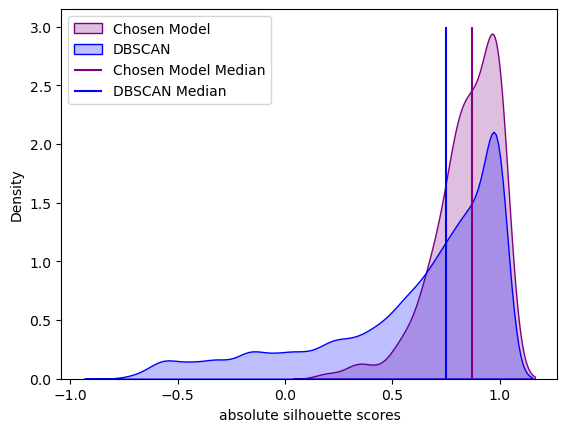

In [201]:
# How does my model's distribution compare to the overall distribution of DBSCAN models by absolute silhouette score?

plt.figure()
sns.kdeplot(overall_performance["db_abs_silhouette"], color = "purple", common_norm = False, fill = True, label = "Chosen Model")
sns.kdeplot(sil_scores_df["db_abs_silhouette"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
plt.vlines(overall_performance["db_abs_silhouette"].median(), 0, 3, color = "purple", label = "Chosen Model Median")
plt.vlines(sil_scores_df["db_abs_silhouette"].median(), 0, 3, color = "blue", label = "DBSCAN Median")
plt.xlabel("absolute silhouette scores")
plt.legend(loc = "upper left")
plt.show()

Overall this model seems to performs better than the general distribution of choices. 
I know that hypothesis testing would be relevant here but feel pretty shakey on my hypothesis testing.
Here's what I'm going to try: a two sample t-test. 
The null hypothesis would be that these two distributions are the same.

In [232]:
#removing null values from the set before performing the t-test
hypo_abs_chosen = overall_performance[overall_performance["db_abs_silhouette"].notnull()]["db_abs_silhouette"]
hypo_abs_all = sil_scores_df[sil_scores_df["db_abs_silhouette"].notnull()]["db_abs_silhouette"]

In [234]:
# performing the t-test

stat, p_value = ttest_ind(hypo_abs_chosen, hypo_abs_all)  
# Check the p-value to determine statistical significance
p_value

1.7039203893997542e-14

According to this p-value, I should reject the null hypothesis (choosing a threshold of 5% this is well below the threshold) and so with a confidence of (way over) 99%, I can say that my chosen DBSCAN model performs better than the general collection of performance of DBSCAN models. 

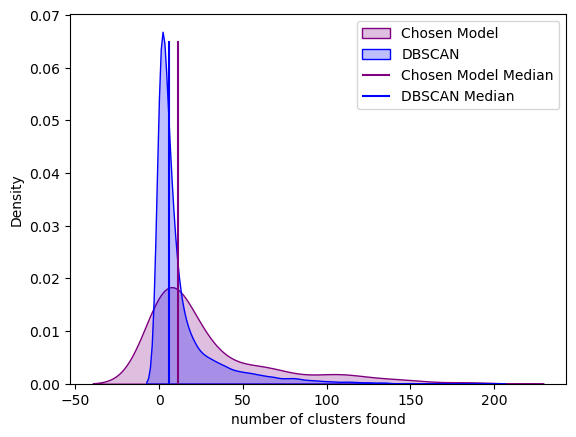

In [217]:
# How does my model's distribution of "number of clusters" found compare to the general distribution?

plt.figure()
sns.kdeplot(overall_performance["num_db_clusters"], color = "purple", common_norm = False, fill = True, label = "Chosen Model")
sns.kdeplot(sil_scores_df["num_db_clusters"], color = "blue", common_norm = False, fill = True, label = "DBSCAN")
plt.vlines(overall_performance["num_db_clusters"].median(), 0, .065, color = "purple", label = "Chosen Model Median")
plt.vlines(sil_scores_df["num_db_clusters"].median(), 0, .065, color = "blue", label = "DBSCAN Median")
plt.xlabel("number of clusters found")
plt.legend(loc = "upper right")
plt.show()

What's even nicer is that it seems that my model not only has better silhouette scores but it doesn't do it at the expense of making the clusters too small--in general this model finds more clusters than the general range of the dbscan models. 

In [235]:
# hypothesis testing again
hypo_num_cl_chosen = overall_performance[overall_performance["num_db_clusters"].notnull()]["num_db_clusters"]
hypo_num_cl_all = sil_scores_df[sil_scores_df["num_db_clusters"].notnull()]["num_db_clusters"]
stat, p_value = ttest_ind(hypo_num_cl_chosen, hypo_num_cl_all)  
p_value

3.3865091640765286e-22

Rejecting the null hypothesis (that the above distributions are the same), I can say that my model finds more clusters than the average DBSCAN model.

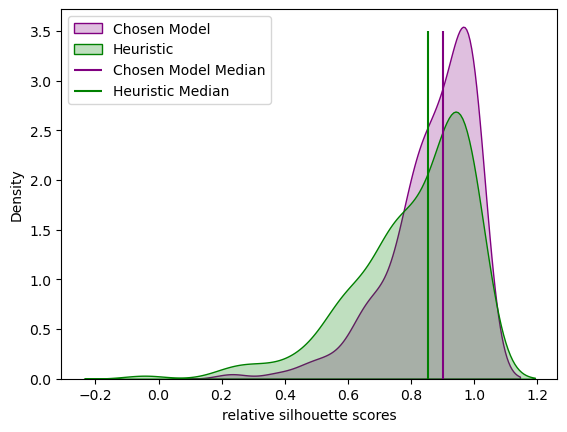

In [209]:
# How does my model's relative silhouette score distribution compare 
# to that of the heuristic model under the same min_sample and feature selection conditions?
plt.figure()
sns.kdeplot(overall_performance["db_rel_silhouette"], color = "purple", common_norm = False, fill = True, label = "Chosen Model")
sns.kdeplot(overall_performance["baseline_rel_silhouette"], color = "green", common_norm = False, fill = True, label = "Heuristic")
plt.vlines(overall_performance["db_rel_silhouette"].median(), 0, 3.5, color = "purple", label = "Chosen Model Median")
plt.vlines(overall_performance["baseline_rel_silhouette"].median(), 0, 3.5, color = "green", label = "Heuristic Median")
plt.xlabel("relative silhouette scores")
plt.legend(loc = "upper left")
plt.show()

Looks similar and/or slightly better. 

In [236]:
# hypothesis testing again
hypo_rel_chosen = overall_performance[overall_performance["db_rel_silhouette"].notnull()]["db_rel_silhouette"]
hypo_rel_heur = overall_performance[overall_performance["baseline_rel_silhouette"].notnull()]["baseline_rel_silhouette"]
stat, p_value = ttest_ind(hypo_rel_chosen, hypo_rel_heur)  
p_value

0.00033894705133159553

Wow. I didn't expect to be able to reject the null hypothesis (that these two distributions are the same) on this one, but feel pretty good about that. I can say with (more than) 99% confidence that my DBSCAN model's scores relative to feature code 5's chosen features is better than my heuristic (assuming I am doing the hypothesis testing correctly). 

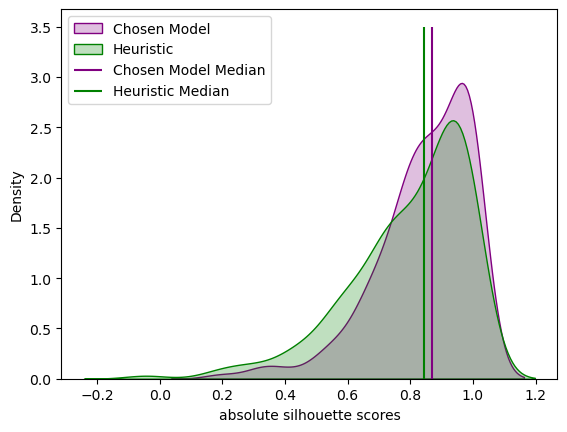

In [208]:
# How does my model's absolute silhouette score distribution compare 
# to that of the heuristic model under the same min_sample and feature selection conditions?

plt.figure()
sns.kdeplot(overall_performance["db_abs_silhouette"], color = "purple", common_norm = False, fill = True, label = "Chosen Model")
sns.kdeplot(overall_performance["baseline_abs_silhouette"], color = "green", common_norm = False, fill = True, label = "Heuristic")
plt.vlines(overall_performance["db_abs_silhouette"].median(), 0, 3.5, color = "purple", label = "Chosen Model Median")
plt.vlines(overall_performance["baseline_abs_silhouette"].median(), 0, 3.5, color = "green", label = "Heuristic Median")
plt.xlabel("absolute silhouette scores")
plt.legend(loc = "upper left")
plt.show()

Again same story. Looks similar and/or slightly better. 

In [237]:
# hypothesis testing again
hypo_abs_chosen = overall_performance[overall_performance["db_abs_silhouette"].notnull()]["db_abs_silhouette"]
hypo_abs_heur = overall_performance[overall_performance["baseline_abs_silhouette"].notnull()]["baseline_abs_silhouette"]
stat, p_value = ttest_ind(hypo_abs_chosen, hypo_abs_heur)  
p_value

0.007123876308574996

Again, I didn't expect to be able to reject the null hypothesis (that these two distributions are the same) on this one, but I can say with (more than) 99% confidence that my DBSCAN model's scores relative all numerical values is better than my heuristic (assuming I am doing the hypothesis testing correctly). 

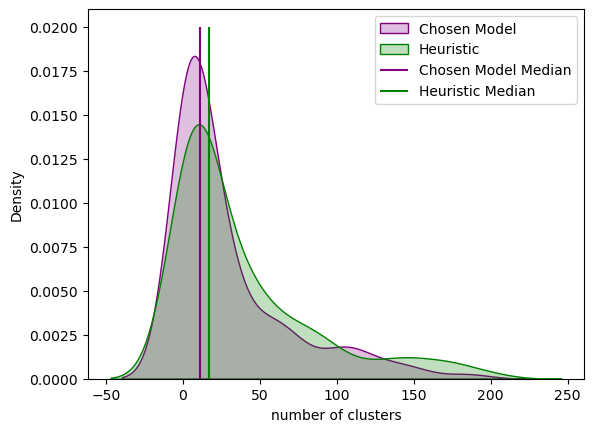

In [242]:
# How does my model's cluster number distribution compare 
# to that of the heuristic model under the same min_sample and feature selection conditions?

plt.figure()
sns.kdeplot(overall_performance["num_db_clusters"], color = "purple", common_norm = False, fill = True, label = "Chosen Model")
sns.kdeplot(overall_performance["num_bl_clusters"], color = "green", common_norm = False, fill = True, label = "Heuristic")
plt.vlines(overall_performance["num_db_clusters"].median(), 0, .02, color = "purple", label = "Chosen Model Median")
plt.vlines(overall_performance["num_bl_clusters"].median(), 0, .02, color = "green", label = "Heuristic Median")
plt.xlabel("number of clusters")
plt.legend(loc = "upper right")
plt.show()

As expected, the DBSCAN model is a more discerning, which is what I was looking for. But doesn't reject too too many of the potential hikes. Again wishing I'd also included the metric of "length of cluster" because reducing that but not by too much would be a sign that dbscan is being helpful as well.

In [239]:
# hypothesis testing 
hypo_num_chosen = overall_performance[overall_performance["num_db_clusters"].notnull()]["num_db_clusters"]
hypo_num_heur = overall_performance[overall_performance["num_bl_clusters"].notnull()]["num_bl_clusters"]
stat, p_value = ttest_ind(hypo_num_chosen, hypo_num_heur)  
p_valueove

0.025584403159825145

Worst p-value of the bunch but still beats the 5% threshold so my model shows statistically significant difference from the heuristic model even on number of clusters.


In [241]:
overall_performance.describe()

user_id  feature_code           eps  min_samples  \
count  2.250000e+02         225.0  2.250000e+02        225.0   
mean   2.323288e+06           5.0  5.000000e-02          5.0   
std    1.679171e+06           0.0  1.112698e-16          0.0   
min    1.843400e+04           5.0  5.000000e-02          5.0   
25%    9.381020e+05           5.0  5.000000e-02          5.0   
50%    1.892152e+06           5.0  5.000000e-02          5.0   
75%    3.229159e+06           5.0  5.000000e-02          5.0   
max    6.922111e+06           5.0  5.000000e-02          5.0   

       baseline_rel_silhouette  db_rel_silhouette  baseline_abs_silhouette  \
count               203.000000         182.000000               203.000000   
mean                  0.805993           0.866710                 0.795618   
std                   0.185658           0.137030                 0.190722   
min                  -0.043767           0.232171                -0.044124   
25%                   0.721001           0.804994                 0.700982   
50%                   0.852807           0.902938                 0.842293   
75%                   0.956958           0.986330                 0.949364   
max                   0.999951           0.999991                 0.999951   

       db_abs_silhouette  num_db_clusters  num_bl_clusters  
count         182.000000       225.000000       225.000000  
mean            0.843714        29.084444        38.128889  
std             0.153547        39.043554        46.303023  
min             0.198046         0.000000         0.000000  
25%             0.769915         3.000000         6.000000  
50%             0.868308        11.000000        17.000000  
75%             0.982573        36.000000        54.000000  
max             0.999991       190.000000       199.000000

In [245]:
# how much improvement in relative scores did the dbscan model make over the heuristic?
(overall_performance["db_rel_silhouette"].mean() - overall_performance["baseline_rel_silhouette"].mean()) / overall_performance["baseline_rel_silhouette"].mean()

0.07533168457298077

In [246]:
# how much improvement in absolute scores did the dbscan model make over the heuristic?
(overall_performance["db_abs_silhouette"].mean() - overall_performance["baseline_abs_silhouette"].mean()) / overall_performance["baseline_abs_silhouette"].mean()

0.06045188204363681

In [247]:
# how much more discerning was the dbscan model over the heuristic?
(overall_performance["num_bl_clusters"].mean() - overall_performance["num_db_clusters"].mean()) / overall_performance["num_bl_clusters"].mean()

0.23720713369856627

Dang. Had to cut the clustering down by almost 1/4 to create a performance gain of 6-7% (depending on the metric used). But that is an interesting find. And likely necessary. It isn't surprising that about 1/4 of the "hikes" found when clustering with a general rule like "any day that has 5 or more observations is considered a 'hike'" would need to be thrown out. 

## Results: Apply the Chosen Model <a id = "9"></a>

In [248]:
def model_to_user(user, df = df_sp_smaller):
    
    '''
    Takes the number of a user, applies the chosen dbscan model to it 
    and returns cluster labels for that user.
    
    Arguments:
    user = "user_id" of a user in the dataframe
    df = default is df_sp_smaller but any dataframe can be specified 
    so long as it has the same columns as df_sp_smaller
    
    Returns:
    array of cluster labels, one entry for every observation in the user's personal dataframe
    '''
    
    # select feature code 5
    feature_columns = feat_sel_param(5)[1]
    
    # df of just user
    user_df = df[df["user_id"] == user]
    # df of just user's features for dbscan
    feature_df = user_df[feature_columns]

    # scale
    mms = MinMaxScaler() 
    scaled_df = mms.fit_transform(feature_df)

    # selected model
    dbscan_model = DBSCAN(eps=.05, min_samples=5)

    # Fit and get labels
    cluster_labels = dbscan_model.fit_predict(scaled_df)
    
    return cluster_labels

In [249]:
# applying the model to df_sp_smaller and making a column for the cluster labels
# NOTE: Cluster_Label" cannot be meaningfully grouped on in the larger dataset
#--groupby and filters MUST be with user_id and then cluster_label
# the only exception is in the case of "Cluster_Label" = -1 which is noise (one-off observation) for all users
for user in df_sp_smaller["user_id"].unique():
 
    # store labels in dataframe
    df_sp.loc[df_sp["user_id"] == user, "Cluster_Label"] = model_to_user(user)

In [250]:
# applying the model to df_sp and making a column for the cluster labels
# NOTE: Cluster_Label" cannot be meaningfully grouped on in the larger dataset
#--groupby and filters MUST be with user_id and then cluster_label
# the only exception is in the case of "Cluster_Label" = -1 which is noise (one-off observation) for all users

for user in df_sp["user_id"].unique():
 
    # store labels in dataframe
    df_sp.loc[df_sp["user_id"] == user, "Cluster_Label"] = model_to_user(user, df = df_sp)

### Visualize some of the user's clusters
I picked 10 users at random to visualize to see how the dbscan clusters performed.

In [251]:
#random_users = np.random.choice(df_sp["user_id"].unique(), size=10, replace=False)

# generated with code above and then copy and pasted so that it doesn't change with rerunning
# (I still haven't had enough experience with using seeds to feel confident about their consistency)
random_users = [2154312, 2357773,  777160, 1590417,  507882, 2248142, 1308403, 1006938,  780600, 2375374]

User number 2154312


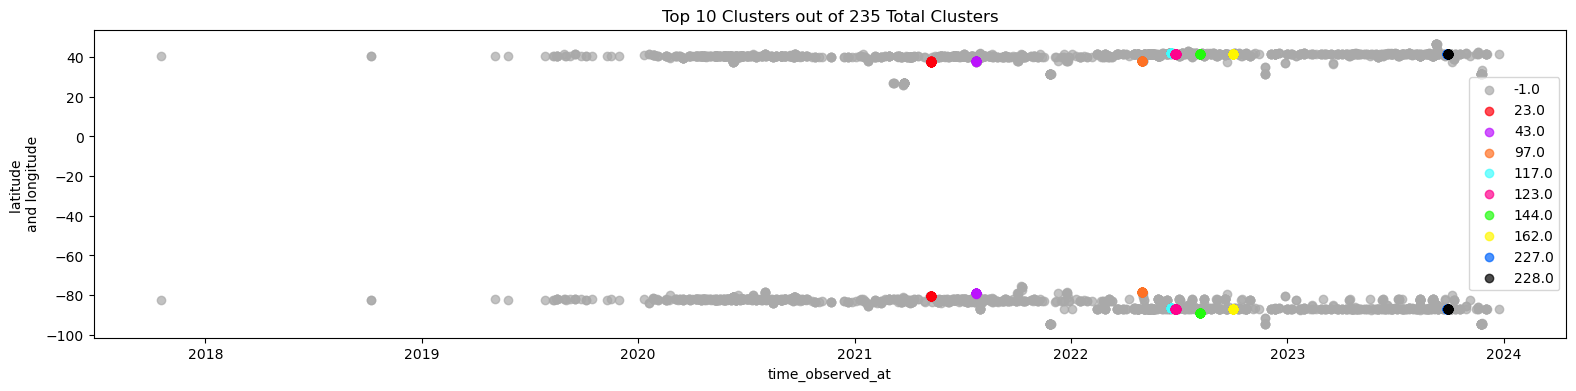

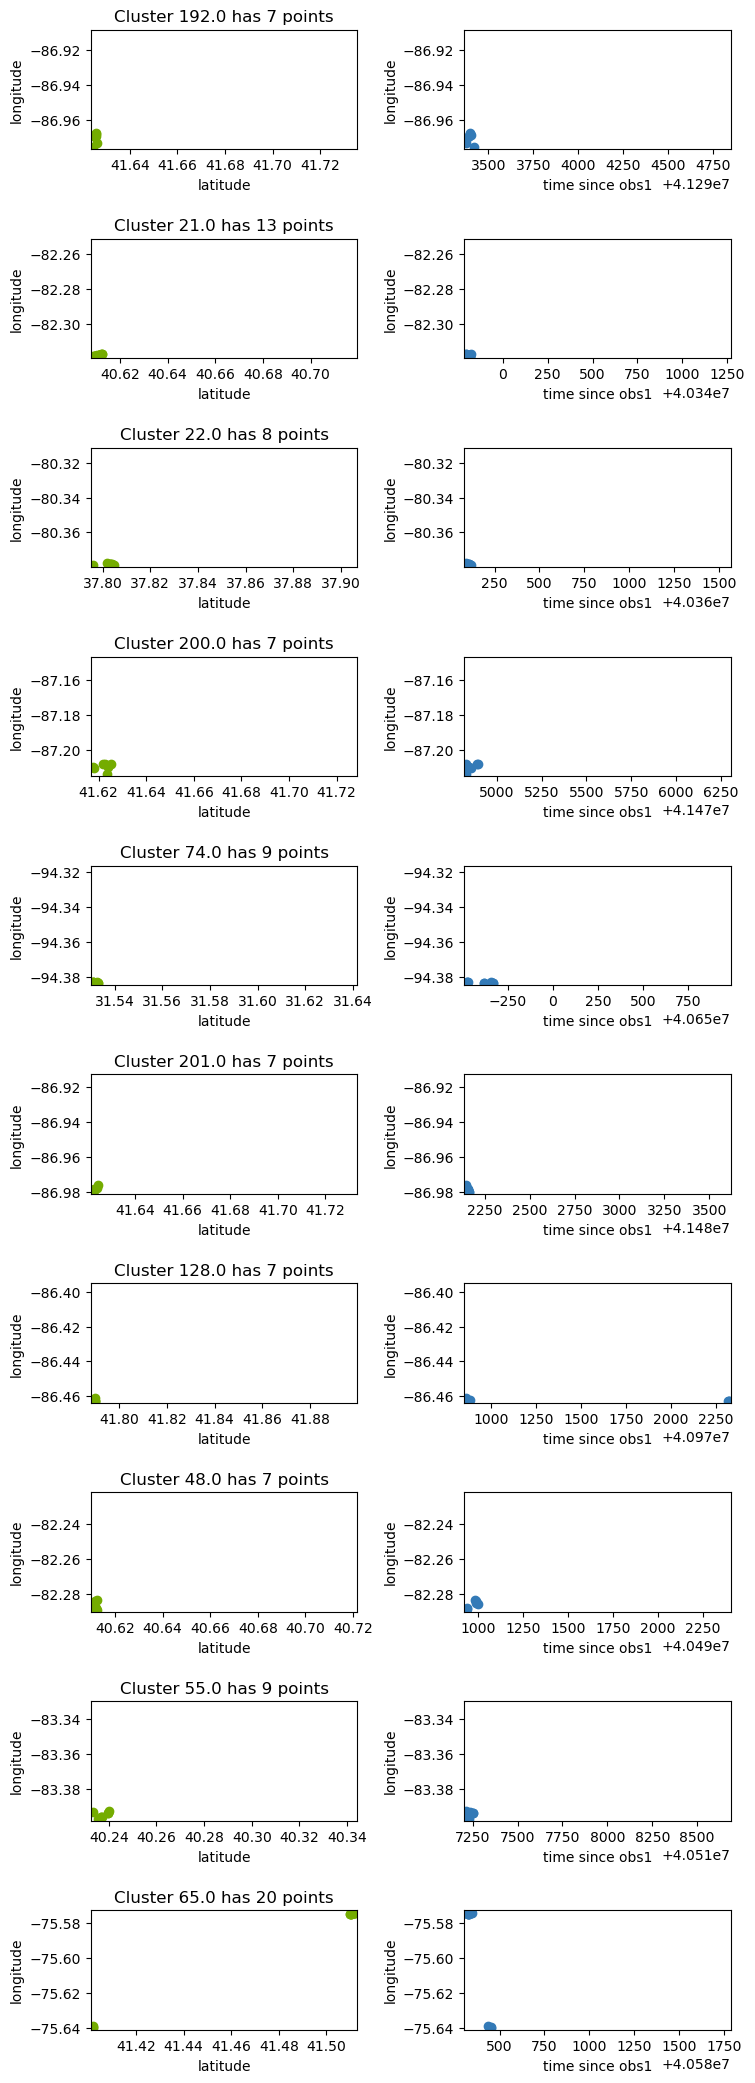

User number 2357773


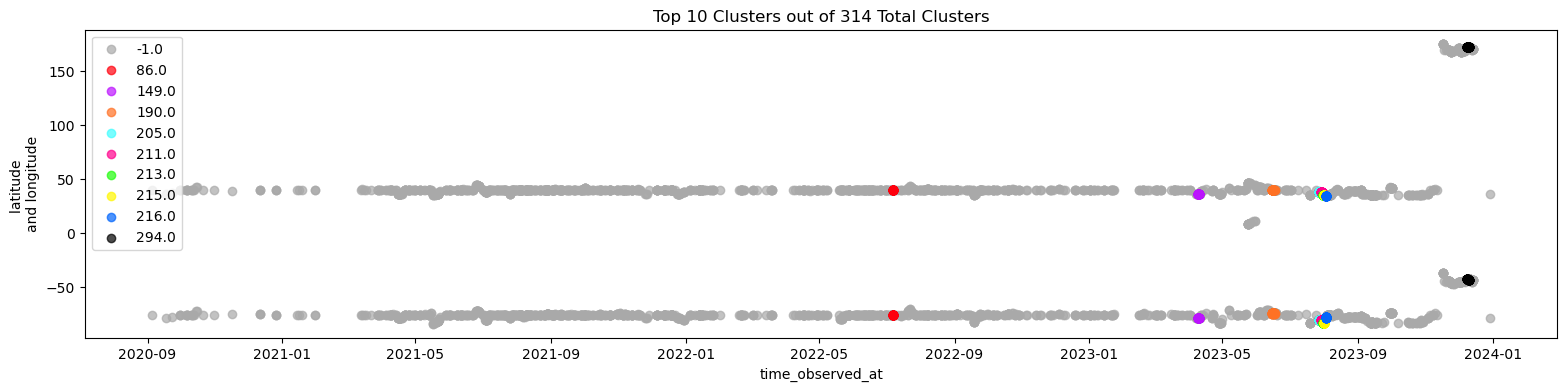

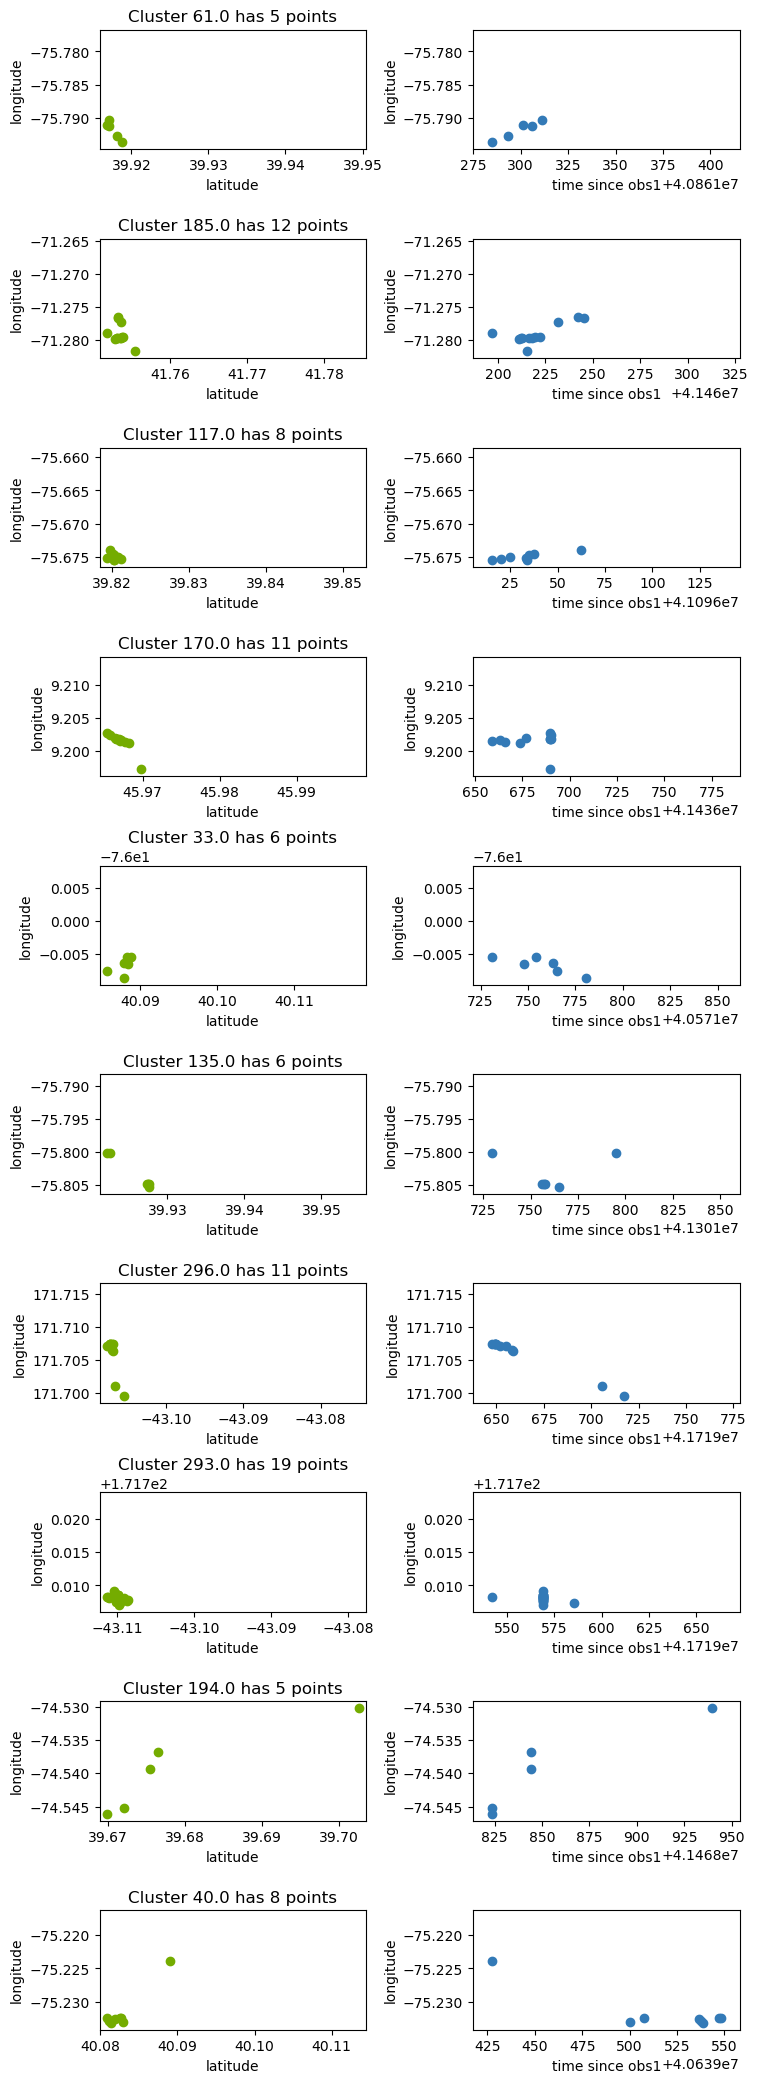

User number 777160


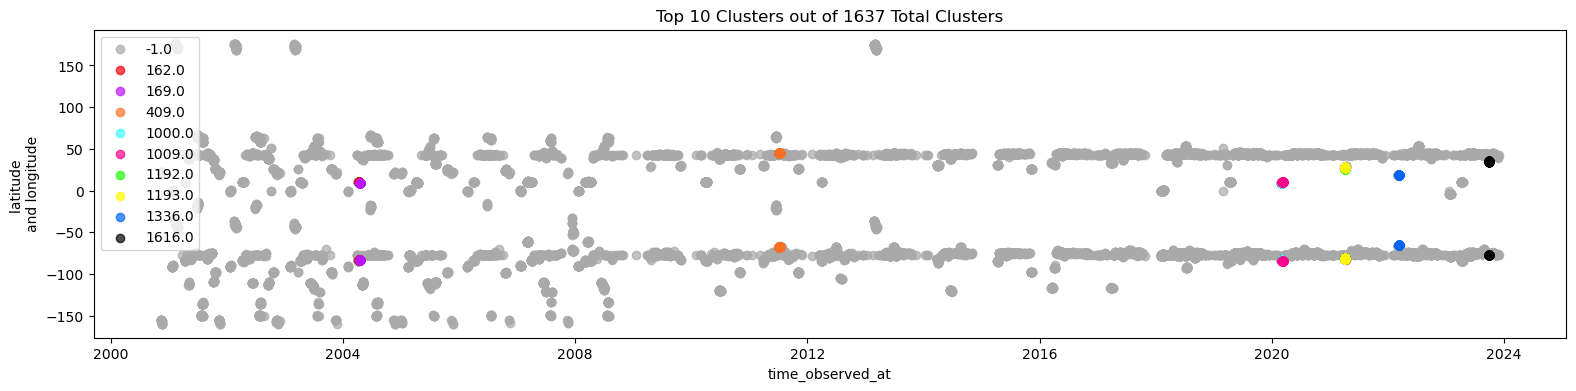

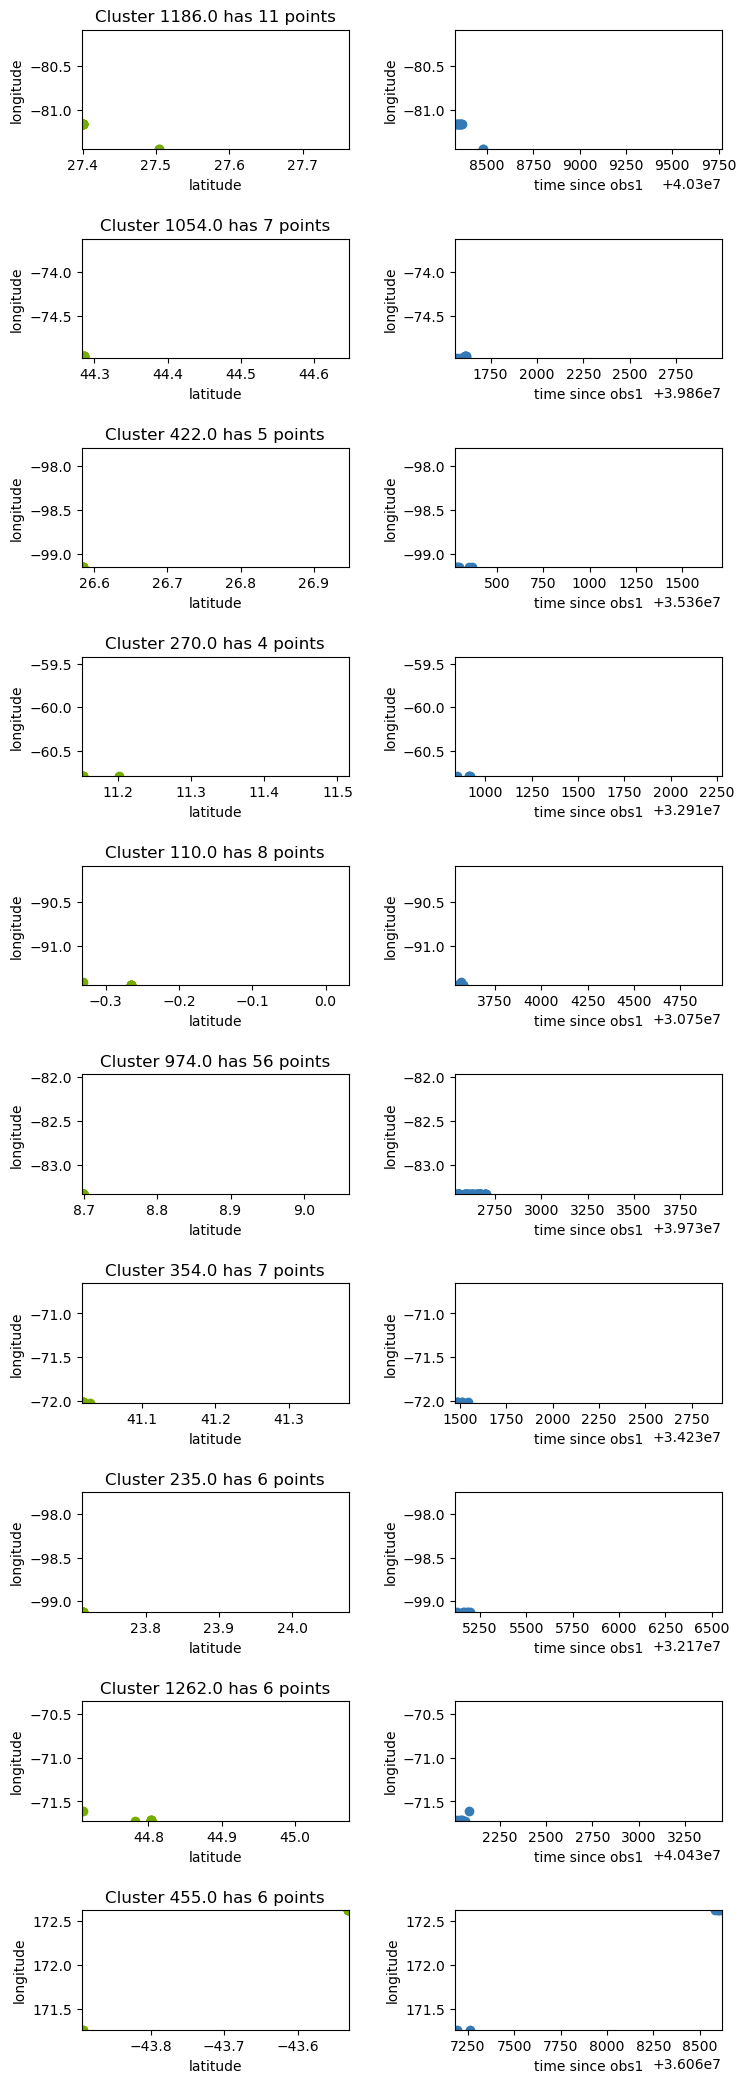

User number 1590417


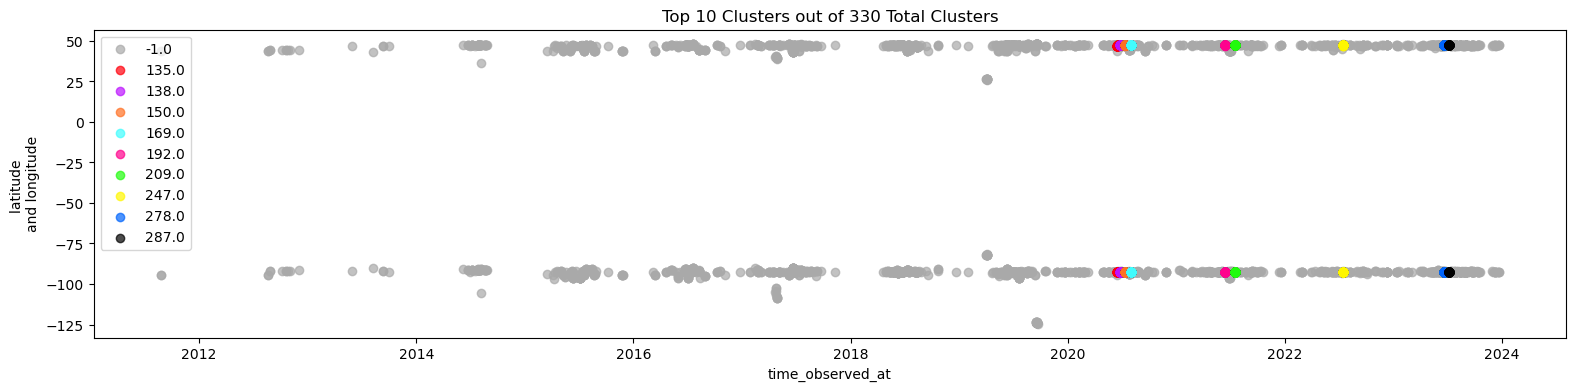

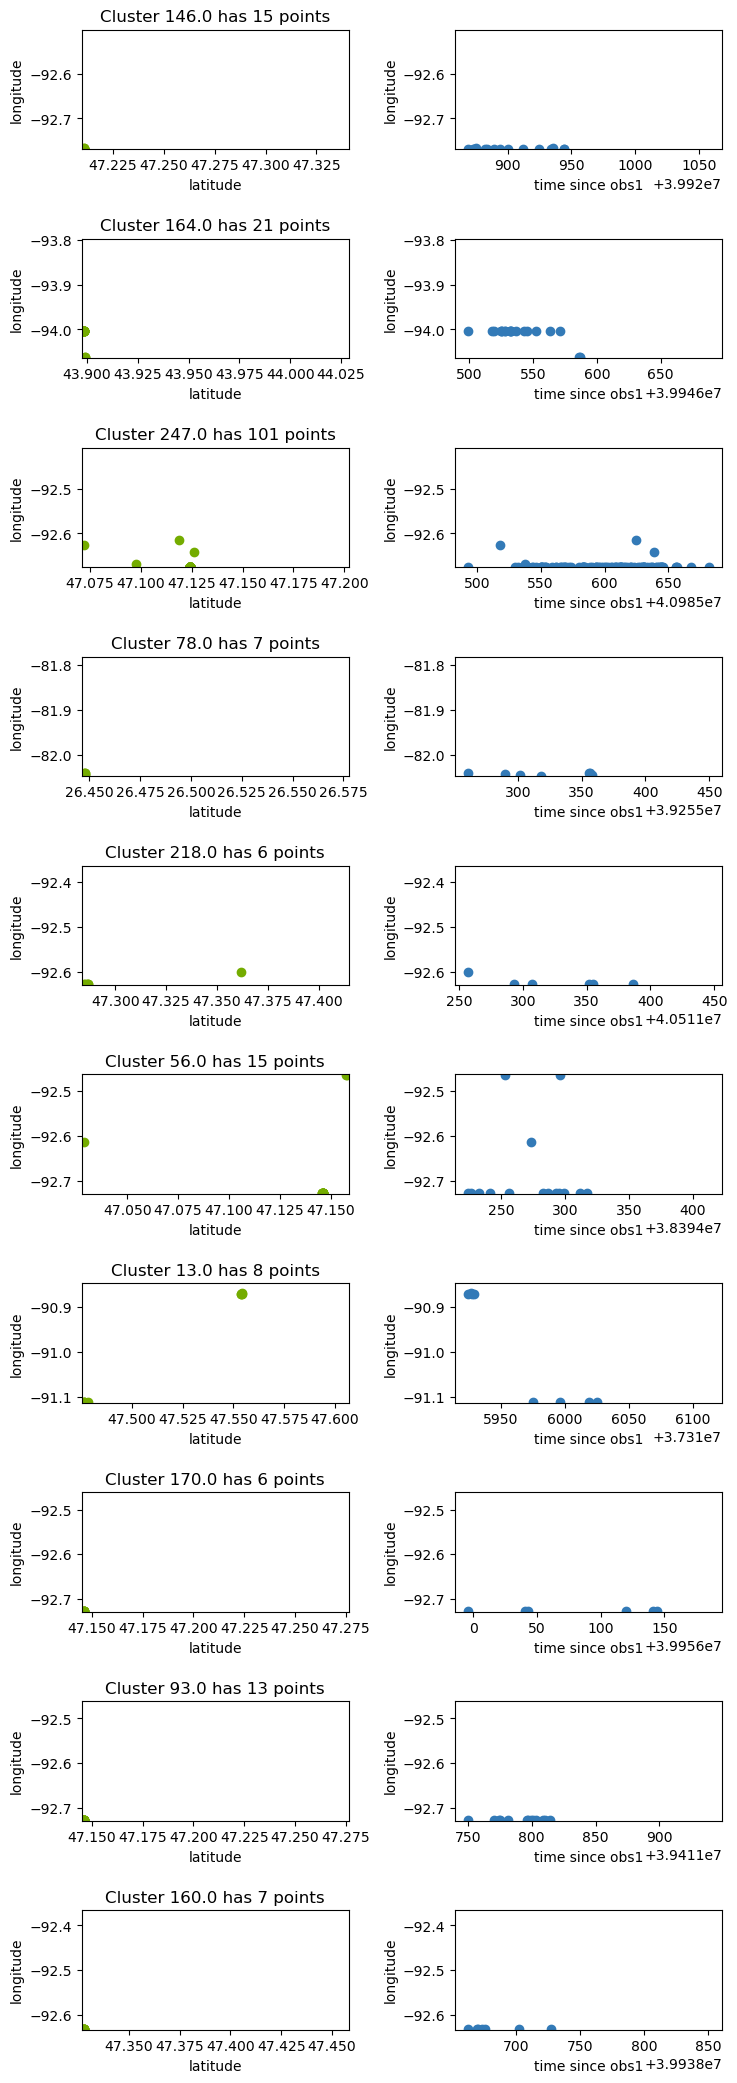

User number 507882


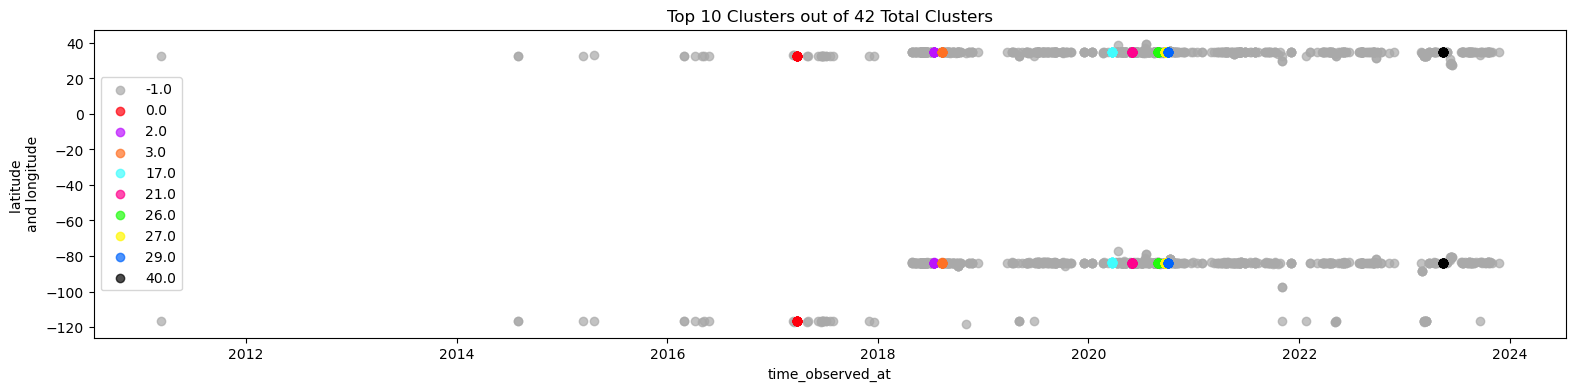

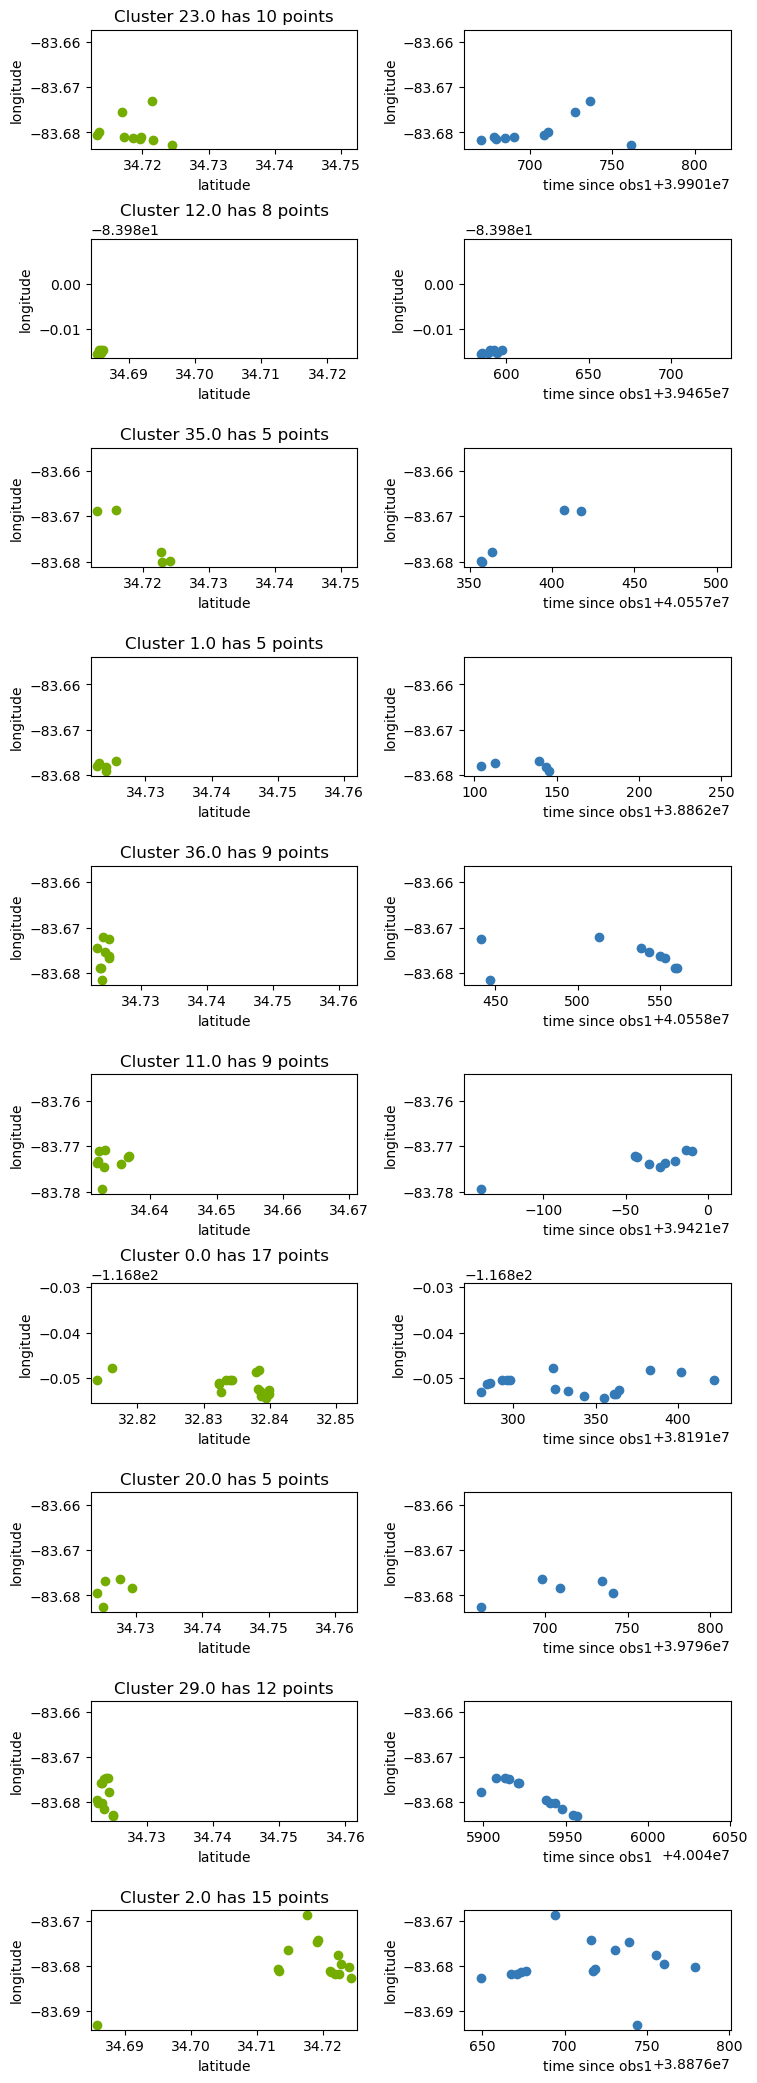

User number 2248142


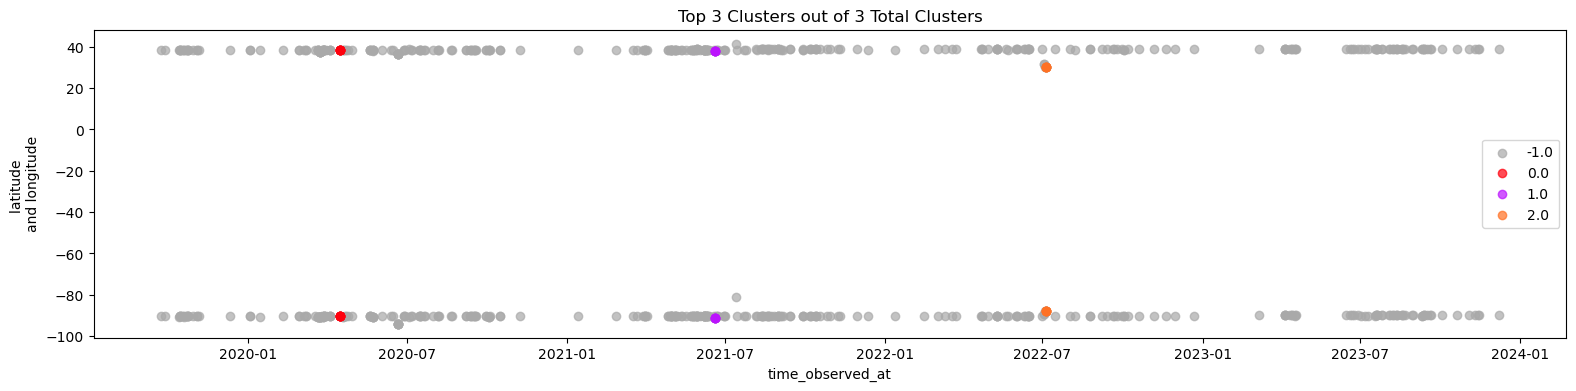

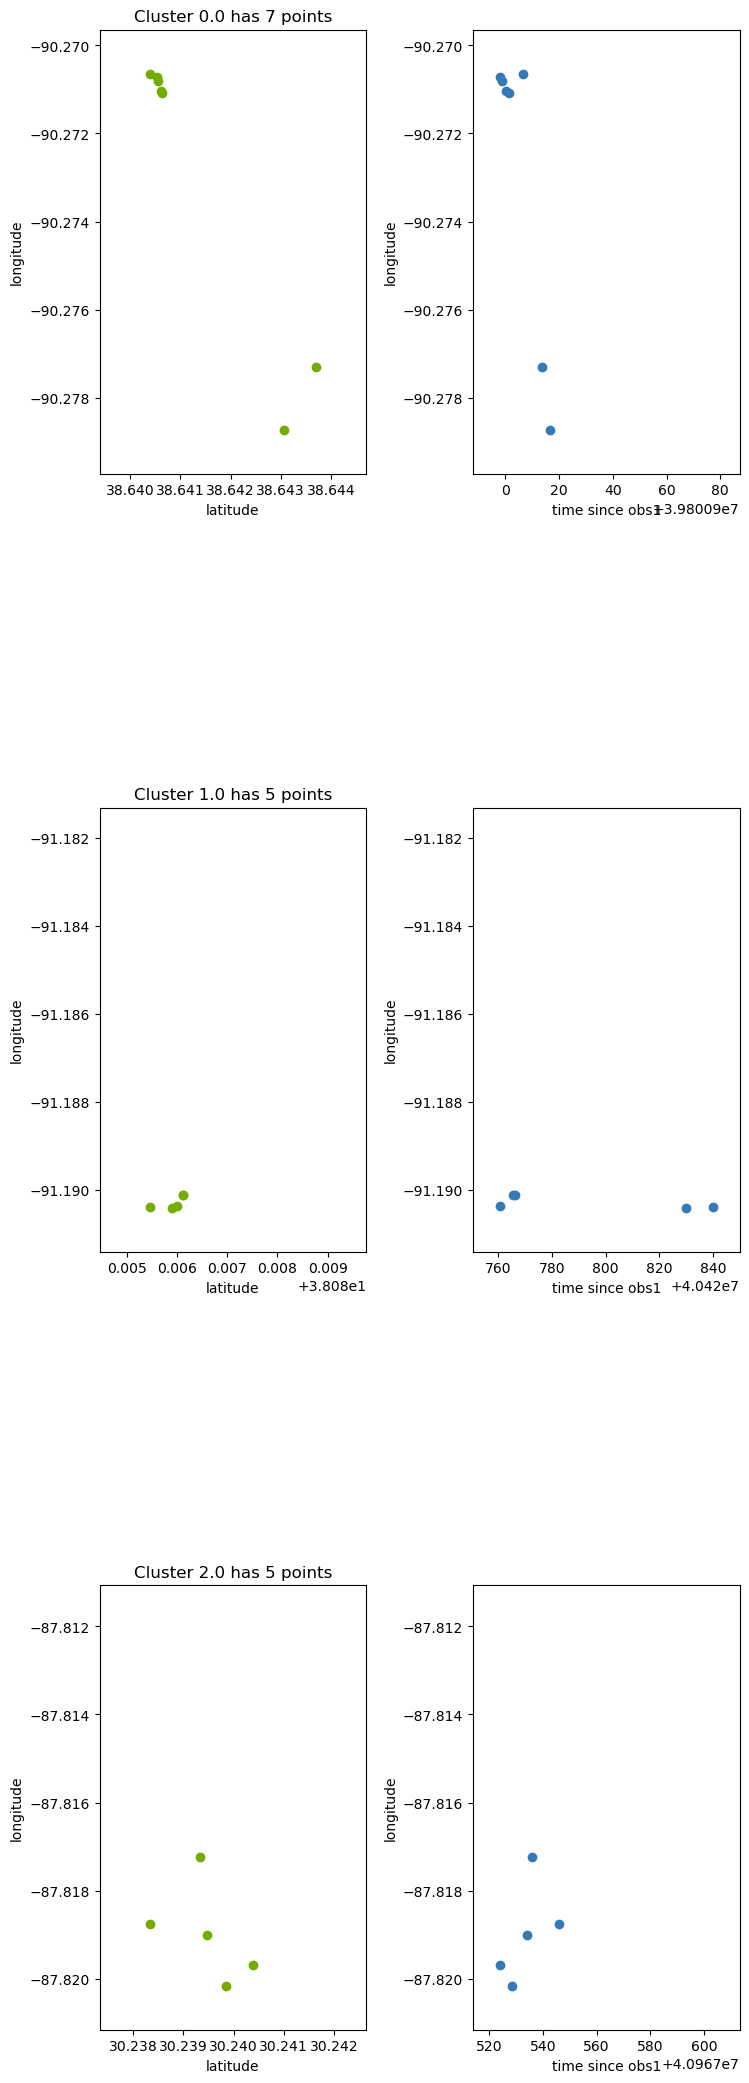

User number 1308403


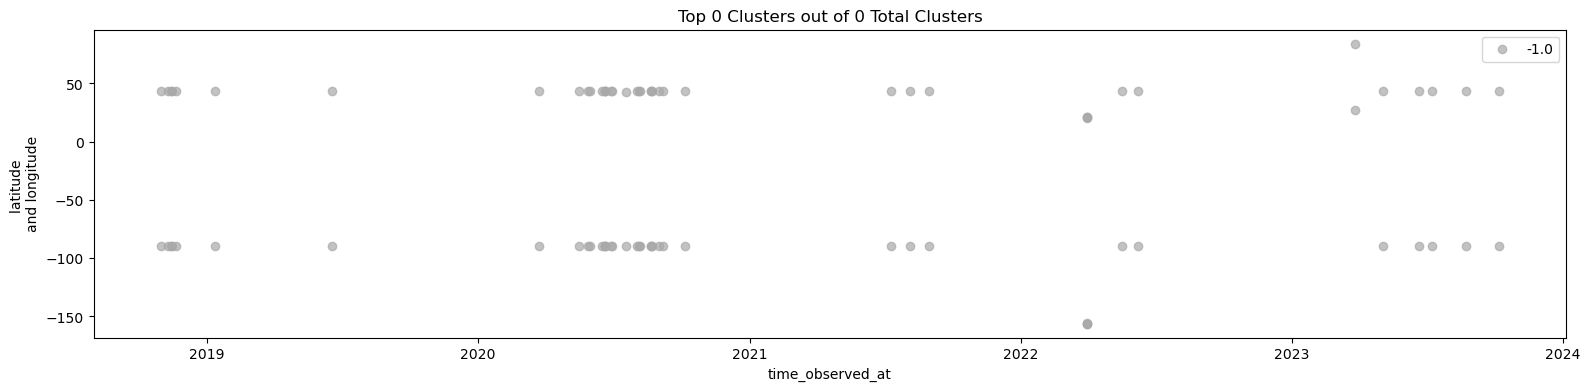

No clusters to view
User number 1006938


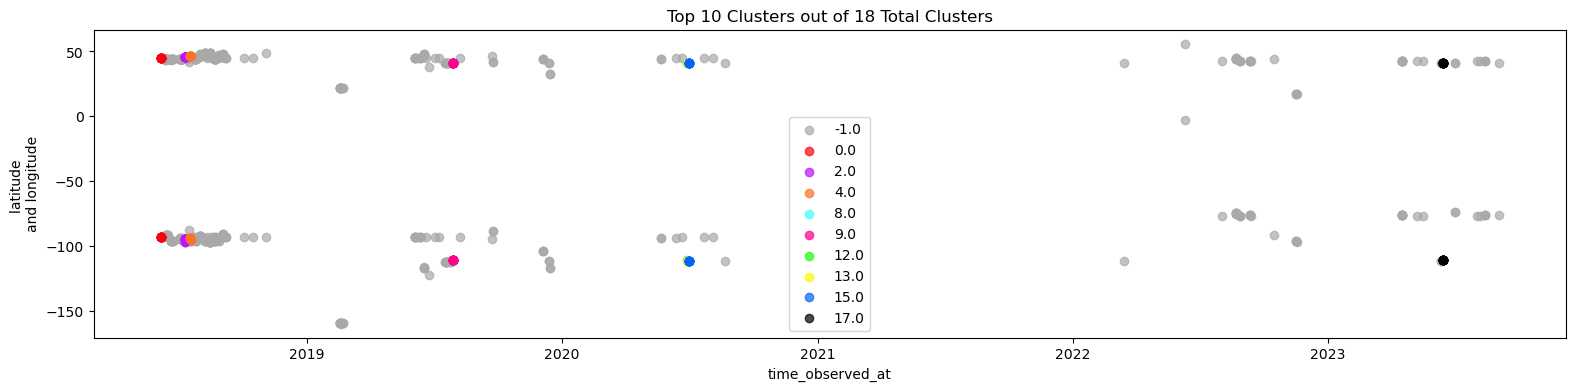

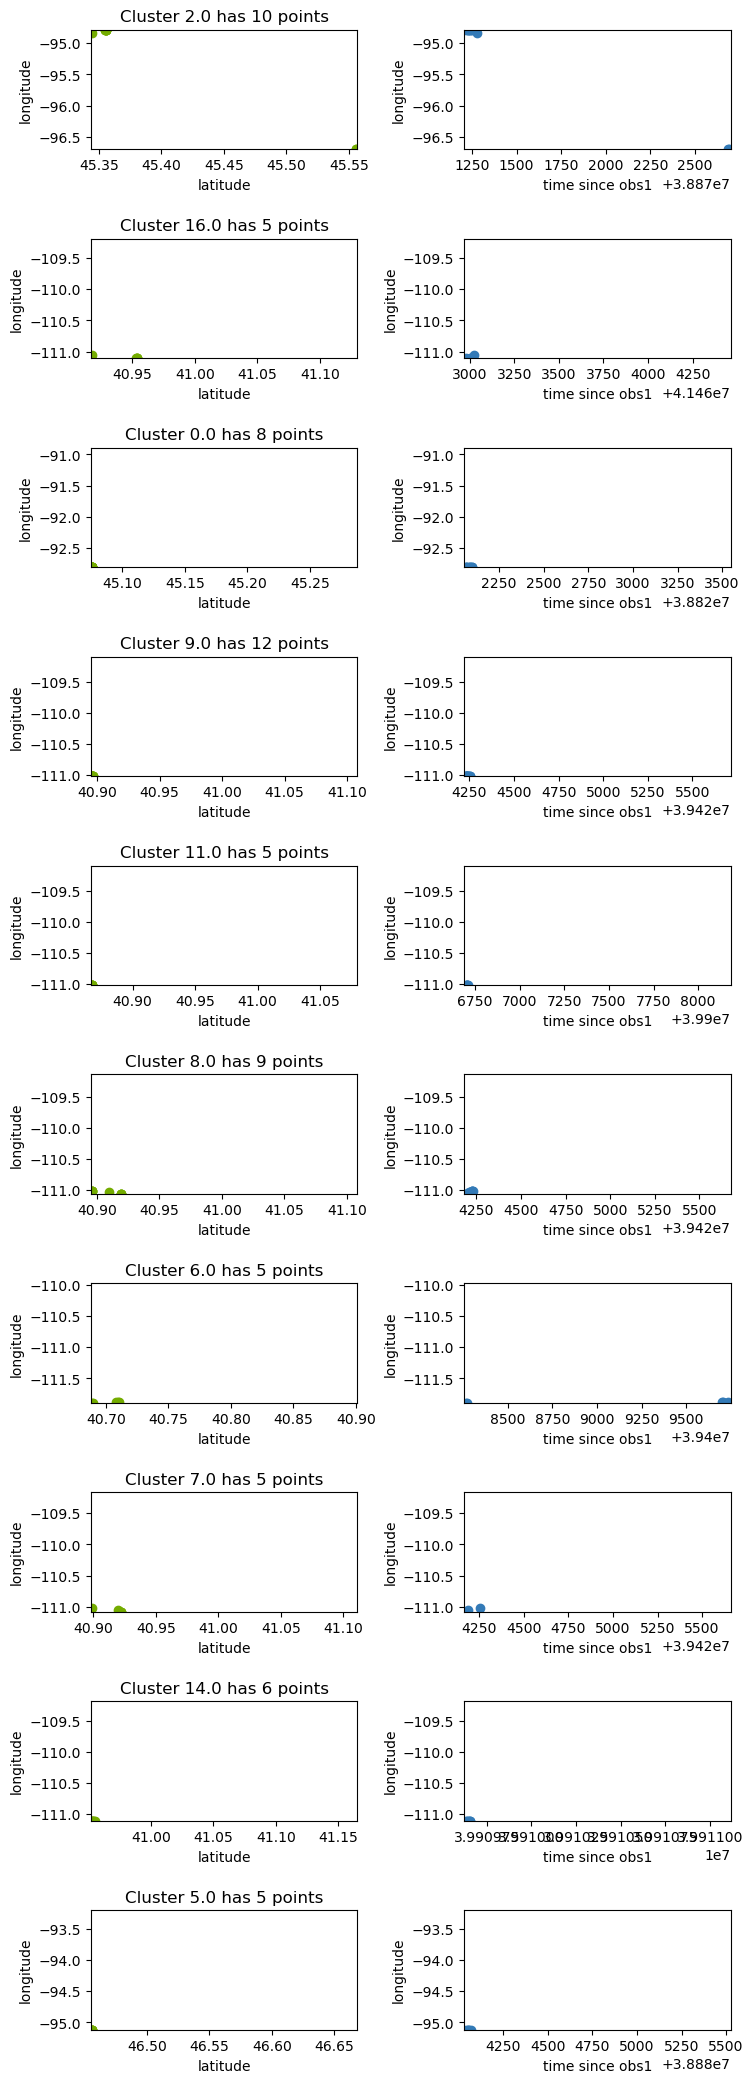

User number 780600


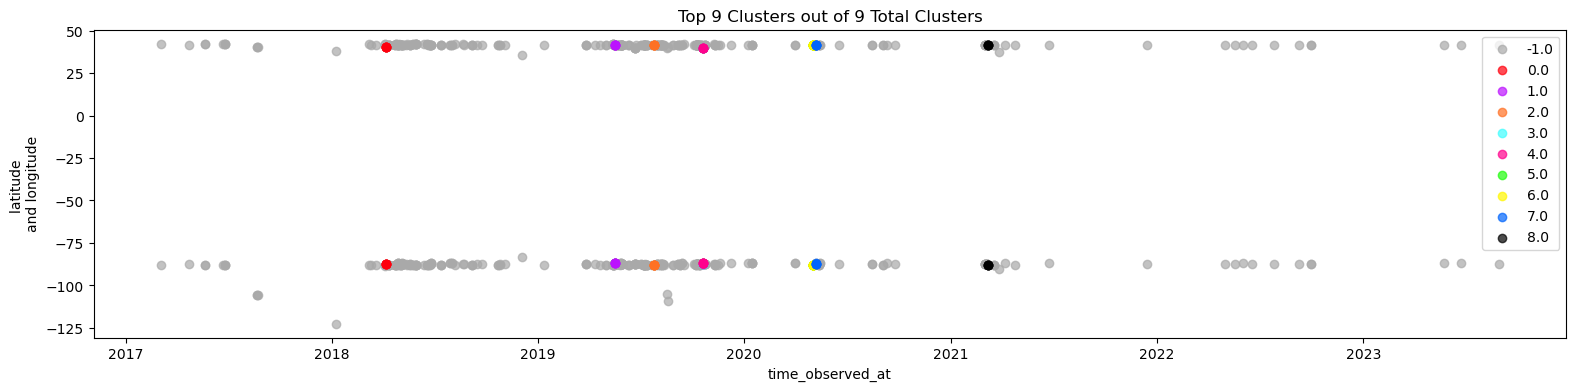

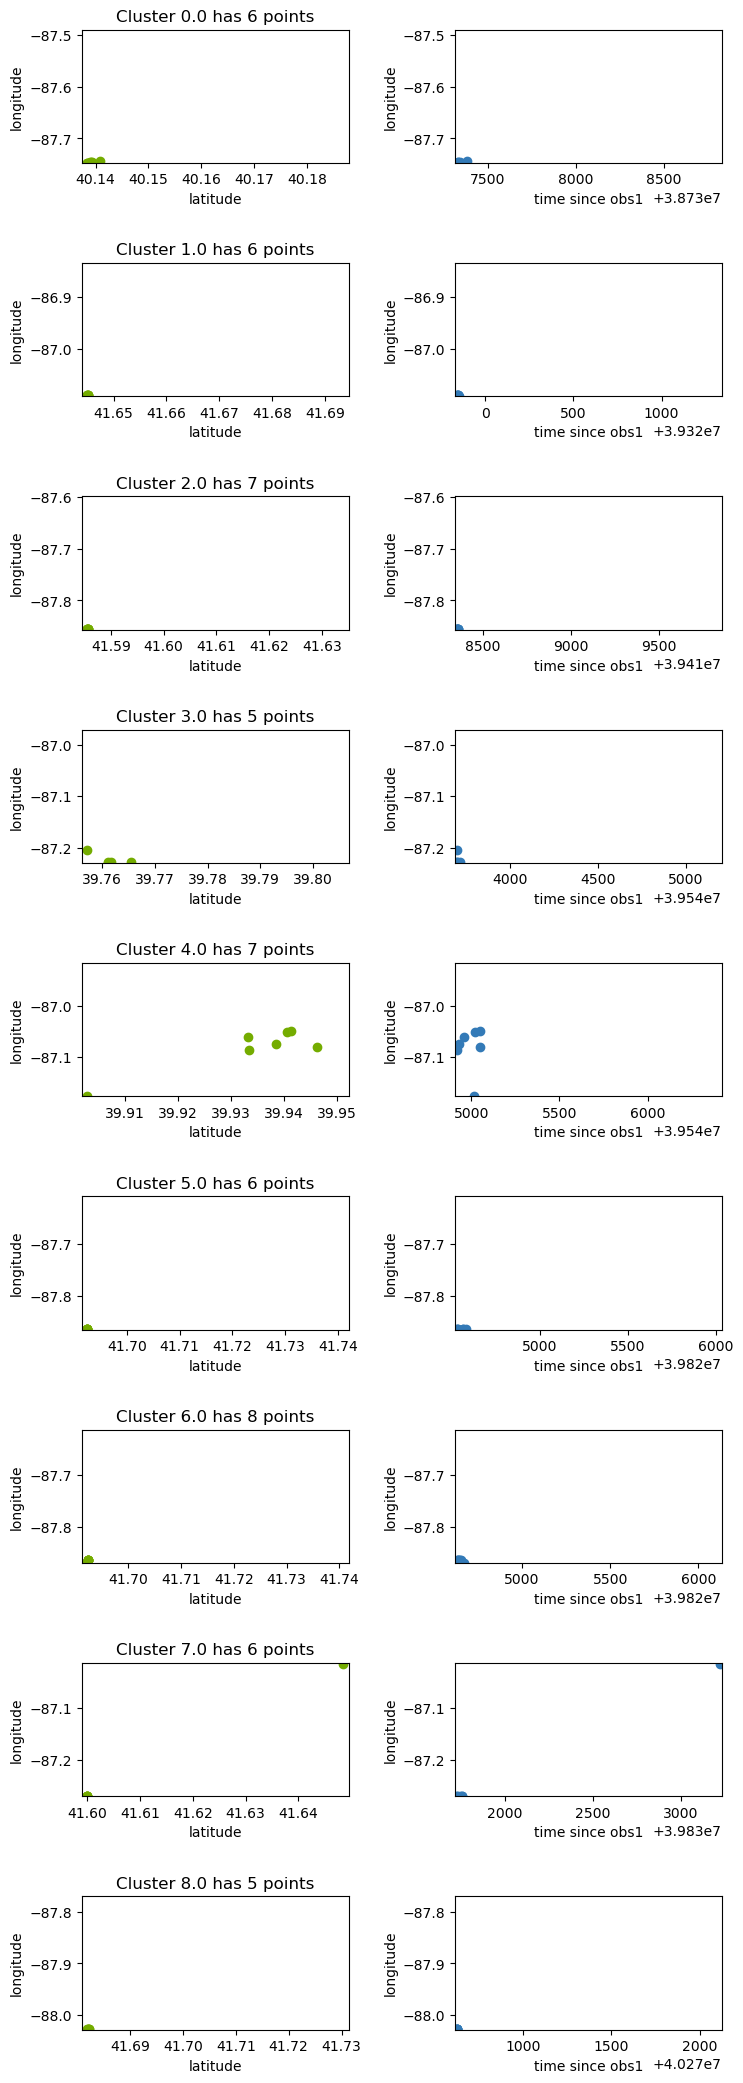

User number 2375374


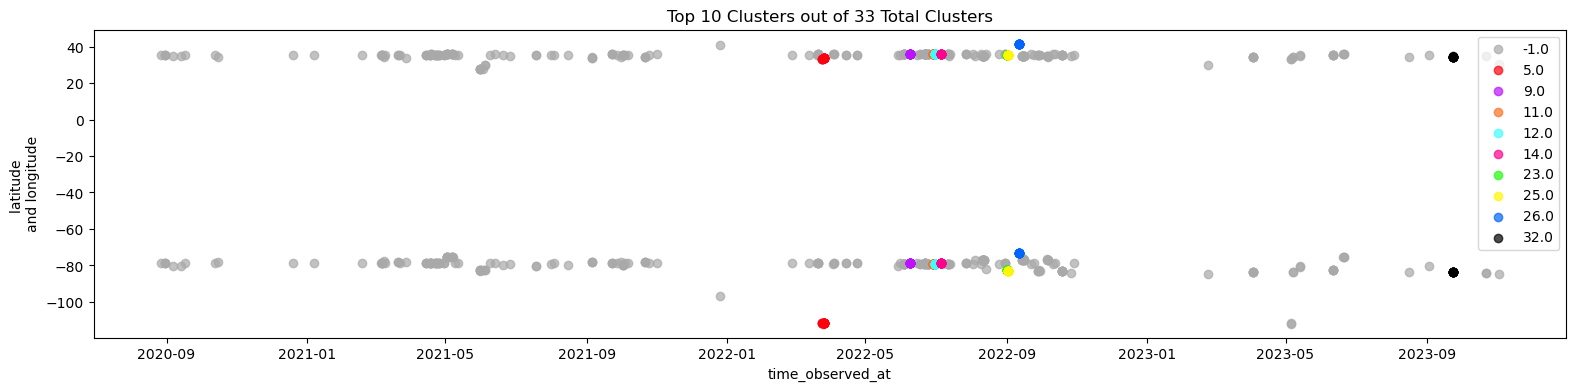

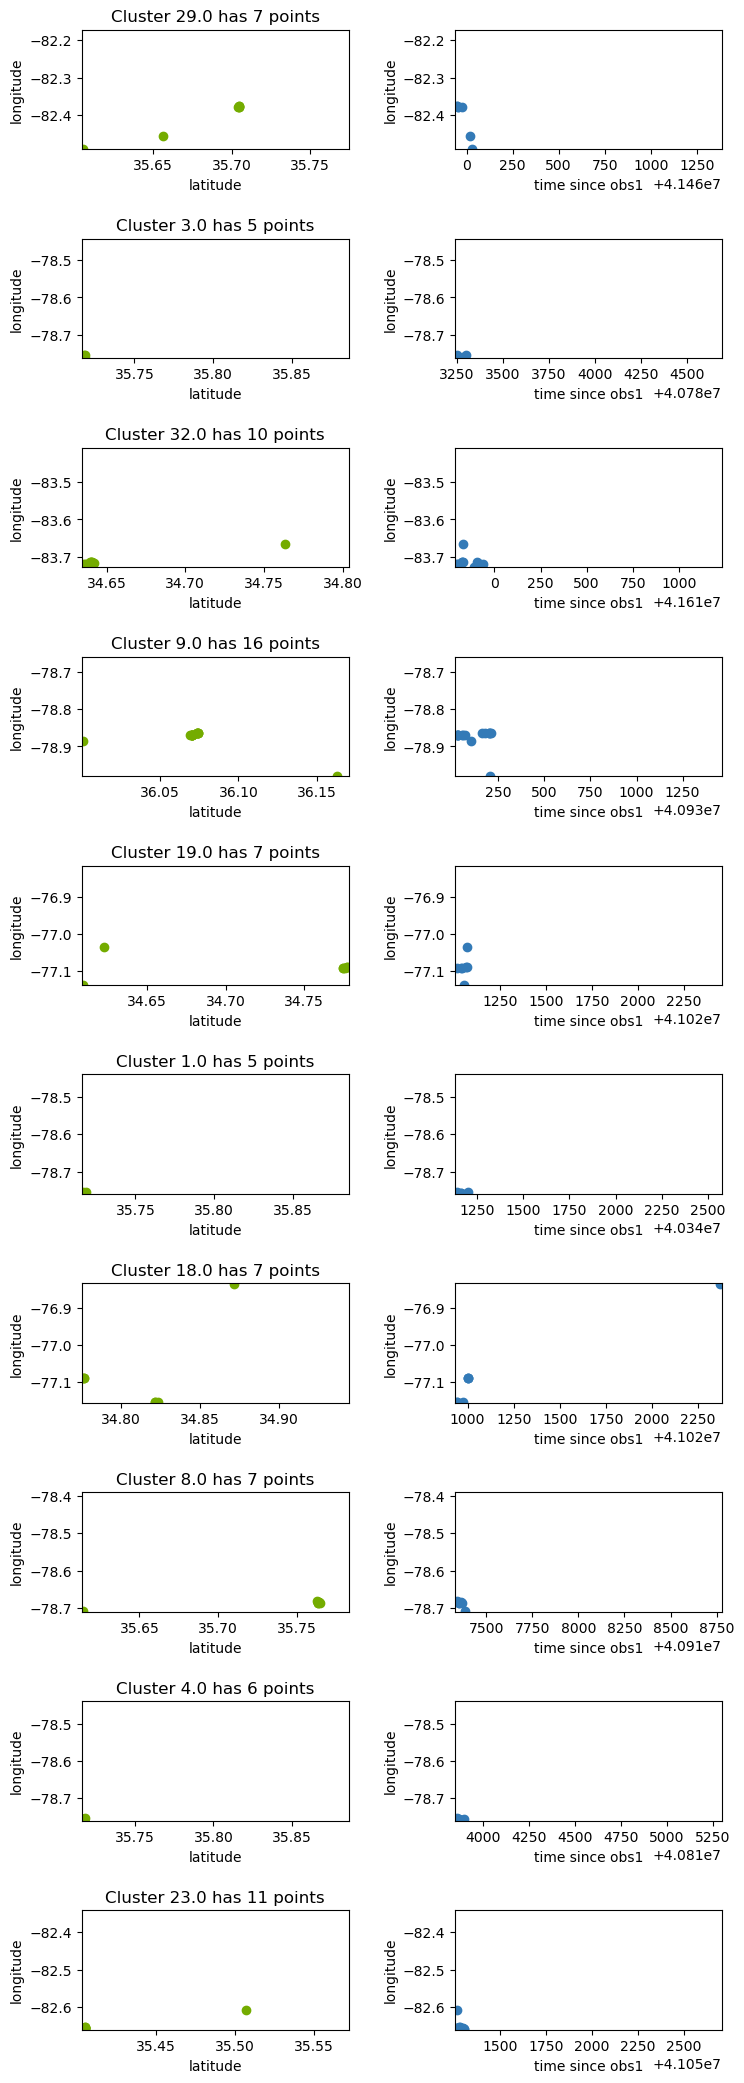

In [252]:
# creating cluster overview and cluster views for each user
# reminder that cluster_overview shows the 10 largest hikes if there are more than 10 hikes
# whereas cluster_views shows 10 random hikes and those will change if this code is run again
for i in range(10):
    print(f'User number {random_users[i]}')
    cluster_overview("Cluster_Label", df = df_sp[df_sp["user_id"] == random_users[i]])
    cluster_views("Cluster_Label", df = df_sp[df_sp["user_id"] == random_users[i]])

### Application: Metrics for Describing User Behavior <a id = "10"></a>

one_off_ness = percent of noise out of total observations 
because dbscan noise in this case refers to times observations weren't taken 
in close time/space to other observations

avg_obs_per_hike = what it sounds like
If a cluster/hike is identified, how many observations were in that cluster? 
Overall what is the user's average?

Note: other potential measures I'd like to explore and think would be useful but haven't yet:
average distance covered per cluster/hike
average time spent per cluster/hike


In [254]:
# creating dataframe of metrics for each user

# empty dictionary because I find those easier to be honest
user_data = {}

# go through each user in df_sp
for user in df_sp["user_id"].unique():
    # df filtered for only the user's data
    rand_user_df = df_sp[df_sp["user_id"] == user]
    
    # percent noise calculated and stored (any data point labeled with -1 is noise)
    one_off_ness = (rand_user_df["Cluster_Label"] == -1).sum() * 100 / rand_user_df.shape[0]
    
    # average observations per hike calculated but 0 returned if there is only noise 
    # (so if there's only 1 value in the Cluster Label and that value is -1 for noise)
    if (rand_user_df["Cluster_Label"].nunique() == 1) & (rand_user_df["Cluster_Label"].unique()[0] == -1):
        avg_obs_per_hike = 0 #np.NaN would also be valid but I want these users to show up in my graphs
    else:
        avg_obs_per_hike = rand_user_df[rand_user_df["Cluster_Label"] != -1].shape[0] / \
        (rand_user_df["Cluster_Label"].max() + 1) # the max value is last cluster and adding 1 gives total number (0 is first cluster)
    
    # store values back into dictionary
    user_data[user] = (one_off_ness, avg_obs_per_hike)

# put dictionary into DataFrame and transpose it, since pd.DataFrame reads keys as column headers
user_data_df = pd.DataFrame(user_data, index = ["one_off_ness", "avg_obs_per_hike"]).T

user_data_df

one_off_ness  avg_obs_per_hike
317         35.249417         11.474667
477         10.358196         21.468085
604         16.299694         15.419718
8882         9.709327         28.542773
9394        41.850932         10.310573
...               ...               ...
5958975     52.487562          8.304348
6094378     43.893805         10.225806
6169168    100.000000          0.000000
6917800     73.684211          5.000000
6922111    100.000000          0.000000

[300 rows x 2 columns]

In [255]:
# what are the basic stats for these two metrics overall?
user_data_df.describe()

one_off_ness  avg_obs_per_hike
count    300.000000        300.000000
mean      56.624347         10.235005
std       27.011885          5.428410
min        4.120973          0.000000
25%       34.612698          7.287500
50%       59.996160          9.385185
75%       78.329194         12.551611
max      100.000000         38.314232

In [76]:
# what are the scores of the random users I chose to visualize?
user_data_df[user_data_df.index.isin(random_users)]

percent_noise  avg_obs_per_hike
507882       64.663024          9.238095
777160       22.262071         14.300550
780600       84.741144          6.222222
1006938      70.046083          7.222222
1308403     100.000000          0.000000
1590417      19.151866         17.793939
2154312      39.826605          9.451064
2248142      95.238095          5.666667
2357773      27.611940         12.665605
2375374      48.457350          8.606061

Kinda cool they ended up being a really strong range. I truly took the first set numpy generated.

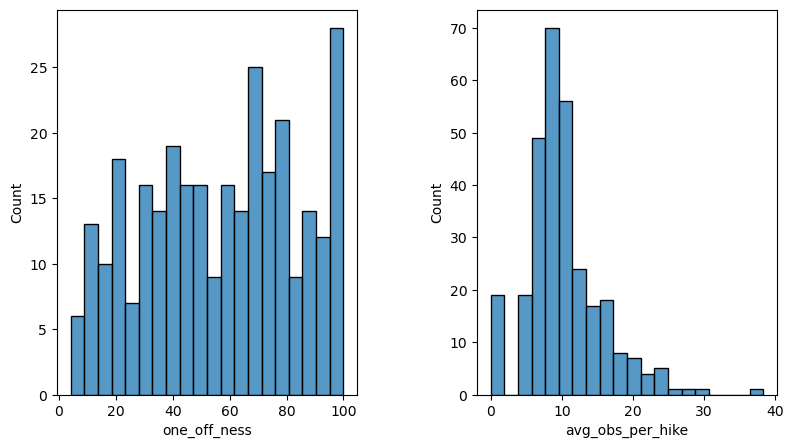

In [256]:
# What do the distributions of the metrics look like as histograms?
plt.subplots(1, 2, figsize = (9, 5))
plt.subplots_adjust(left=0.1,
                        right=0.9,  
                        wspace=0.4)
plt.subplot(1, 2, 1)
sns.histplot(user_data_df["one_off_ness"], bins = 20)
plt.subplot(1, 2, 2)
sns.histplot(user_data_df["avg_obs_per_hike"], bins = 20)
plt.show()

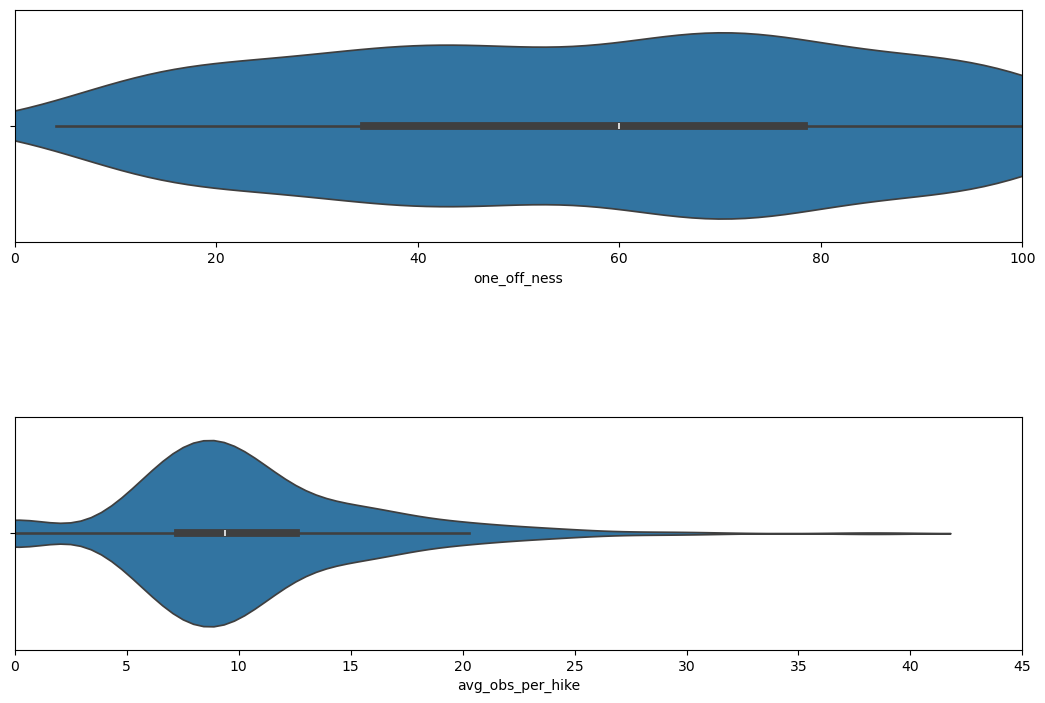

In [261]:
# what do the distributions look like as violinplots? 
# (I really do love KDE, it's so elegant and also am super biased toward median over mean
# so violinplots with box-and-whiker-plots are pretty much everything in my book)
plt.subplots(2, 1, figsize = (13, 8))
plt.subplots_adjust(bottom=0.1, 
                        top=0.9,  
                        hspace=0.75)
plt.subplot(2, 1, 1)
sns.violinplot(user_data_df["one_off_ness"], orient = 'h')
plt.xlim(0, 100)
plt.subplot(2, 1, 2)
sns.violinplot(user_data_df["avg_obs_per_hike"], orient = 'h')
plt.xlim(0, 45)
plt.show()

In [262]:
#plt.figure()
fig = px.scatter(user_data_df, x = "one_off_ness", y = "avg_obs_per_hike", hover_data = [user_data_df.index], color_discrete_sequence=["#74ac00"])
fig.add_hline(y = user_data_df["avg_obs_per_hike"].median(), line=dict(color='#337AB7'))
fig.add_vline(x = user_data_df["one_off_ness"].median(), line=dict(color='#337AB7'))



fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='One-Offness', 
    yaxis_title='Average Observations per Hike',
    title='As "One-Off" Behavior Increases, Observations per Hike Decrease', 
    title_x=0.5)

An earlier variation of this graph above appears on slide 6 and 9 of my presentation. 

### Visualizing for Presentation <a id ="11"></a>

Below I've modified the code for visualization so that it takes a specific user and specified clusters and returns the visualizations for inspection. 

In [265]:
def user_hikes(user, labels, df = df_sp, x = "latitude", y = "longitude", z = "obs_time_conv_(minutes)"):
    '''
    Takes in the user id of a user and the numerical labels assigned to a cluster (as a list) 
    and returns a two graphs for each cluster -- one over space and one with respect to space/time.
    
    Arguments:
    user = "user_id" number assigned to the user in the dataframe
    labels = list of any/all clusters to visualize for the user (if more than 10 are specified, the function will choose 10 at random)
    df = default is df_sp but user can specify a different dataframe 
    x = default is the "latitude" columns but user can identify a different independent variable
    y = default is the "longitude" column but user can identify a different dependent variable (for both graphs)
    z = default is the "obs_time_conv_(minutes)" column but user can identify a 2nd independent variable for the 2nd graph
    
    Returns: 
    Scatterplots of x and y beside a scatterplot of z and y for each cluster group specified 
    The scatterplots are scaled so that the x axis, y axis and z axis all span the same relative amount of time/space
    for best comparison of clustering. 
    '''  
    df = df[df["user_id"] == user]
    
    
    # identifying max 10 number of clusters to visualize chosen at random
    if len(labels) > 10:
        labels = np.random.choice(labels, size=10, replace=False)
    if len(labels) == 0:
        print("No clusters to view")
        return

    # find the biggest diff of lat, lon and time for all clusters
    # to make all windows for graphs cover the same approximate area
    lat_diff = 0
    lon_diff = 0
    time_diff = 0
    for i in labels:
        cluster = df[df["Cluster_Label"] == i]
        x_diff = cluster[x].max() - cluster[x].min() # largest difference in the cluster
        if x_diff > lat_diff:
            lat_diff = x_diff # replaces largest overall diff if cluster diff is bigger
        y_diff = cluster[y].max() - cluster[y].min()
        if y_diff > lon_diff:
            lon_diff = y_diff
        z_diff = cluster[z].max() - cluster[z].min()
        if z_diff > time_diff:
            time_diff = z_diff

    # graph all clusters
    # num of rows:
    r = len(labels)
    #set up axes for subplots: 2 per cluster
    plt.subplots(r, 2, figsize=(8, 25))
    # space between subplots (code from geeks for geeks)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)

    sub_num = 1 # initial subplot will be 1
    for i in labels:           
        # identify the data for the specific cluster
        cluster = df[df["Cluster_Label"] == i]
        # create the scale relative to differences calculated above
        min_x = cluster[x].min() - 0.001
        max_x = cluster[x].min() + lat_diff + 0.001
        min_y = cluster[y].min() - 0.001
        max_y = cluster[y].min() + lon_diff + 0.001
        min_z = cluster[z].min() - 10
        max_z = cluster[z].min() + time_diff + 10

        # create scatters for x and y
        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[x], cluster[y], c = '#74ac00')
        plt.title(f'Cluster {i} has {cluster.shape[0]} points')
        plt.xlabel(x)
        plt.xlim(min_x, max_x) 
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1 # move the count along for what subplot we are on
        
        # create scatters for z and y
        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[z], cluster[y], c = '#337AB7')
        plt.xlabel("time since obs1")
        plt.xlim(min_z, max_z)
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1  # move the count along for what subplot we are on

    plt.show()
    return

I'm using the plotly scatterplot to choose users at different places in the distribution. Then drilling down to visualize some of their clusters.

In [267]:
#What are the range of cluster names and sizes for this user at the top left corner?
df_sp[(df_sp["user_id"] == 395895) & (df_sp["Cluster_Label"] != -1)]["Cluster_Label"].value_counts()


1221.0    321
1885.0    319
2000.0    273
1217.0    270
1980.0    263
         ... 
211.0       5
139.0       5
969.0       5
1718.0      5
0.0         5
Name: Cluster_Label, Length: 2129, dtype: int64

In [275]:
#What does a random sample of 20 for this user return?
df_sp[(df_sp["user_id"] == 395895) & (df_sp["Cluster_Label"] != -1)]["Cluster_Label"].value_counts().sample(20).sort_values()

1657.0      7
1922.0     10
416.0      10
1912.0     15
1881.0     16
579.0      16
1347.0     18
1617.0     19
1511.0     29
67.0       31
1265.0     31
1924.0     32
1593.0     36
1143.0     40
869.0      52
1522.0     66
960.0      70
1330.0     90
1272.0     94
747.0     111
Name: Cluster_Label, dtype: int64

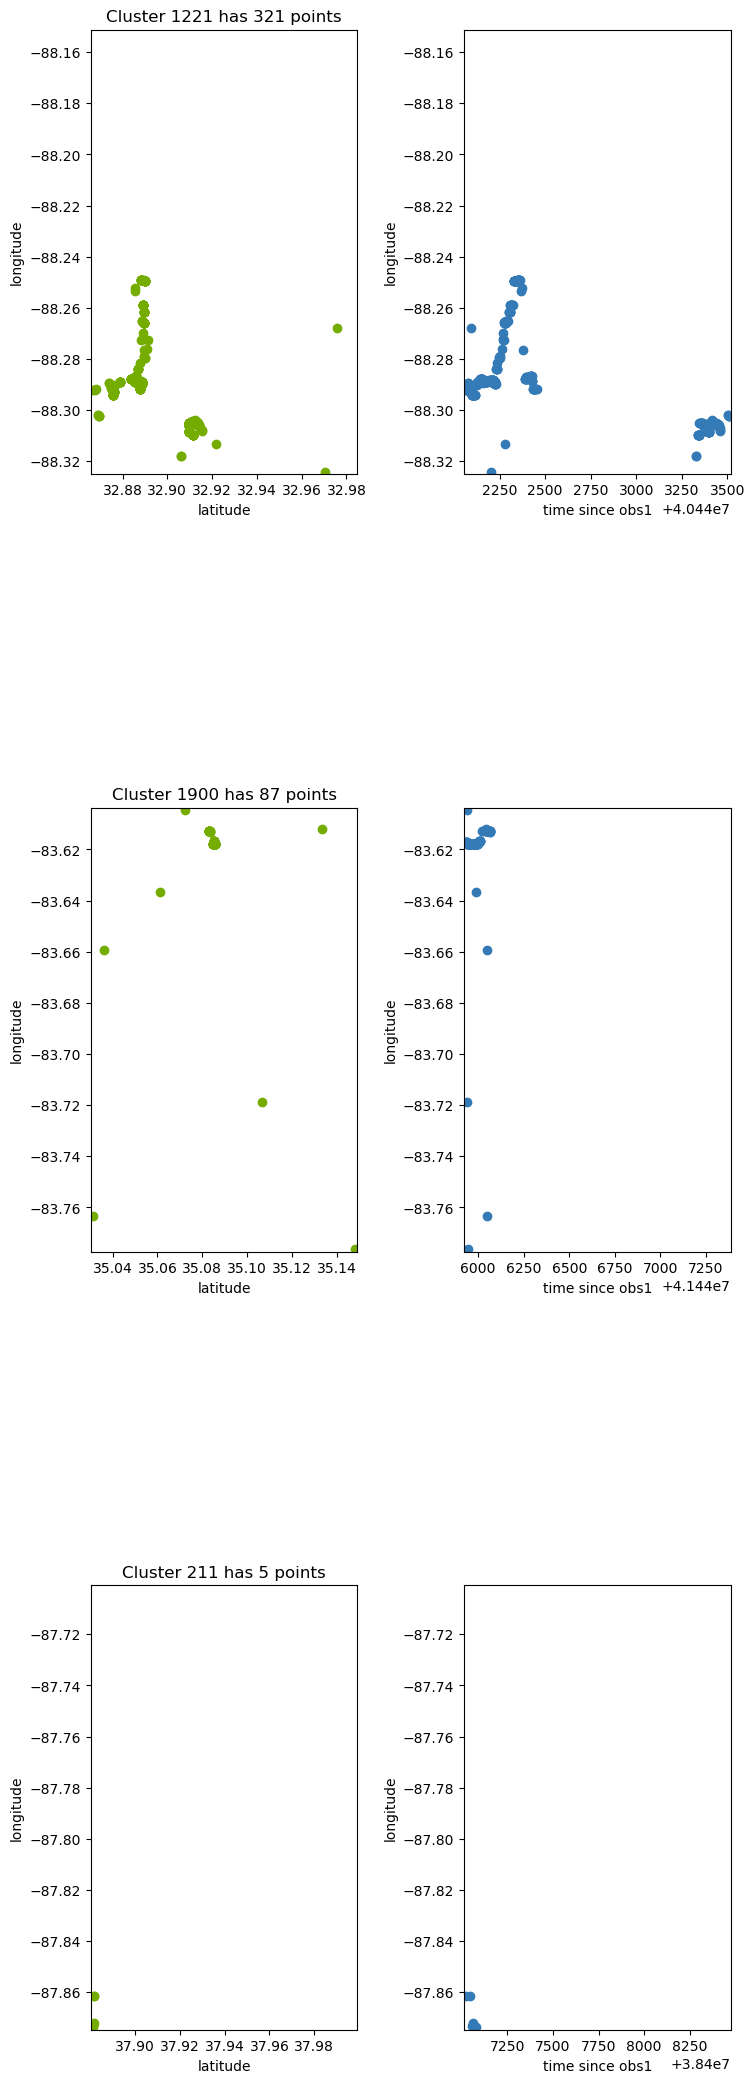

In [278]:
# what does one big, one medium, and one small cluster look like?
user_hikes(395895, [1221, 1900, 211])

Top "cluster" might be two different hikes but the other two are probably one. The variation in lat/lon in the medium size cluster is likely due to obscured geoprivacy.

In [270]:
# Visualizing the "medium size" point with "coordinates_obscured" as color which shows my guess was correct about lat/lon variation
# Touching it up for potential use in presentation

user = 395895
cluster = 1900
example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
num_cluster = example.shape[0]

fig = px.scatter(example, x = "time_observed_at", y = "longitude", color = "coordinates_obscured", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Time of Observation', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f"This user's 'hike' has {num_cluster} observations <br> over a span of 2.5 hours.", #plotly uses html to linebreak
    title_x=0.42) # adjust this to center title



In [279]:
# same visualization techniques but for lat/lon

fig = px.scatter(example, x = "latitude", y = "longitude", color = "coordinates_obscured", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Latitude', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'Obscured Locations for Threatened Species <br> Give Incorrect Coordinates',
    title_x=0.45) 


In [280]:
# Visualizing the area actually covered using a super-imposed map

fig = px.scatter_mapbox(example, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data = ["coordinates_obscured", "url"],
                        color_discrete_sequence=["#f16f3a"],
                        zoom=13, 
                        height=400,
                        width=600)

fig.update_layout(mapbox_style="open-street-map") 


The visualizations above appear on slide 10 of my presentation.

In [264]:
# list of url links for this user's hike
#(seems the user removed these observations at some point--the links don't work?)
# this makes me wonder if either a) the back-end database retains observations even if users remove them from the website
# OR b) if my download somehow triggered the user to take precautions and remove public observations
example[ "url"]

500581    https://www.inaturalist.org/observations/16608...
500582    https://www.inaturalist.org/observations/16608...
500583    https://www.inaturalist.org/observations/16608...
500584    https://www.inaturalist.org/observations/16608...
500585    https://www.inaturalist.org/observations/16608...
                                ...                        
500664    https://www.inaturalist.org/observations/16608...
500665    https://www.inaturalist.org/observations/16608...
500666    https://www.inaturalist.org/observations/16608...
500667    https://www.inaturalist.org/observations/16608...
500668    https://www.inaturalist.org/observations/16608...
Name: url, Length: 87, dtype: object

In [281]:
#What are the range of cluster names and sizes for this user toward the top right?
df_sp[(df_sp["user_id"] == 2013202) & (df_sp["Cluster_Label"] != -1)]["Cluster_Label"].value_counts()

0.0    21
2.0    15
1.0     9
Name: Cluster_Label, dtype: int64

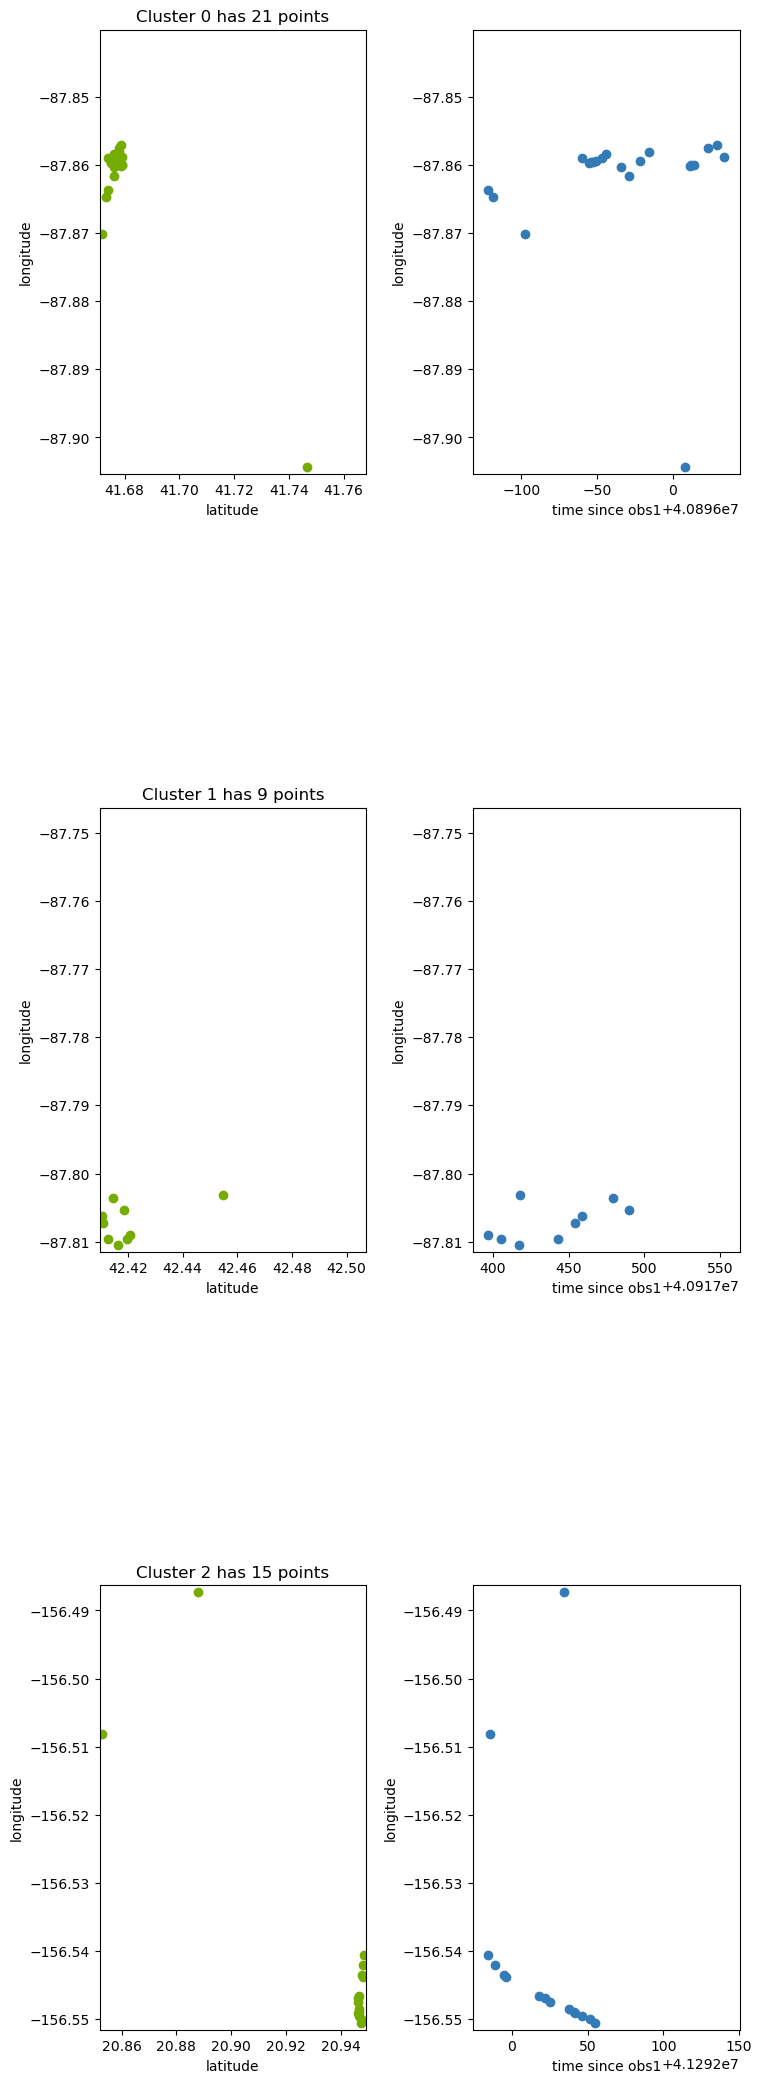

In [282]:
# what do the clusters for this user look like?
user_hikes(2013202, [0, 1, 2])

All very much look like hikes--again variation in lat/lon is likely due to geoprivacy.

In [283]:
# Cluster 1 looks like a fun loop--let's see
user = 2013202
cluster = 1
example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
num_cluster = example.shape[0]

fig = px.scatter(example, x = "time_observed_at", y = "longitude", color = "coordinates_obscured", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Time of Observation', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'User {user} Hike has {num_cluster} observations', 
    title_x=0.43) 

In [284]:
# Same cluster from lat/lon
fig = px.scatter(example, x = "latitude", y = "longitude", color = "coordinates_obscured", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Latitude', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'One Observation Looks Out of Place <br>Due to Obscuration', 
    title_x=0.43)

In [285]:
# visualizing using map
fig = px.scatter_mapbox(example, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data = ["coordinates_obscured", "url"],
                        color_discrete_sequence=["#f16f3a"],
                        zoom=13, 
                        height=400,
                        width=600)

fig.update_layout(mapbox_style="open-street-map") 


In [279]:
# list of urls for the hike
# these urls work
example[ "url"]

857426    https://www.inaturalist.org/observations/65571769
857427    https://www.inaturalist.org/observations/65571703
857428    https://www.inaturalist.org/observations/65571627
857429    https://www.inaturalist.org/observations/65571227
857430    https://www.inaturalist.org/observations/65571635
                                ...                        
857673    https://www.inaturalist.org/observations/16420...
857674    https://www.inaturalist.org/observations/17162...
857675    https://www.inaturalist.org/observations/18126...
857676    https://www.inaturalist.org/observations/18647...
857677    https://www.inaturalist.org/observations/19215...
Name: url, Length: 207, dtype: object

What about the user in the lower right corner (excluding those that have no clusters)?

In [283]:
df_sp[df_sp["user_id"] == 1141686]["Cluster_Label"].value_counts()
# only one cluster of 5 observations

-1.0    385
 0.0      5
Name: Cluster_Label, dtype: int64

In [286]:
user = 1141686
cluster = 0
example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
num_cluster = example.shape[0]

fig = px.scatter(example, x = "time_observed_at", y = "longitude", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Time of Observation', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'User {user} Hike has {num_cluster} observations', 
    title_x=0.5)

In [287]:
fig = px.scatter(example, x = "latitude", y = "longitude", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Latitude', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'Over a 30 Minute Span, This User Covered about 15 Meters ', 
    title_x=0.5) 

In [288]:
fig = px.scatter_mapbox(example, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data = ["coordinates_obscured", example.index],
                        color_discrete_sequence=["#f16f3a"],
                        zoom=13, 
                        height=600,
                        width=600)

fig.update_layout(mapbox_style="open-street-map") 

Yikes. This user should probs use the iSeek app for identifying neighborhood plants. But this is an example of where iNatralist could target users--it might be better done with a different clustering method but uploading place data, identifying different kinds of geographical landscapes (residential vs. other in this case) and for users who are uploading in residential, especially multiple observations, they can be given a "warning" about geoprivacy concerns, the iNaturalist option for obscuring geolocation of observations and also offered iSeek as an option that identifies plants using the iNaturalist AI but without adding observations to the public database. These users also might be interested in native garden planting since. 

In [288]:
# these urls work
example[ "url"]

762730    https://www.inaturalist.org/observations/94130872
762731    https://www.inaturalist.org/observations/94132792
762732    https://www.inaturalist.org/observations/94133071
762733    https://www.inaturalist.org/observations/94133337
762734    https://www.inaturalist.org/observations/94133356
Name: url, dtype: object

In [289]:
# What about someone from the middle of the scatterplot?
df_sp[(df_sp["user_id"] == 1459875) & (df_sp["Cluster_Label"] != -1)]["Cluster_Label"].value_counts()


5.0     22
19.0    20
13.0    20
9.0     18
10.0    14
6.0     13
2.0     12
17.0    12
12.0    12
14.0     9
8.0      9
21.0     7
16.0     7
15.0     7
11.0     6
1.0      5
7.0      5
4.0      5
18.0     5
3.0      5
20.0     5
0.0      5
Name: Cluster_Label, dtype: int64

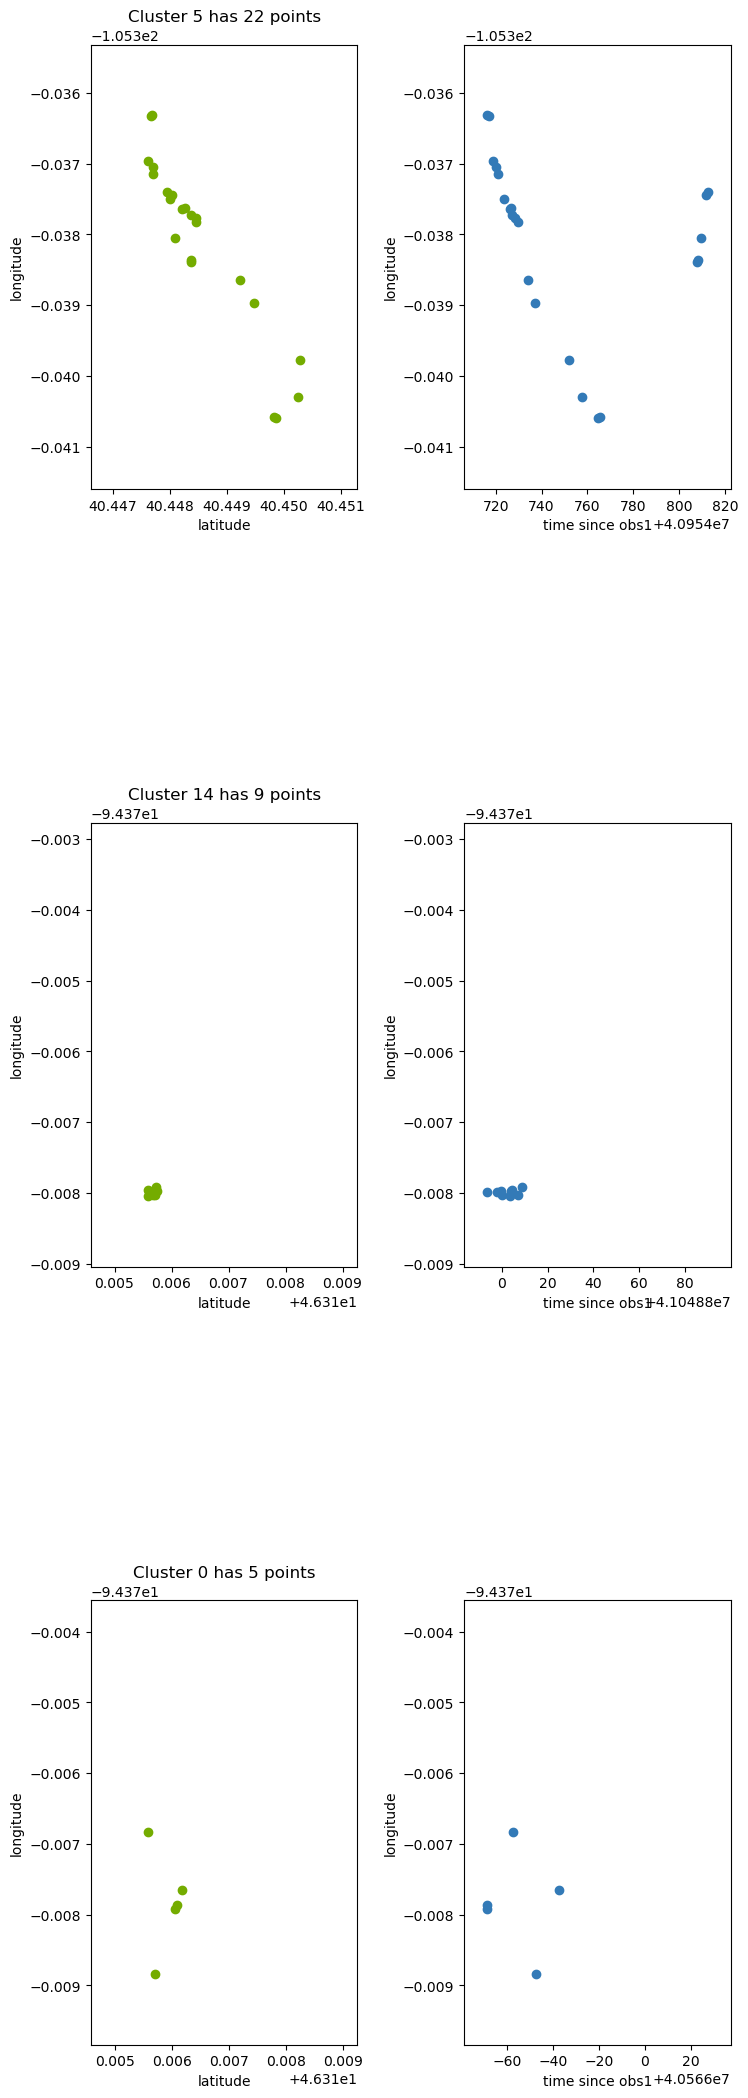

In [290]:
# what do the some of the clusters (big, medium, small) for this user look like?
user_hikes(1459875, [5, 14, 0])

These clusters look like proper "hikes". Curious to see how that cluster of 22 observations map.

In [319]:
user = 1459875
cluster = 5

example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
num_cluster = example.shape[0]

fig = px.scatter(example, x = "time_observed_at", y = "longitude", color = "coordinates_obscured", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Time of Observation', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'User {user} Hike has {num_cluster} observations', 
    title_x=0.43) 

In [324]:
fig = px.scatter(example, x = "latitude", y = "longitude", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Latitude', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'Over Two Hours, This User Covered about FIX IF USED IN PRESENTATION ', 
    title_x=0.5) 

In [305]:
fig = px.scatter_mapbox(example, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data = ["coordinates_obscured", example.index],
                        color_discrete_sequence=["#f16f3a"],
                        zoom=13, 
                        height=600,
                        width=600)

fig.update_layout(mapbox_style="open-street-map") 

Cluster 5 looks like an off-trailer lol, but definitely a hike. Wondering if this "hike" is a well-traveled one by people but not "official" so not on the map. This is an example of how iNaturalist could identify differences in how natural spaces are actually being used vs. the "official" usage.

In [315]:
# What about someone from the middle of the upper left quadrant?
df_sp[(df_sp["user_id"] == 416976) & (df_sp["Cluster_Label"] != -1)]["Cluster_Label"].value_counts()



8.0     55
22.0    50
2.0     33
34.0    33
37.0    30
        ..
31.0     5
29.0     5
25.0     5
11.0     5
33.0     5
Name: Cluster_Label, Length: 67, dtype: int64

In [317]:
df_sp[(df_sp["user_id"] == 416976) & (df_sp["Cluster_Label"] != -1)]["Cluster_Label"].value_counts().sample(20)

49.0     5
53.0    10
1.0     12
34.0    33
57.0     9
36.0     5
43.0     5
21.0    20
51.0    11
56.0     6
42.0    13
11.0     5
55.0    13
41.0     6
30.0     6
22.0    50
5.0     17
60.0     9
19.0    25
3.0     22
Name: Cluster_Label, dtype: int64

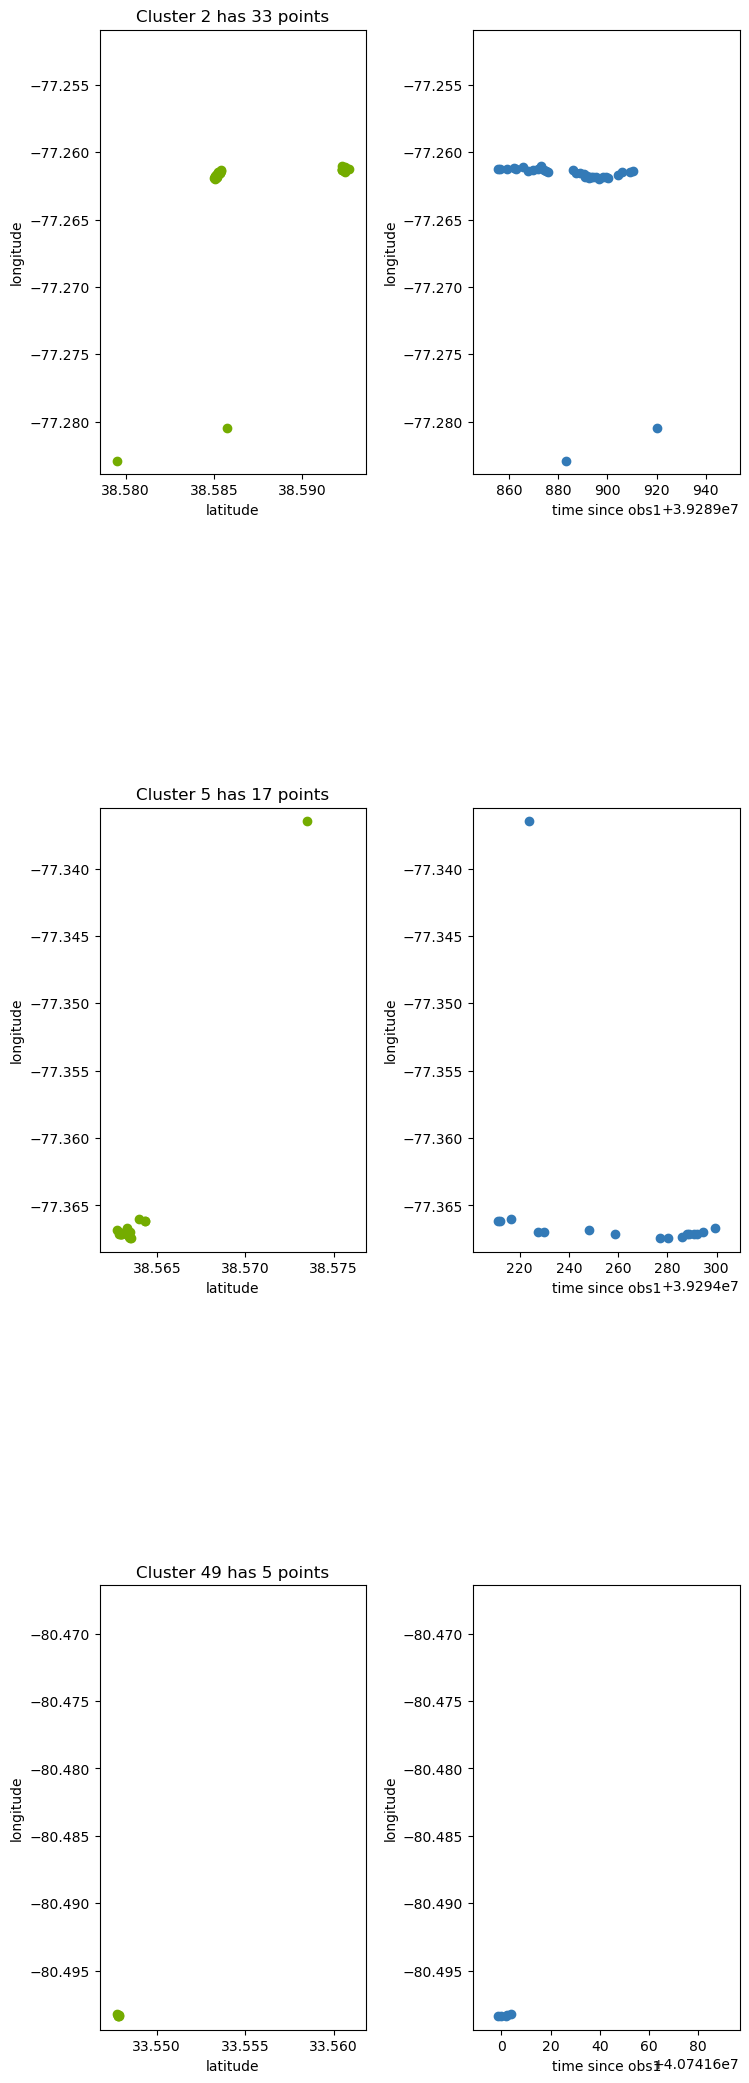

In [318]:
# what does one big, one medium, and one small cluster look like?
user_hikes(416976, [2, 5, 49])

Yup these look like hikes :-)

In [320]:
# curious if those two lat/lon that are out of place are obscured but also curious about that break in between
user = 416976
cluster = 2

example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
num_cluster = example.shape[0]

fig = px.scatter(example, x = "time_observed_at", y = "longitude", color = "coordinates_obscured", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Time of Observation', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'User {user} Hike has {num_cluster} observations', 
    title_x=0.43) 

Strange--not obscured. Wonder though if their positional accuracy is bad? They are really out of place.

In [321]:
# curious if those two lat/lon that are out of place are obscured
user = 416976
cluster = 2

example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
num_cluster = example.shape[0]

fig = px.scatter(example, x = "time_observed_at", y = "longitude", color = "public_positional_accuracy")


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Time of Observation', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'User {user} Hike has {num_cluster} observations', 
    title_x=0.43) 

Yup! Their location as recorded can't be trusted because the public positional accuracy is really distant for some reason. 

In [323]:
fig = px.scatter(example, x = "latitude", y = "longitude", color = "coordinates_obscured", color_discrete_sequence=["#74ac00", "#f16f3a"])


fig.update_layout(
    plot_bgcolor='#DDDDDD',
    xaxis_title='Latitude', 
    yaxis_title='Longitude',
    height=400,  
    width=600,
    title=f'FIX TITLE IF USED IN PRESENTATION',
    title_x=0.45)

In [325]:
fig = px.scatter_mapbox(example, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data = ["coordinates_obscured", example.index],
                        color_discrete_sequence=["#f16f3a"],
                        zoom=13, 
                        height=600,
                        width=600)

fig.update_layout(mapbox_style="open-street-map") 

If I had personally clustered this data, I would have split this into two "hikes" but there is a case for it being one trip to one place with a lunch break (or something) in between.

In [326]:
example[ "url"]

513314    https://www.inaturalist.org/observations/23132785
513315    https://www.inaturalist.org/observations/23133283
513316    https://www.inaturalist.org/observations/23134783
513317    https://www.inaturalist.org/observations/23133266
513318    https://www.inaturalist.org/observations/23133574
513319    https://www.inaturalist.org/observations/23135285
513320    https://www.inaturalist.org/observations/23135422
513321    https://www.inaturalist.org/observations/23135530
513322    https://www.inaturalist.org/observations/23135644
513323    https://www.inaturalist.org/observations/23135731
513324    https://www.inaturalist.org/observations/23136376
513325    https://www.inaturalist.org/observations/23136482
513326    https://www.inaturalist.org/observations/23136617
513327    https://www.inaturalist.org/observations/23136673
513328    https://www.inaturalist.org/observations/23136720
513329    https://www.inaturalist.org/observations/23136872
513330    https://www.inaturalist.org/ob

The map and urls above provide the image for slides 1 and 5 for my presentation.

In [332]:
# Generating other pictures for presentation slide 3
user = 1234210
cluster = 3
example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
fig = px.scatter_mapbox(example, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data = ["coordinates_obscured", example.index],
                        color_discrete_sequence=["#f16f3a"],
                        zoom=13, 
                        height=600,
                        width=600)

fig.update_layout(mapbox_style="open-street-map") 

In [335]:
# Generating other pictures for presentation slide 3
user = 635041
cluster = 1
example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
fig = px.scatter_mapbox(example, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data = ["coordinates_obscured", example.index],
                        color_discrete_sequence=["#f16f3a"],
                        zoom=13, 
                        height=600,
                        width=600)

fig.update_layout(mapbox_style="open-street-map") 

In [337]:
# Generating other pictures for presentation slide 3
user = 2419279
cluster = 155
example = df_sp[(df_sp["user_id"] == user) & (df_sp["Cluster_Label"] == cluster)]
fig = px.scatter_mapbox(example, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data = ["coordinates_obscured", example.index],
                        color_discrete_sequence=["#f16f3a"],
                        zoom=13, 
                        height=600,
                        width=600)

fig.update_layout(mapbox_style="open-street-map") 